In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import shutil



In [2]:
def extract_hoppings_from_hr(hr_path, dim=2):
    """
    Extract hopping terms from wannier90_hr.dat

    Parameters
    ----------
    hr_path : str or Path
        Path to wannier90_hr.dat
    dim : int
        Dimensionality of the model (2 or 3).
        For 2D, Rz will be ignored.

    Returns
    -------
    num_wann : int
        Number of Wannier orbitals
    onsite : np.ndarray (complex)
        On-site terms H_ii(R=0)
    hoppings : list of tuples
        Each element is (R, i, j, t),
        where:
            R : list[int]   (length = dim)
            i,j : int       (0-based)
            t : complex
    """
    hr_path = Path(hr_path)
    lines = hr_path.read_text().splitlines()

    # --- header ---
    num_wann = int(lines[1].strip())
    nrpts = int(lines[2].strip())

    # --- skip degeneracy lines ---
    idx = 3
    degeneracies = []
    while len(degeneracies) < nrpts:
        parts = lines[idx].split()
        for p in parts:
            if len(degeneracies) < nrpts:
                degeneracies.append(int(p))
        idx += 1

    onsite = np.zeros(num_wann, dtype=complex)
    hoppings = []

    # --- hopping data ---
    for line in lines[idx:]:
        parts = line.split()
        if len(parts) != 7:
            continue

        Rx, Ry, Rz = map(int, parts[:3])
        i, j = map(int, parts[3:5])
        re, im = map(float, parts[5:7])

        t = re + 1j * im
        i0, j0 = i - 1, j - 1  # Wannier90 is 1-based

        # on-site term
        if Rx == 0 and Ry == 0 and Rz == 0 and i0 == j0:
            onsite[i0] = t
        else:
            R = [Rx, Ry] if dim == 2 else [Rx, Ry, Rz]
            hoppings.append((R, i0, j0, t))

    return num_wann, onsite, hoppings


In [3]:
# ===== 晶格（2D 四方，单位 Å）=====
a0 = 4.1630263607523368

lat_vecs = [
    [a0, 0.0],
    [0.0, a0],
]

# ===== 轨道中心（分数坐标）=====
# 2 个磁性原子 × dz2 × (up, dn)
orb_vecs = [
    [0.5, 0.0],  # atom A, dz2 ↑
    [0.0, 0.5],  # atom B, dz2 ↑
    [0.5, 0.0],  # atom A, dz2 ↓
    [0.0, 0.5],  # atom B, dz2 ↓
]


In [4]:
workdir = Path(".").resolve()

dat_files = sorted(workdir.glob("wannier*.dat"))

if not dat_files:
    raise RuntimeError("No wannier*.dat files found in current directory.")

print(f"Found {len(dat_files)} hr.dat file(s):")
for f in dat_files:
    print("  -", f.name)


Found 2329 hr.dat file(s):
  - wannier90_iE15_iE22_iT12_iT22_iT35_iT42.dat
  - wannier90_iE15_iE22_iT12_iT22_iT35_iT43.dat
  - wannier90_iE15_iE22_iT12_iT22_iT35_iT44.dat
  - wannier90_iE15_iE22_iT12_iT22_iT35_iT45.dat
  - wannier90_iE15_iE22_iT12_iT23_iT31_iT41.dat
  - wannier90_iE15_iE22_iT12_iT23_iT31_iT42.dat
  - wannier90_iE15_iE22_iT12_iT23_iT31_iT43.dat
  - wannier90_iE15_iE22_iT12_iT23_iT31_iT44.dat
  - wannier90_iE15_iE22_iT12_iT23_iT31_iT45.dat
  - wannier90_iE15_iE22_iT12_iT23_iT32_iT41.dat
  - wannier90_iE15_iE22_iT12_iT23_iT32_iT42.dat
  - wannier90_iE15_iE22_iT12_iT23_iT32_iT43.dat
  - wannier90_iE15_iE22_iT12_iT23_iT32_iT44.dat
  - wannier90_iE15_iE22_iT12_iT23_iT32_iT45.dat
  - wannier90_iE15_iE22_iT12_iT23_iT33_iT41.dat
  - wannier90_iE15_iE22_iT12_iT23_iT33_iT42.dat
  - wannier90_iE15_iE22_iT12_iT23_iT33_iT43.dat
  - wannier90_iE15_iE22_iT12_iT23_iT33_iT44.dat
  - wannier90_iE15_iE22_iT12_iT23_iT33_iT45.dat
  - wannier90_iE15_iE22_iT12_iT23_iT34_iT41.dat
  - wannier90

In [5]:
import numpy as np
from pathlib import Path

def save_band_dat(
    out_file,
    k_dist,
    evals,
    label=None,
    k_node=None,
    energy_shift=0.0,
    meta_dict=None,
    fmt="%.10f",
):
    """
    保存 Band.dat（数值能带）
    第一列: k_dist
    后续列: E1, E2, ..., ENb
    """
    out_file = Path(out_file)
    out_file.parent.mkdir(parents=True, exist_ok=True)

    k_dist = np.asarray(k_dist, float).reshape(-1)
    E = np.asarray(evals, float)

    if E.ndim != 2:
        raise ValueError(f"evals 必须是 2D 数组 (Nb, Nk)，但当前形状是 {E.shape}")
    if E.shape[1] != k_dist.size:
        raise ValueError(f"Nk 不一致：k_dist={k_dist.size}, evals.shape={E.shape}")

    Nb, Nk = E.shape

    # 输出矩阵：Nk 行，(1+Nb) 列
    M = np.column_stack([k_dist, E.T])

    # 头部信息
    header_lines = []
    header_lines.append(f"Nk={Nk} Nb={Nb} energy_shift={energy_shift:+.10f} (E -> E - energy_shift)")
    header_lines.append("columns: k_dist " + " ".join([f"E{ib+1}" for ib in range(Nb)]))

    if (label is not None) and (k_node is not None):
        header_lines.append("label: " + " ".join([str(s) for s in label]))
        header_lines.append("k_node: " + " ".join([f"{x:.10f}" for x in np.asarray(k_node, float).ravel()]))

    if meta_dict is not None:
        for k, v in meta_dict.items():
            header_lines.append(f"{k}: {v}")

    np.savetxt(out_file, M, fmt=fmt, header="\n".join(header_lines), comments="# ")


In [ ]:
from pythtb import tb_model
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import shutil  # 你后面用到了

# ==================================================
# 工作目录与输入文件
# ==================================================
workdir = Path(r"E:\马睿骁\组会汇报\Nb2OSSe\pythTB\workflow")
dat_files = sorted(workdir.glob("wannier90_*.dat"))

# ==================================================
# 相图标准
# ==================================================

def classify_phase(evals, gap_min=1e-3):
    E = np.asarray(evals, float).ravel()
    Es = np.unique(np.sort(E))

    if Es.size < 10:
        return {"has_gap": False, "gap": 0.0, "midgap": None, "phase": "metal"}

    gaps = Es[1:] - Es[:-1]
    igap = int(np.argmax(gaps))
    gap = gaps[igap]

    if gap < gap_min:
        return {"has_gap": False, "gap": float(gap), "midgap": None, "phase": "metal"}

    VBM = Es[igap]
    CBM = Es[igap + 1]
    return {"has_gap": True, "gap": float(gap), "midgap": 0.5 * (VBM + CBM), "phase": "insulator"}

# ==================================================
# Hermitian hopping 的“规范 R”判据
# ==================================================
def canonical_R(R):
    R = tuple(R)
    return R > tuple(-r for r in R)

# ==================================================
# 仅用于可视化的 mid-gap 计算
# ==================================================
def find_midgap(E_all, search_window=2.0, gap_min=1e-3):
    E = np.asarray(E_all, dtype=float)
    mask = (E >= -search_window) & (E <= search_window)
    Ew = E[mask]
    if Ew.size < 10:
        return None

    Es = np.unique(np.sort(Ew))
    if Es.size < 10:
        return None

    gaps = Es[1:] - Es[:-1]
    igap = int(np.argmax(gaps))
    gap = gaps[igap]
    if gap < gap_min:
        return None

    VBM = Es[igap]
    CBM = Es[igap + 1]
    return 0.5 * (VBM + CBM)

# ==================================================
# 高对称路径：Γ–X–M–Y–Γ
# ==================================================
path = [
    [0.0, 0.0],
    [0.5, 0.0],
    [0.5, 0.5],
    [0.0, 0.5],
    [0.0, 0.0],
]
label = (r"$\Gamma$", r"$X$", r"$M$", r"$Y$", r"$\Gamma$")
nk = 301

# ==================================================
# 主循环：无筛选，生成所有体能带
# ==================================================
for dat in dat_files:
    name = dat.stem
    calc_dir = workdir / name
    calc_dir.mkdir(exist_ok=True)

    print(f"\nProcessing {dat.name}")

    # --------------------------------------------------
    # 1) 读取 Wannier hr
    # --------------------------------------------------
    num_wann, onsite, hoppings = extract_hoppings_from_hr(dat, dim=2)

    if num_wann != len(orb_vecs):
        print(f"  [SKIP] Orbital mismatch: {num_wann} vs {len(orb_vecs)}")
        continue

    # --------------------------------------------------
    # 2) 构造 TB 模型
    # --------------------------------------------------
    model = tb_model(dim_k=2, dim_r=2, lat=lat_vecs, orb=orb_vecs)

    model.set_onsite(onsite.real.tolist())

    nhop_used = 0
    for R, i, j, t in hoppings:
        R = tuple(R)
        if (i > j) or (i == j and not canonical_R(R)):
            continue
        model.set_hop(t, i, j, list(R))
        nhop_used += 1

    print(f"  [INFO] Used hoppings: {nhop_used}")

    # --------------------------------------------------
    # 3) 体能带计算（原始本征值）
    # --------------------------------------------------
    k_vec, k_dist, k_node = model.k_path(path, nk, report=False)
    evals = model.solve_ham(k_pts=k_vec).T  # (nband, nk)

    # --------------------------------------------------
    # 3.5) 仅用于可视化：mid-gap 对齐
    # --------------------------------------------------
    midgap = find_midgap(evals.ravel(), search_window=2.0)

    if midgap is not None:
        evals_plot = evals - midgap
        title_suffix = " (mid-gap aligned)"
        print(f"  [INFO] mid-gap = {midgap:+.6f} eV → shifted to 0")
    else:
        evals_plot = evals
        title_suffix = " (no clear gap)"
        print("  [INFO] No clear gap found (possible metal or phase boundary)")

    # --------------------------------------------------
    # 4) 绘图
    # --------------------------------------------------
    fig, ax = plt.subplots(figsize=(6, 4.5))
    ax.set_xlim(k_node[0], k_node[-1])
    ax.set_xticks(k_node)
    ax.set_xticklabels(label)

    for x in k_node:
        ax.axvline(x=x, lw=0.5, color="k")

    for band in evals_plot:
        ax.plot(k_dist, band, color="black", lw=1)

    ax.axhline(0.0, color="red", ls="--", lw=0.8)
    ax.set_xlabel("Path in k-space")
    ax.set_ylabel(r"$E$ (eV)")
    ax.set_title(f"{name}{title_suffix}")

    plt.tight_layout()

    # --------------------------------------------------
    # 5) 保存图
    # --------------------------------------------------
    fig.savefig(calc_dir / "bandstructure.png", dpi=300)
    fig.savefig(calc_dir / "bandstructure.pdf")
    plt.close(fig)
    print(f"  [OK] Saved figure to {calc_dir.name}/")

    # --------------------------------------------------
    # 5.5) 导出 Band.dat（注意：必须在 for 循环内部）
    # --------------------------------------------------
    save_band_dat(
        out_file=calc_dir / "Band_raw.dat",
        k_dist=k_dist,
        evals=evals,
        label=label,
        k_node=k_node,
        energy_shift=0.0,
        meta_dict={"name": name},
    )

    shift = float(midgap) if (midgap is not None) else 0.0
    save_band_dat(
        out_file=calc_dir / "Band.dat",
        k_dist=k_dist,
        evals=evals_plot,
        label=label,
        k_node=k_node,
        energy_shift=shift,
        meta_dict={"name": name, "midgap_eV": (midgap if midgap is not None else "NaN")},
    )
    print(f"  [OK] Saved Band.dat to {calc_dir.name}/")

    # --------------------------------------------------
    # 6) 相信息记录
    # --------------------------------------------------
    phase_info = classify_phase(evals)

    info_file = calc_dir / "phase_info.txt"
    with open(info_file, "w", encoding="utf-8") as f:
        f.write(f"name        = {name}\n")
        f.write(f"nhop_used  = {nhop_used}\n")
        f.write(f"nband      = {evals.shape[0]}\n")
        f.write(f"nk         = {evals.shape[1]}\n")
        f.write(f"has_gap    = {phase_info['has_gap']}\n")
        f.write(f"gap_eV     = {phase_info['gap']:.8f}\n")
        f.write(f"midgap_eV  = {phase_info['midgap'] if phase_info['midgap'] is not None else 'NaN'}\n")
        f.write(f"phase      = {phase_info['phase']}\n")

    # --------------------------------------------------
    # 7) 移动 hr.dat 到该目录
    # --------------------------------------------------
    hr_target = calc_dir / dat.name
    if not hr_target.exists():
        shutil.move(str(dat), hr_target)
        print(f"  [INFO] Moved {dat.name} → {calc_dir.name}/")
    else:
        print(f"  [WARN] {dat.name} already exists in {calc_dir.name}/, skip move")

    print(f"  [OK] Finished {calc_dir.name}/")


In [1]:
import re
from pathlib import Path

_param_pat = re.compile(r'([A-Za-z]\w*)\s*=\s*([-+]?\d+(?:\.\d+)?(?:[Ee][-+]?\d+)?)')

def parse_params_from_hr_first_line(hr_path: Path):
    """
    从 hr.dat 第一行解析参数。
    期望格式示例：
    # e1 = -0.100000000000 e2 = -0.100000000000 t1 = -0.100000000000 ...

    返回：
      params: dict，如 {"e1":-0.1,"e2":-0.1,"t1":...}
    """
    hr_path = Path(hr_path)
    with open(hr_path, "r", encoding="utf-8", errors="ignore") as f:
        first = f.readline().strip()

    # 去掉开头的 '#'
    if first.startswith("#"):
        first = first[1:].strip()

    matches = _param_pat.findall(first)
    if not matches:
        raise ValueError(f"第一行未解析到任何 'key = value' 参数：{hr_path}\nLine: {first}")

    params = {k: float(v) for k, v in matches}
    return params


In [2]:
import csv
from pathlib import Path

workdir = Path(r"E:\马睿骁\组会汇报\Nb2OSSe\pythTB\workflow")  # 确保与你主脚本一致
out_csv = workdir / "index.csv"

rows = []
missing = 0

# 你的脚本把每个样本放在 workdir/name/ 里
for sample_dir in sorted([p for p in workdir.iterdir() if p.is_dir()]):
    band_path = sample_dir / "Band.dat"
    band_raw_path = sample_dir / "Band_raw.dat"

    # 在 sample_dir 里找 hr 文件（你移动过去的是 wannier90_*.dat）
    hr_list = sorted(sample_dir.glob("wannier90_*.dat"))
    if (not band_path.exists()) or (not hr_list):
        continue

    hr_path = hr_list[0]  # 若一个目录只有一个 hr，就取第一个
    try:
        params = parse_params_from_hr_first_line(hr_path)
    except Exception as e:
        print(f"[WARN] 解析参数失败：{hr_path}  -> {e}")
        missing += 1
        continue

    # 固定列顺序：先收集你关心的参数
    # 如果未来参数更多，可以在这里扩展
    keys = ["e1", "e2", "t1", "t2", "t3", "t4"]
    row = {
        "sample": sample_dir.name,
        "hr_file": str(hr_path),
        "band_file": str(band_path),
        "band_raw_file": str(band_raw_path) if band_raw_path.exists() else "",
    }
    for k in keys:
        row[k] = params.get(k, "")  # 如果某个参数缺失则留空

    rows.append(row)

# 写出 CSV
fieldnames = ["sample", "e1", "e2", "t1", "t2", "t3", "t4", "hr_file", "band_file", "band_raw_file"]
with open(out_csv, "w", newline="", encoding="utf-8") as f:
    w = csv.DictWriter(f, fieldnames=fieldnames)
    w.writeheader()
    for r in rows:
        w.writerow(r)

print(f"[OK] 写出 {out_csv}")
print(f"[INFO] 共收集样本数：{len(rows)}；解析失败：{missing}")


[OK] 写出 E:\马睿骁\组会汇报\Nb2OSSe\pythTB\workflow\index.csv
[INFO] 共收集样本数：15625；解析失败：0


In [3]:
import numpy as np
import pandas as pd
from pathlib import Path

# =========================
# 0) 配置
# =========================
index_csv = Path(r"E:\马睿骁\组会汇报\Nb2OSSe\pythTB\workflow\index.csv")

# 你要用哪一个作为标签/特征：Band.dat(对齐后) 或 Band_raw.dat(原始)
use_raw = False  # True -> 用 band_raw_file；False -> 用 band_file

# 是否只保留费米附近的固定 Nb_keep 条能带（可选）
Nb_keep = None   # 例如 12；None 表示保留所有
# 假设半填充：occ = Nb//2（如果你有更准确占据数，可改）
assume_half_filling = True

param_cols = ["e1", "e2", "t1", "t2", "t3", "t4"]

# =========================
# 1) 读取索引
# =========================
df = pd.read_csv(index_csv, encoding="utf-8")
print("index rows:", len(df))
print(df.head())

# 强制参数为 float（如果某些为空会报错，便于你发现问题）
X = df[param_cols].astype(float).to_numpy(dtype=np.float32)

# 选择能带文件列
band_col = "band_raw_file" if use_raw else "band_file"
band_paths = df[band_col].astype(str).tolist()

# =========================
# 2) 读取单个 Band.dat 的工具函数
# =========================
def load_band_dat_numeric(path: str):
    """
    读取 Band.dat / Band_raw.dat 的数值部分：
    返回 k_dist (Nk,), E (Nb, Nk)
    文件格式：第一列 k_dist，后面 Nb 列能量；注释行以 # 开头
    """
    path = Path(path)
    if not path.exists():
        raise FileNotFoundError(f"Band file not found: {path}")

    M = np.loadtxt(path, comments="#", dtype=float)  # shape (Nk, 1+Nb)
    if M.ndim != 2 or M.shape[1] < 2:
        raise ValueError(f"Band.dat 数值列不足：{path}, shape={M.shape}")

    k_dist = M[:, 0].astype(np.float32)
    E = M[:, 1:].T.astype(np.float32)  # (Nb, Nk)
    return k_dist, E

def maybe_slice_bands(E, Nb_keep):
    """
    从 (Nb, Nk) 中截取固定数量的能带（居中截取）
    """
    if Nb_keep is None:
        return E

    Nb, Nk = E.shape
    if Nb_keep > Nb:
        raise ValueError(f"Nb_keep={Nb_keep} 大于实际 Nb={Nb}")

    if assume_half_filling:
        occ = Nb // 2
        half = Nb_keep // 2
        i0 = max(0, occ - half)
        i1 = i0 + Nb_keep
        if i1 > Nb:
            i1 = Nb
            i0 = Nb - Nb_keep
        return E[i0:i1, :]
    else:
        # 不假设半填充：就简单取前 Nb_keep 条
        return E[:Nb_keep, :]

# =========================
# 3) 批量读取并检查 Nk/Nb 一致
# =========================
k_ref = None
Nk_ref = None
Nb_ref = None

Y_list = []
good_idx = []
bad = []

for i, p in enumerate(band_paths):
    try:
        k_dist, E = load_band_dat_numeric(p)
        E = maybe_slice_bands(E, Nb_keep)

        Nk = k_dist.size
        Nb = E.shape[0]

        if k_ref is None:
            k_ref = k_dist
            Nk_ref = Nk
            Nb_ref = Nb
        else:
            if Nk != Nk_ref:
                raise ValueError(f"Nk mismatch: {Nk} vs {Nk_ref}")
            # k_dist 允许存在极小数值误差，但应该整体一致
            if not np.allclose(k_dist, k_ref, rtol=0, atol=1e-6):
                raise ValueError("k_dist mismatch (not identical)")
            if Nb != Nb_ref:
                raise ValueError(f"Nb mismatch: {Nb} vs {Nb_ref}")

        # 展平：Y shape -> (Nb*Nk,)
        Y_list.append(E.reshape(-1))
        good_idx.append(i)

    except Exception as e:
        bad.append((i, p, str(e)))

print(f"[OK] loaded: {len(good_idx)} / {len(band_paths)}")
if bad:
    print("[WARN] failed samples (show first 10):")
    for t in bad[:10]:
        print("  idx=", t[0], "file=", t[1], "err=", t[2])

# 只保留成功样本
X_good = X[good_idx]
Y = np.vstack(Y_list).astype(np.float32)

print("X_good shape:", X_good.shape)  # (Ns, 6)
print("Y shape:", Y.shape)            # (Ns, Nb*Nk)
print("Nk_ref, Nb_ref:", Nk_ref, Nb_ref)


index rows: 15625
                                    sample   e1   e2   t1   t2   t3    t4  \
0  wannier90_iE11_iE21_iT11_iT21_iT31_iT41 -0.1 -0.1 -0.1 -0.1 -0.1 -0.10   
1  wannier90_iE11_iE21_iT11_iT21_iT31_iT42 -0.1 -0.1 -0.1 -0.1 -0.1 -0.05   
2  wannier90_iE11_iE21_iT11_iT21_iT31_iT43 -0.1 -0.1 -0.1 -0.1 -0.1  0.00   
3  wannier90_iE11_iE21_iT11_iT21_iT31_iT44 -0.1 -0.1 -0.1 -0.1 -0.1  0.05   
4  wannier90_iE11_iE21_iT11_iT21_iT31_iT45 -0.1 -0.1 -0.1 -0.1 -0.1  0.10   

                                             hr_file  \
0  E:\马睿骁\组会汇报\Nb2OSSe\pythTB\workflow\wannier90_...   
1  E:\马睿骁\组会汇报\Nb2OSSe\pythTB\workflow\wannier90_...   
2  E:\马睿骁\组会汇报\Nb2OSSe\pythTB\workflow\wannier90_...   
3  E:\马睿骁\组会汇报\Nb2OSSe\pythTB\workflow\wannier90_...   
4  E:\马睿骁\组会汇报\Nb2OSSe\pythTB\workflow\wannier90_...   

                                           band_file  \
0  E:\马睿骁\组会汇报\Nb2OSSe\pythTB\workflow\wannier90_...   
1  E:\马睿骁\组会汇报\Nb2OSSe\pythTB\workflow\wannier90_...   
2  E:\马睿骁\组会汇报

In [4]:
import numpy as np
from pathlib import Path

out_npz = Path(r"E:\马睿骁\组会汇报\Nb2OSSe\pythTB\workflow\dataset.npz")

np.savez_compressed(
    out_npz,
    X=X_good,             # (Ns, 6)
    Y=Y,                  # (Ns, Nb*Nk)
    k_dist=k_ref,         # (Nk,)
    param_cols=np.array(param_cols),
    Nk=np.array([Nk_ref], dtype=int),
    Nb=np.array([Nb_ref], dtype=int),
    use_raw=np.array([use_raw], dtype=bool),
    Nb_keep=np.array([-1 if Nb_keep is None else Nb_keep], dtype=int),
)

print("[OK] saved:", out_npz)


[OK] saved: E:\马睿骁\组会汇报\Nb2OSSe\pythTB\workflow\dataset.npz


In [5]:
#########建立小MLP测试数据
import numpy as np
from pathlib import Path

dataset_npz = Path(r"E:\马睿骁\组会汇报\Nb2OSSe\pythTB\workflow\dataset.npz")
D = np.load(dataset_npz, allow_pickle=True)

X = D["X"].astype(np.float32)          # (Ns, 6)
Y = D["Y"].astype(np.float32)          # (Ns, Nb*Nk)
k_dist = D["k_dist"].astype(np.float32)

Nk = int(D["Nk"][0])
Nb = int(D["Nb"][0])

print("X:", X.shape, "Y:", Y.shape, "Nk:", Nk, "Nb:", Nb)

# 还原成 (Ns, Nb, Nk)
E = Y.reshape(Y.shape[0], Nb, Nk)

# 假设半填充：4 带体系中，价带=第2条(索引1)，导带=第3条(索引2)
vb = 1
cb = 2

gap_k = E[:, cb, :] - E[:, vb, :]       # (Ns, Nk)
gap_min = gap_k.min(axis=1)             # (Ns,)

print("gap_min stats (eV):")
print("  min:", float(gap_min.min()))
print("  p1 :", float(np.percentile(gap_min, 1)))
print("  median:", float(np.median(gap_min)))
print("  max:", float(gap_min.max()))


X: (15625, 6) Y: (15625, 1204) Nk: 301 Nb: 4
gap_min stats (eV):
  min: 0.0
  p1 : 0.0
  median: 0.00023241620510816574
  max: 0.800000011920929


In [7]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

# 固定随机种子，便于复现
torch.manual_seed(0)
np.random.seed(0)

# train/val split
Ns = X.shape[0]
idx = np.arange(Ns)
np.random.shuffle(idx)
n_train = int(0.8 * Ns)
tr, va = idx[:n_train], idx[n_train:]

Xtr = X[tr]
ytr = gap_min[tr].astype(np.float32).reshape(-1, 1)

Xva = X[va]
yva = gap_min[va].astype(np.float32).reshape(-1, 1)

# 标准化 X（非常重要）
x_mean = Xtr.mean(axis=0, keepdims=True)
x_std  = Xtr.std(axis=0, keepdims=True) + 1e-12

Xtr_n = (Xtr - x_mean) / x_std
Xva_n = (Xva - x_mean) / x_std

# DataLoader
batch_size = 256
train_loader = DataLoader(TensorDataset(torch.from_numpy(Xtr_n), torch.from_numpy(ytr)),
                          batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(torch.from_numpy(Xva_n), torch.from_numpy(yva)),
                        batch_size=batch_size, shuffle=False)

# MLP 模型
class MLP(nn.Module):
    def __init__(self, in_dim=6):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
        )
    def forward(self, x):
        return self.net(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLP(in_dim=X.shape[1]).to(device)

opt = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
loss_fn = nn.MSELoss()

def eval_rmse():
    model.eval()
    ys, ps = [], []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(device)
            yb = yb.to(device)
            pred = model(xb)
            ys.append(yb.cpu().numpy())
            ps.append(pred.cpu().numpy())
    y_true = np.vstack(ys).ravel()
    y_pred = np.vstack(ps).ravel()
    rmse = float(np.sqrt(np.mean((y_true - y_pred)**2)))
    mae  = float(np.mean(np.abs(y_true - y_pred)))
    return rmse, mae

# 训练
epochs = 40
best = 1e9
best_state = None

for ep in range(1, epochs+1):
    model.train()
    for xb, yb in train_loader:
        xb = xb.to(device)
        yb = yb.to(device)
        opt.zero_grad()
        pred = model(xb)
        loss = loss_fn(pred, yb)
        loss.backward()
        opt.step()

    rmse, mae = eval_rmse()
    if rmse < best:
        best = rmse
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

    if ep % 5 == 0 or ep == 1:
        print(f"epoch {ep:02d} | val RMSE = {rmse:.6f} eV | val MAE = {mae:.6f} eV")

# 恢复最佳模型
model.load_state_dict(best_state)
rmse, mae = eval_rmse()
print(f"\n[BEST] val RMSE = {rmse:.6f} eV | val MAE = {mae:.6f} eV")


epoch 01 | val RMSE = 0.118157 eV | val MAE = 0.088065 eV
epoch 05 | val RMSE = 0.060175 eV | val MAE = 0.038445 eV
epoch 10 | val RMSE = 0.030412 eV | val MAE = 0.020423 eV
epoch 15 | val RMSE = 0.022091 eV | val MAE = 0.014147 eV
epoch 20 | val RMSE = 0.018210 eV | val MAE = 0.011674 eV
epoch 25 | val RMSE = 0.015029 eV | val MAE = 0.009663 eV
epoch 30 | val RMSE = 0.013880 eV | val MAE = 0.009202 eV
epoch 35 | val RMSE = 0.012605 eV | val MAE = 0.008350 eV
epoch 40 | val RMSE = 0.012762 eV | val MAE = 0.008088 eV

[BEST] val RMSE = 0.011293 eV | val MAE = 0.007556 eV


In [8]:
import numpy as np
import torch

# 全体标准化
Xn = (X - x_mean) / x_std
Xt = torch.from_numpy(Xn).to(device)

model.eval()
with torch.no_grad():
    pred_gap = model(Xt).cpu().numpy().ravel()

# 取 gap 最小的若干点作为候选
TopN = 50
order = np.argsort(pred_gap)[:TopN]

param_cols = [c.decode() if isinstance(c, bytes) else str(c) for c in D["param_cols"]]
print("param_cols:", param_cols)

print(f"\nTop {TopN} candidates (predicted smallest gap):")
for rank, i in enumerate(order[:TopN], 1):
    p = X[i]
    print(f"{rank:02d} | pred_gap={pred_gap[i]: .6e} eV | true_gap={gap_min[i]: .6e} eV | "
          f"e1={p[0]: .6f} e2={p[1]: .6f} t1={p[2]: .6f} t2={p[3]: .6f} t3={p[4]: .6f} t4={p[5]: .6f}")


param_cols: ['e1', 'e2', 't1', 't2', 't3', 't4']

Top 50 candidates (predicted smallest gap):
01 | pred_gap=-3.650317e-02 eV | true_gap= 9.494834e-05 eV | e1=-0.050000 e2= 0.100000 t1=-0.100000 t2=-0.100000 t3=-0.100000 t4= 0.000000
02 | pred_gap=-3.378557e-02 eV | true_gap= 5.240440e-04 eV | e1= 0.100000 e2= 0.000000 t1= 0.100000 t2=-0.050000 t3=-0.050000 t4= 0.000000
03 | pred_gap=-3.375845e-02 eV | true_gap= 1.048088e-03 eV | e1=-0.100000 e2= 0.100000 t1=-0.100000 t2=-0.100000 t3=-0.100000 t4= 0.000000
04 | pred_gap=-3.258862e-02 eV | true_gap= 2.067061e-04 eV | e1=-0.100000 e2=-0.050000 t1= 0.100000 t2=-0.050000 t3=-0.100000 t4= 0.000000
05 | pred_gap=-3.191134e-02 eV | true_gap= 2.680033e-03 eV | e1= 0.100000 e2=-0.100000 t1= 0.100000 t2= 0.050000 t3= 0.100000 t4= 0.000000
06 | pred_gap=-2.726070e-02 eV | true_gap= 5.240440e-04 eV | e1= 0.100000 e2= 0.000000 t1= 0.000000 t2=-0.050000 t3=-0.050000 t4= 0.000000
07 | pred_gap=-2.677642e-02 eV | true_gap= 5.240440e-04 eV | e1=-0.05000

In [12]:
import numpy as np
from pathlib import Path

dataset_npz = Path(r"E:\马睿骁\组会汇报\Nb2OSSe\pythTB\workflow\dataset.npz")
D = np.load(dataset_npz, allow_pickle=True)

X = D["X"].astype(np.float32)          # (Ns, 6)
Y = D["Y"].astype(np.float32)          # (Ns, Nb*Nk)
Nk = int(D["Nk"][0])
Nb = int(D["Nb"][0])

E = Y.reshape(Y.shape[0], Nb, Nk)      # (Ns, Nb, Nk)

# 4 带半填充：VB=1, CB=2（0-based）
vb, cb = 1, 2
gap_k = E[:, cb, :] - E[:, vb, :]
gap_min = gap_k.min(axis=1).astype(np.float32)  # (Ns,)

print("X:", X.shape, "Y:", Y.shape, "Nk:", Nk, "Nb:", Nb)
print("gap_min stats (eV):",
      "min", float(gap_min.min()),
      "p1", float(np.percentile(gap_min, 1)),
      "median", float(np.median(gap_min)),
      "max", float(gap_min.max()))


X: (15625, 6) Y: (15625, 1204) Nk: 301 Nb: 4
gap_min stats (eV): min 0.0 p1 0.0 median 0.00023241620510816574 max 0.800000011920929


In [13]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

torch.manual_seed(0)
np.random.seed(0)

# -------------------------
# split
# -------------------------
Ns = X.shape[0]
idx = np.arange(Ns)
np.random.shuffle(idx)
n_train = int(0.8 * Ns)
tr, va = idx[:n_train], idx[n_train:]

Xtr = X[tr]
ytr = gap_min[tr].reshape(-1, 1)

Xva = X[va]
yva = gap_min[va].reshape(-1, 1)

# -------------------------
# standardize X
# -------------------------
x_mean = Xtr.mean(axis=0, keepdims=True)
x_std  = Xtr.std(axis=0, keepdims=True) + 1e-12

Xtr_n = (Xtr - x_mean) / x_std
Xva_n = (Xva - x_mean) / x_std

batch_size = 256
train_loader = DataLoader(
    TensorDataset(torch.from_numpy(Xtr_n), torch.from_numpy(ytr)),
    batch_size=batch_size, shuffle=True
)
val_loader = DataLoader(
    TensorDataset(torch.from_numpy(Xva_n), torch.from_numpy(yva)),
    batch_size=batch_size, shuffle=False
)

# -------------------------
# model (Softplus output)
# -------------------------
class MLP_PositiveGap(nn.Module):
    def __init__(self, in_dim=6):
        super().__init__()
        self.body = nn.Sequential(
            nn.Linear(in_dim, 128), nn.ReLU(),
            nn.Linear(128, 128), nn.ReLU(),
            nn.Linear(128, 64), nn.ReLU(),
        )
        self.head = nn.Sequential(
            nn.Linear(64, 1),
            nn.Softplus()   # 关键：保证 pred_gap >= 0
        )
    def forward(self, x):
        return self.head(self.body(x))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLP_PositiveGap(in_dim=X.shape[1]).to(device)

opt = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
loss_fn = nn.MSELoss()

def eval_metrics():
    model.eval()
    ys, ps = [], []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(device)
            pred = model(xb).cpu().numpy()
            ys.append(yb.numpy())
            ps.append(pred)
    y_true = np.vstack(ys).ravel()
    y_pred = np.vstack(ps).ravel()

    rmse = float(np.sqrt(np.mean((y_true - y_pred)**2)))
    mae  = float(np.mean(np.abs(y_true - y_pred)))
    # 额外：检查是否出现负值（理论上不应出现）
    min_pred = float(y_pred.min())
    return rmse, mae, min_pred

# -------------------------
# train with best checkpoint
# -------------------------
epochs = 50
best = 1e9
best_state = None

for ep in range(1, epochs + 1):
    model.train()
    for xb, yb in train_loader:
        xb = xb.to(device)
        yb = yb.to(device)
        opt.zero_grad()
        pred = model(xb)
        loss = loss_fn(pred, yb)
        loss.backward()
        opt.step()

    rmse, mae, min_pred = eval_metrics()
    if rmse < best:
        best = rmse
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

    if ep % 5 == 0 or ep == 1:
        print(f"epoch {ep:02d} | val RMSE = {rmse:.6f} eV | val MAE = {mae:.6f} eV | min_pred = {min_pred:.3e}")

model.load_state_dict(best_state)
rmse, mae, min_pred = eval_metrics()
print(f"\n[BEST] val RMSE = {rmse:.6f} eV | val MAE = {mae:.6f} eV | min_pred = {min_pred:.3e}")


epoch 01 | val RMSE = 0.180373 eV | val MAE = 0.090476 eV | min_pred = 3.987e-04
epoch 05 | val RMSE = 0.149363 eV | val MAE = 0.113337 eV | min_pred = 4.069e-03
epoch 10 | val RMSE = 0.094157 eV | val MAE = 0.053855 eV | min_pred = 1.859e-07
epoch 15 | val RMSE = 0.076352 eV | val MAE = 0.041985 eV | min_pred = 1.484e-09
epoch 20 | val RMSE = 0.058295 eV | val MAE = 0.031724 eV | min_pred = 1.318e-11
epoch 25 | val RMSE = 0.037550 eV | val MAE = 0.020593 eV | min_pred = 1.128e-14
epoch 30 | val RMSE = 0.028462 eV | val MAE = 0.015341 eV | min_pred = 1.723e-16
epoch 35 | val RMSE = 0.025568 eV | val MAE = 0.013733 eV | min_pred = 1.559e-17
epoch 40 | val RMSE = 0.022794 eV | val MAE = 0.011803 eV | min_pred = 1.364e-18
epoch 45 | val RMSE = 0.018962 eV | val MAE = 0.009209 eV | min_pred = 1.977e-19
epoch 50 | val RMSE = 0.021424 eV | val MAE = 0.010561 eV | min_pred = 5.177e-20

[BEST] val RMSE = 0.018929 eV | val MAE = 0.009188 eV | min_pred = 6.315e-20


In [14]:
import numpy as np
import torch

# 全体标准化
Xn = (X - x_mean) / x_std
Xt = torch.from_numpy(Xn).to(device)

model.eval()
with torch.no_grad():
    pred_gap = model(Xt).cpu().numpy().ravel()

print("pred_gap stats (eV):",
      "min", float(pred_gap.min()),
      "p1", float(np.percentile(pred_gap, 1)),
      "median", float(np.median(pred_gap)),
      "max", float(pred_gap.max()))

TopN = 50
order = np.argsort(pred_gap)[:TopN]

print(f"\nTop {TopN} candidates (predicted smallest gap, non-negative):")
for rank, i in enumerate(order, 1):
    p = X[i]
    print(f"{rank:02d} | pred_gap={pred_gap[i]: .6e} eV | true_gap={gap_min[i]: .6e} eV | "
          f"e1={p[0]: .6f} e2={p[1]: .6f} t1={p[2]: .6f} t2={p[3]: .6f} t3={p[4]: .6f} t4={p[5]: .6f}")


pred_gap stats (eV): min 4.7571095635613534e-20 p1 3.417703495915972e-17 median 0.0002141557342838496 max 0.848902702331543

Top 50 candidates (predicted smallest gap, non-negative):
01 | pred_gap= 4.757110e-20 eV | true_gap= 0.000000e+00 eV | e1= 0.000000 e2= 0.000000 t1= 0.000000 t2=-0.100000 t3= 0.100000 t4= 0.000000
02 | pred_gap= 6.315406e-20 eV | true_gap= 0.000000e+00 eV | e1= 0.050000 e2= 0.050000 t1= 0.000000 t2=-0.100000 t3= 0.100000 t4= 0.000000
03 | pred_gap= 7.146199e-20 eV | true_gap= 0.000000e+00 eV | e1=-0.050000 e2=-0.050000 t1= 0.000000 t2=-0.100000 t3= 0.100000 t4= 0.000000
04 | pred_gap= 1.299401e-19 eV | true_gap= 2.324171e-04 eV | e1= 0.000000 e2= 0.050000 t1= 0.000000 t2=-0.100000 t3= 0.100000 t4= 0.000000
05 | pred_gap= 1.305727e-19 eV | true_gap= 2.324171e-04 eV | e1= 0.050000 e2= 0.000000 t1= 0.000000 t2=-0.100000 t3= 0.100000 t4= 0.000000
06 | pred_gap= 1.343157e-19 eV | true_gap= 2.324171e-04 eV | e1= 0.000000 e2=-0.050000 t1= 0.000000 t2=-0.100000 t3= 0.100

In [15]:
#############gap==0 比例

import numpy as np
print("fraction gap==0:", float(np.mean(gap_min == 0.0)))
print("fraction gap<1e-4:", float(np.mean(gap_min < 1e-4)))
print("fraction gap<1e-3:", float(np.mean(gap_min < 1e-3)))
print("median gap:", float(np.median(gap_min)))


fraction gap==0: 0.382784
fraction gap<1e-4: 0.431936
fraction gap<1e-3: 0.574272
median gap: 0.00023241620510816574


In [16]:
##################Cell：从现有数据中选出 “用于精算”的 TopK（去重 + 分层抽样）
import numpy as np
import pandas as pd
from pathlib import Path

param_cols = ["e1","e2","t1","t2","t3","t4"]

# 1) 先选 near-gap 子集（阈值你可以调）
gap_thr = 1e-4
mask = gap_min < gap_thr
X_near = X[mask]
g_near = gap_min[mask]

print("near count:", X_near.shape[0], "fraction:", float(mask.mean()))

# 2) 去重（你是规则网格，重复通常不多，但做一下稳）
X_near_u, uniq_idx = np.unique(np.round(X_near, 6), axis=0, return_index=True)
g_near_u = g_near[uniq_idx]
print("unique near:", X_near_u.shape[0])

# 3) 分层抽样：既包含 gap==0，也包含 0~1e-4 的点（避免全是0）
K0 = 300   # gap==0 抽多少
K1 = 700   # (0, gap_thr) 抽多少
rng = np.random.default_rng(0)

is0 = (g_near_u == 0.0)
idx0 = np.where(is0)[0]
idx1 = np.where(~is0)[0]

K0 = min(K0, idx0.size)
K1 = min(K1, idx1.size)

pick0 = rng.choice(idx0, size=K0, replace=False) if K0 > 0 else np.array([], int)
pick1 = rng.choice(idx1, size=K1, replace=False) if K1 > 0 else np.array([], int)

pick = np.r_[pick0, pick1]
X_pick = X_near_u[pick]
g_pick = g_near_u[pick]

# 4) 导出 CSV：用于后续逐点计算 gap_BZ / Chern / WCC
out_csv = Path(r"E:\马睿骁\组会汇报\Nb2OSSe\pythTB\workflow\candidates_for_chern_wcc.csv")
df = pd.DataFrame(X_pick, columns=param_cols)
df.insert(0, "gap_min_path_eV", g_pick.astype(float))
df.to_csv(out_csv, index=False, encoding="utf-8-sig")
print("[OK] wrote:", out_csv, "N=", len(df))


near count: 6749 fraction: 0.431936
unique near: 6749
[OK] wrote: E:\马睿骁\组会汇报\Nb2OSSe\pythTB\workflow\candidates_for_chern_wcc.csv N= 1000


In [ ]:
你现在已经到“Phase II：对候选点做物理精算标签（Chern/WCC）”这一步了。接下来最关键的是：不要再遍历所有 wannier90_*.dat，而是：

读你刚导出的 candidates_for_chern_wcc.csv（1000 个参数点）

在所有 wannier90_*.dat 中按第一行参数建立一个映射（参数 → hr 文件）

只对这 1000 个候选点批量计算 chern_occ 与 wcc_winding

输出 candidates_labeled_chern_wcc.csv（支持断点续跑）

下面给你 ipynb 的 Cell 版本（你把路径改成你自己的即可）。

Cell：递归建立“参数 → hr文件”映射（适配子文件夹结构）

In [17]:
import re
import numpy as np
from pathlib import Path

workdir = Path(r"E:\马睿骁\组会汇报\Nb2OSSe\pythTB\workflow")

# 递归搜索：所有子目录里的 wannier90_*.dat
dat_files = sorted(workdir.rglob("wannier90_*.dat"))

param_cols = ["e1","e2","t1","t2","t3","t4"]

def parse_params_from_hr_firstline(hr_path: Path):
    with open(hr_path, "r", encoding="utf-8", errors="ignore") as f:
        line = f.readline().strip()
    if not line.startswith("#"):
        return None
    pat = r"\b(e1|e2|t1|t2|t3|t4)\s*=\s*([+-]?\d+(?:\.\d+)?(?:[eE][+-]?\d+)?)"
    pairs = re.findall(pat, line)
    if not pairs:
        return None
    d = {k: float(v) for k, v in pairs}
    if any(k not in d for k in param_cols):
        return None
    return d

def key_from_params_dict(d, nd=6):
    return tuple(round(float(d[k]), nd) for k in param_cols)

param2hr = {}
bad = 0
dup = 0

for hr in dat_files:
    d = parse_params_from_hr_firstline(hr)
    if d is None:
        bad += 1
        continue
    k = key_from_params_dict(d, nd=6)
    if k in param2hr:
        dup += 1
        # 默认保留第一个；若你想覆盖，用 param2hr[k] = hr
        continue
    param2hr[k] = hr

print("Found hr files (recursive):", len(dat_files))
print("Parsed mapping:", len(param2hr))
print("Failed parse:", bad)
print("Duplicate keys:", dup)

# 可选：快速抽查一个映射
if len(param2hr) > 0:
    sample_k = next(iter(param2hr.keys()))
    print("Sample key:", sample_k)
    print("Sample hr :", param2hr[sample_k])


Found hr files (recursive): 15627
Parsed mapping: 15625
Failed parse: 2
Duplicate keys: 0
Sample key: (-0.1, -0.1, -0.1, -0.1, -0.1, -0.1)
Sample hr : E:\马睿骁\组会汇报\Nb2OSSe\pythTB\workflow\wannier90_iE11_iE21_iT11_iT21_iT31_iT41\wannier90_iE11_iE21_iT11_iT21_iT31_iT41.dat


In [26]:
import numpy as np
from pathlib import Path
from pythtb import tb_model, WFArray, Mesh

# 依赖：extract_hoppings_from_hr, lat_vecs, orb_vecs 必须已在上游 cell 定义
param_cols = ["e1","e2","t1","t2","t3","t4"]

def canonical_R(R):
    R = tuple(R)
    return R > tuple(-r for r in R)

def build_model_from_hr(hr_path: Path):
    """hr.dat -> (pythtb model, nhop_used)"""
    num_wann, onsite, hoppings = extract_hoppings_from_hr(hr_path, dim=2)

    if num_wann != len(orb_vecs):
        raise ValueError(f"Orbital mismatch: {num_wann} vs {len(orb_vecs)}")

    model = tb_model(dim_k=2, dim_r=2, lat=lat_vecs, orb=orb_vecs)

    # onsite
    model.set_onsite(np.asarray(onsite).real.tolist())

    # hoppings (Hermitian 去重)
    nhop_used = 0
    for R, i, j, t in hoppings:
        R = tuple(R)
        if (i > j) or (i == j and not canonical_R(R)):
            continue
        model.set_hop(t, int(i), int(j), list(R))
        nhop_used += 1

    return model, nhop_used

def compute_chern_and_wcc(model, nocc=2, Nk_chern=31):
    """
    计算：
      - chern_occ：占据子空间 Chern（需要体系在网格上有全局带隙才可靠）
      - wcc_winding：用 Wilson loop(Berry phase along kx) 随 ky 的绕数估计
    """
    mesh = Mesh(["k", "k"])
    mesh.build_grid((Nk_chern, Nk_chern), gamma_centered=True)

    wfa = WFArray(model.lattice, mesh)
    wfa.solve_model(model)

    # Chern（occupied subspace）
    ch = wfa.chern_number(state_idx=range(nocc), plane=(0, 1))
    ch = float(np.asarray(ch).ravel()[0])  # 兼容返回 array([..]) 的情况

    # WCC winding（occupied subspace Wilson loop phase）
    phi = wfa.berry_phase(axis_idx=0, state_idx=range(nocc), contin=True)
    phi = np.asarray(phi, dtype=float)
    phi_u = np.unwrap(phi)
    winding = int(np.rint((phi_u[-1] - phi_u[0]) / (2.0 * np.pi)))

    return ch, winding


In [27]:
import numpy as np

param_cols = ["e1","e2","t1","t2","t3","t4"]

def key_from_row(row, nd=6):
    """
    row: pandas Series (一行候选参数)
    返回可哈希 key，用于 param2hr 字典匹配
    """
    return tuple(round(float(row[k]), nd) for k in param_cols)


In [29]:
import numpy as np
from pathlib import Path

def extract_hoppings_from_hr(hr_path: Path, dim=2):
    """
    读取 wannier90_hr.dat 或你命名的 wannier90_*.dat（hr 格式）
    兼容首行以 '#' 开头的参数注释行（会自动跳过）。
    
    返回：
      num_wann: int
      onsite: (num_wann,) complex
      hoppings: list of (R, i, j, t) 其中
        R: tuple(int,int) if dim=2 (或 (int,int,int) if dim=3)
        i,j: 0-based orbital indices
        t: complex hopping
    """
    hr_path = Path(hr_path)

    # 读所有非空行
    with open(hr_path, "r", encoding="utf-8", errors="ignore") as f:
        raw_lines = [ln.strip() for ln in f if ln.strip()]

    # 跳过开头所有注释行（你第一行是 "# e1=..."）
    idx = 0
    while idx < len(raw_lines) and raw_lines[idx].startswith("#"):
        idx += 1

    if idx + 2 >= len(raw_lines):
        raise ValueError(f"hr file too short / invalid: {hr_path}")

    num_wann = int(raw_lines[idx]); idx += 1
    nrpts    = int(raw_lines[idx]); idx += 1

    # degeneracy：可能跨多行
    deg = []
    while len(deg) < nrpts:
        deg.extend([int(x) for x in raw_lines[idx].split()])
        idx += 1
    deg = np.array(deg[:nrpts], dtype=int)

    # 接下来应该有 nrpts*num_wann*num_wann 行，每行：Rx Ry Rz i j Re Im
    hoppings_raw = []
    n_expected = nrpts * num_wann * num_wann
    if idx + n_expected > len(raw_lines):
        raise ValueError(f"hr data lines not enough: expect {n_expected}, got {len(raw_lines)-idx}")

    for _ in range(n_expected):
        parts = raw_lines[idx].split()
        idx += 1
        if len(parts) < 7:
            continue

        # R 是 3 维存的，但你 dim=2 时只取前两维
        Rx, Ry, Rz = int(parts[0]), int(parts[1]), int(parts[2])
        i = int(parts[3]) - 1  # wannier90 是 1-based
        j = int(parts[4]) - 1
        re = float(parts[5])
        im = float(parts[6])

        if dim == 2:
            R = (Rx, Ry)
        elif dim == 3:
            R = (Rx, Ry, Rz)
        else:
            raise ValueError("dim must be 2 or 3")

        hoppings_raw.append((R, i, j, re + 1j * im))

    # degeneracy 需要按 r-point 顺序除掉
    # wannier90_hr.dat 的数据排序：r-point 外层循环，内部 i,j
    # 因此每个 r-point 有 num_wann*num_wann 行
    hoppings = []
    block = num_wann * num_wann
    for ir in range(nrpts):
        d = float(deg[ir])
        base = ir * block
        for k in range(block):
            R, i, j, t = hoppings_raw[base + k]
            hoppings.append((R, i, j, t / d))

    # onsite：R=(0,0[,0]) 的 i==j 项
    # 这里取对角 onsite（复数，通常虚部应 ~0）
    onsite = np.zeros(num_wann, dtype=complex)
    R0 = (0, 0) if dim == 2 else (0, 0, 0)
    for R, i, j, t in hoppings:
        if R == R0 and i == j:
            onsite[i] = t

    return num_wann, onsite, hoppings


In [31]:
# ===== 晶格（2D 四方，单位 Å）=====
a0 = 4.1630263607523368

lat_vecs = [
    [a0, 0.0],
    [0.0, a0],
]

# ===== 轨道中心（分数坐标）=====
# 2 个磁性原子 × dz2 × (up, dn)
orb_vecs = [
    [0.5, 0.0],  # atom A, dz2 ↑
    [0.0, 0.5],  # atom B, dz2 ↑
    [0.5, 0.0],  # atom A, dz2 ↓
    [0.0, 0.5],  # atom B, dz2 ↓
]


In [32]:
import numpy as np
import pandas as pd
from pathlib import Path

workdir = Path(r"E:\马睿骁\组会汇报\Nb2OSSe\pythTB\workflow")
cands_csv = workdir / "candidates_for_chern_wcc.csv"
out_csv   = workdir / "candidates_labeled_chern_wcc.csv"

df = pd.read_csv(cands_csv, encoding="utf-8-sig")

# --- 读旧结果（如存在），但只把 status==OK 的当作 done ---
done_ok = {}
if out_csv.exists():
    df_done = pd.read_csv(out_csv, encoding="utf-8-sig")
    if "status" in df_done.columns:
        df_ok = df_done[df_done["status"] == "OK"].copy()
    else:
        df_ok = df_done.iloc[0:0].copy()  # 没有 status 就当没有可复用

    for _, r in df_ok.iterrows():
        done_ok[key_from_row(r, nd=6)] = r.to_dict()

    print("[RESUME] reusable OK rows:", len(done_ok))
else:
    print("[RESUME] no existing output, start fresh")

# --- 计算参数 ---
Nk_chern = 31
nocc = 2
max_fail_print = 10
fail_printed = 0

results = []
fail_count = 0

for i, row in df.iterrows():
    k = key_from_row(row, nd=6)

    # 只跳过 OK 的旧结果；FAIL/NO_HR_MATCH 会重算
    if k in done_ok:
        results.append(done_ok[k])
        continue

    hr_path = param2hr.get(k, None)

    out_row = row.to_dict()
    out_row["hr_file"] = str(hr_path) if hr_path is not None else ""
    out_row["nhop_used"] = np.nan
    out_row["chern_occ"] = np.nan
    out_row["wcc_winding"] = np.nan
    out_row["status"] = "OK"
    out_row["error"] = ""

    if hr_path is None:
        out_row["status"] = "NO_HR_MATCH"
        out_row["error"] = "cannot find hr.dat by matching first-line params"
        results.append(out_row)
        fail_count += 1
        continue

    try:
        model, nhop_used = build_model_from_hr(Path(hr_path))
        ch, wind = compute_chern_and_wcc(model, nocc=nocc, Nk_chern=Nk_chern)

        out_row["nhop_used"] = int(nhop_used)
        out_row["chern_occ"] = float(ch)
        out_row["wcc_winding"] = int(wind)

    except Exception as e:
        out_row["status"] = "FAIL"
        out_row["error"] = repr(e)
        fail_count += 1
        if fail_printed < max_fail_print:
            print(f"[FAIL] i={i} key={k} hr={hr_path} err={e}")
            fail_printed += 1

    results.append(out_row)

    if (len(results) % 50) == 0:
        pd.DataFrame(results).to_csv(out_csv, index=False, encoding="utf-8-sig")
        print(f"[CHECKPOINT] saved {len(results)}/{len(df)} -> {out_csv.name}")

df_out = pd.DataFrame(results)
df_out.to_csv(out_csv, index=False, encoding="utf-8-sig")

print("[OK] wrote:", out_csv)
print("status counts:\n", df_out["status"].value_counts())
print("nonzero chern count:", int(np.sum(np.isfinite(df_out["chern_occ"]) & (np.abs(df_out["chern_occ"]) > 1e-6))))


[RESUME] reusable OK rows: 0


C:\Users\Administrator\AppData\Local\Temp\ipykernel_22996\1221014107.py:19: DeprecationWarning: pythtb.tb_model is deprecated and will be removed in a future release. Use TBModel instead.
  model = tb_model(dim_k=2, dim_r=2, lat=lat_vecs, orb=orb_vecs)


[CHECKPOINT] saved 50/1000 -> candidates_labeled_chern_wcc.csv
[CHECKPOINT] saved 100/1000 -> candidates_labeled_chern_wcc.csv
[CHECKPOINT] saved 150/1000 -> candidates_labeled_chern_wcc.csv
[CHECKPOINT] saved 200/1000 -> candidates_labeled_chern_wcc.csv
[CHECKPOINT] saved 250/1000 -> candidates_labeled_chern_wcc.csv
[CHECKPOINT] saved 300/1000 -> candidates_labeled_chern_wcc.csv
[CHECKPOINT] saved 350/1000 -> candidates_labeled_chern_wcc.csv
[CHECKPOINT] saved 400/1000 -> candidates_labeled_chern_wcc.csv
[CHECKPOINT] saved 450/1000 -> candidates_labeled_chern_wcc.csv
[CHECKPOINT] saved 500/1000 -> candidates_labeled_chern_wcc.csv
[CHECKPOINT] saved 550/1000 -> candidates_labeled_chern_wcc.csv
[CHECKPOINT] saved 600/1000 -> candidates_labeled_chern_wcc.csv
[CHECKPOINT] saved 650/1000 -> candidates_labeled_chern_wcc.csv
[CHECKPOINT] saved 700/1000 -> candidates_labeled_chern_wcc.csv
[CHECKPOINT] saved 750/1000 -> candidates_labeled_chern_wcc.csv
[CHECKPOINT] saved 800/1000 -> candidates

In [33]:
###Cell 4：读入结果并做“数值可信度”筛选
import pandas as pd
import numpy as np
from pathlib import Path

workdir = Path(r"E:\马睿骁\组会汇报\Nb2OSSe\pythTB\workflow")
labeled = pd.read_csv(workdir / "candidates_labeled_chern_wcc.csv", encoding="utf-8-sig")

# 你 CSV 里 gap 列名可能不同：请二选一
gap_col = None
for c in ["true_gap_path", "gap_path", "true_gap", "gap"]:
    if c in labeled.columns:
        gap_col = c
        break
print("gap_col =", gap_col)

# Chern 数值 → 最近整数 + 偏离度
labeled["chern_round"] = np.rint(labeled["chern_occ"]).astype(int)
labeled["chern_resid"] = np.abs(labeled["chern_occ"] - labeled["chern_round"])

# 可信条件：1) Chern 接近整数；2) gap 不是完全金属（用 path gap 只是弱条件）
chern_tol = 0.15         # 经验阈值：0.1~0.2 都常用
gap_min   = 1e-3         # eV：你可以后面再调

if gap_col is None:
    labeled["is_gapped_path"] = True  # 如果没有 gap 列，就暂时不筛
else:
    labeled["is_gapped_path"] = (labeled[gap_col].values > gap_min)

labeled["is_chern_trust"] = (labeled["chern_resid"] < chern_tol)
labeled["is_topo_trust"]  = labeled["is_chern_trust"] & labeled["is_gapped_path"]

print("trust fraction:", labeled["is_topo_trust"].mean())
print("chern_resid median:", labeled["chern_resid"].median())
print("chern_round counts (trust only):")
print(labeled.loc[labeled["is_topo_trust"], "chern_round"].value_counts().head(10))



gap_col = None
trust fraction: 1.0
chern_resid median: 1.5747357829275206e-16
chern_round counts (trust only):
chern_round
 0    438
-1    215
 1    195
-2     70
 2     56
 3     17
-3      4
 4      2
-4      2
-5      1
Name: count, dtype: int64


In [34]:
################################Cell 5：导出“相界候选点 TopK”（最实用）


K = 300  # 你可以 200~1000 之间调

if gap_col is None:
    # 没 gap 列就只能按 |chern| 或 resid 排序（不推荐）
    df_pick = labeled[labeled["is_chern_trust"]].copy()
    df_pick = df_pick.sort_values(["chern_resid", "chern_occ"], ascending=[True, True]).head(K)
else:
    df_pick = labeled[labeled["is_chern_trust"]].copy()
    df_pick = df_pick.sort_values([gap_col, "chern_resid"], ascending=[True, True]).head(K)

keep_cols = [c for c in ["e1","e2","t1","t2","t3","t4", gap_col, "chern_occ","chern_round","chern_resid","wcc_winding","hr_file","status","error"] if c in df_pick.columns]
df_pick = df_pick[keep_cols]

out_topk = workdir / f"topK_{K}_for_densecheck.csv"
df_pick.to_csv(out_topk, index=False, encoding="utf-8-sig")
print("[OK] wrote:", out_topk, "N=", len(df_pick))
df_pick.head(10)


[OK] wrote: E:\马睿骁\组会汇报\Nb2OSSe\pythTB\workflow\topK_300_for_densecheck.csv N= 300


,e1,e2,t1,t2,t3,t4,chern_occ,chern_round,chern_resid,wcc_winding,hr_file,status,error
77,0.05,0.00,0.00,0.05,0.00,0.10,-3.0,-3,0.0,0,E:\马睿骁\组会汇报\Nb2OSSe\pythTB\workflow\wannier90_...,OK,NaN
311,0.00,-0.10,-0.05,-0.05,0.10,0.00,-3.0,-3,0.0,1,E:\马睿骁\组会汇报\Nb2OSSe\pythTB\workflow\wannier90_...,OK,NaN
554,0.00,-0.10,0.05,0.05,-0.10,0.00,-3.0,-3,0.0,1,E:\马睿骁\组会汇报\Nb2OSSe\pythTB\workflow\wannier90_...,OK,NaN
839,0.00,-0.10,-0.10,-0.10,0.05,0.00,-3.0,-3,0.0,0,E:\马睿骁\组会汇报\Nb2OSSe\pythTB\workflow\wannier90_...,OK,NaN
94,0.00,-0.05,0.00,-0.10,0.00,-0.05,-2.0,-2,0.0,0,E:\马睿骁\组会汇报\Nb2OSSe\pythTB\workflow\wannier90_...,OK,NaN
114,0.05,0.05,0.00,0.05,0.00,0.10,-2.0,-2,0.0,0,E:\马睿骁\组会汇报\Nb2OSSe\pythTB\workflow\wannier90_...,OK,NaN
128,0.05,0.00,0.10,-0.10,0.00,0.00,-2.0,-2,0.0,0,E:\马睿骁\组会汇报\Nb2OSSe\pythTB\workflow\wannier90_...,OK,NaN
134,-0.10,0.10,0.00,-0.05,-0.05,0.05,-2.0,-2,0.0,0,E:\马睿骁\组会汇报\Nb2OSSe\pythTB\workflow\wannier90_...,OK,NaN
178,-0.10,0.10,-0.10,0.05,-0.05,0.00,-2.0,-2,0.0,1,E:\马睿骁\组会汇报\Nb2OSSe\pythTB\workflow\wannier90_...,OK,NaN
190,0.00,0.05,0.05,0.00,0.10,0.00,-2.0,-2,0.0,0,E:\马睿骁\组会汇报\Nb2OSSe\pythTB\workflow\wannier90_...,OK,NaN


In [35]:
####检查列名

import pandas as pd
from pathlib import Path

workdir = Path(r"E:\马睿骁\组会汇报\Nb2OSSe\pythTB\workflow")
labeled = pd.read_csv(workdir / "candidates_labeled_chern_wcc.csv", encoding="utf-8-sig")
print("labeled columns:\n", labeled.columns.tolist())


labeled columns:
 ['gap_min_path_eV', 'e1', 'e2', 't1', 't2', 't3', 't4', 'hr_file', 'nhop_used', 'chern_occ', 'wcc_winding', 'status', 'error']


In [36]:
import pandas as pd
from pathlib import Path

workdir = Path(r"E:\马睿骁\组会汇报\Nb2OSSe\pythTB\workflow")

cand   = pd.read_csv(workdir / "candidates_for_chern_wcc.csv", encoding="utf-8-sig")
labeled= pd.read_csv(workdir / "candidates_labeled_chern_wcc.csv", encoding="utf-8-sig")

# 统一 key：用 6 个参数 join（确保它们在两个表里都存在）
key_cols = ["e1","e2","t1","t2","t3","t4"]
for c in key_cols:
    if c not in cand.columns or c not in labeled.columns:
        raise ValueError(f"missing key col: {c}")

# 找出 cand 里有哪些“非参数列”（可能包含 gap / pred_gap 等）
extra_cols = [c for c in cand.columns if c not in key_cols]
print("extra_cols in candidates_for_chern_wcc:", extra_cols)

merged = labeled.merge(cand[key_cols + extra_cols], on=key_cols, how="left", suffixes=("","_cand"))

out = workdir / "candidates_labeled_chern_wcc_with_gap.csv"
merged.to_csv(out, index=False, encoding="utf-8-sig")
print("[OK] wrote:", out)

print("merged columns added:", [c for c in extra_cols if c in merged.columns])


extra_cols in candidates_for_chern_wcc: ['gap_min_path_eV']
[OK] wrote: E:\马睿骁\组会汇报\Nb2OSSe\pythTB\workflow\candidates_labeled_chern_wcc_with_gap.csv
merged columns added: ['gap_min_path_eV']


In [38]:
######读取 merged 后的表，并筛选“候选相界点”

import pandas as pd
import numpy as np
from pathlib import Path

workdir = Path(r"E:\马睿骁\组会汇报\Nb2OSSe\pythTB\workflow")
df = pd.read_csv(workdir / "candidates_labeled_chern_wcc_with_gap.csv", encoding="utf-8-sig")

print("rows:", len(df))
print("columns:\n", df.columns.tolist())

# ---------- 自动识别 chern 列 ----------
chern_col = None
for c in ["chern_occ", "chern", "chern_occ_value", "chern_number", "chern_occ_cand"]:
    if c in df.columns:
        chern_col = c
        break
if chern_col is None:
    raise ValueError("No chern column found. Please check your CSV columns.")

print("chern_col =", chern_col)

# ---------- 补齐 chern_round / chern_resid ----------
if "chern_round" not in df.columns:
    df["chern_round"] = np.rint(df[chern_col].astype(float)).astype(int)

if "chern_resid" not in df.columns:
    df["chern_resid"] = np.abs(df[chern_col].astype(float) - df["chern_round"].astype(float))

# ---------- gap 列确认 ----------
if "gap_min_path_eV" not in df.columns:
    raise ValueError("gap_min_path_eV not found. Your merge may not have been saved/loaded correctly.")

print("gap_min_path_eV stats:\n", df["gap_min_path_eV"].describe())
print("chern_round counts:\n", df["chern_round"].value_counts().head(12))
print("chern_resid median:", df["chern_resid"].median())

# ---------- near-gap 筛选 ----------
gap_thr = 1e-3  # 不够就改 5e-3 / 1e-2
df_near = df[df["gap_min_path_eV"] <= gap_thr].copy()

out1 = workdir / f"near_boundary_gap_le_{gap_thr:.0e}.csv"
df_near.to_csv(out1, index=False, encoding="utf-8-sig")
print("[OK] near-boundary rows:", len(df_near))
print("[OK] wrote:", out1)

df_near.sort_values("gap_min_path_eV").head(10)


rows: 1000
columns:
 ['gap_min_path_eV', 'e1', 'e2', 't1', 't2', 't3', 't4', 'hr_file', 'nhop_used', 'chern_occ', 'wcc_winding', 'status', 'error', 'gap_min_path_eV_cand']
chern_col = chern_occ
gap_min_path_eV stats:
 count    1000.000000
mean        0.000051
std         0.000035
min         0.000000
25%         0.000000
50%         0.000061
75%         0.000080
max         0.000095
Name: gap_min_path_eV, dtype: float64
chern_round counts:
 chern_round
 0    438
-1    215
 1    195
-2     70
 2     56
 3     17
-3      4
 4      2
-4      2
-5      1
Name: count, dtype: int64
chern_resid median: 1.5504390135753657e-16
[OK] near-boundary rows: 1000
[OK] wrote: E:\马睿骁\组会汇报\Nb2OSSe\pythTB\workflow\near_boundary_gap_le_1e-03.csv


,gap_min_path_eV,e1,e2,t1,t2,t3,t4,hr_file,nhop_used,chern_occ,wcc_winding,status,error,gap_min_path_eV_cand,chern_round,chern_resid
11,0.0,-0.05,0.10,0.10,0.00,0.05,-0.05,E:\马睿骁\组会汇报\Nb2OSSe\pythTB\workflow\wannier90_...,54,1.060185e-16,0,OK,NaN,0.0,0,1.060185e-16
46,0.0,0.00,-0.10,-0.10,0.00,-0.10,0.00,E:\马睿骁\组会汇报\Nb2OSSe\pythTB\workflow\wannier90_...,54,1.000000e+00,-1,OK,NaN,0.0,1,2.220446e-16
45,0.0,0.00,0.05,0.05,0.00,-0.10,0.00,E:\马睿骁\组会汇报\Nb2OSSe\pythTB\workflow\wannier90_...,54,-2.000000e+00,0,OK,NaN,0.0,-2,4.440892e-16
44,0.0,0.10,0.00,0.00,0.10,0.00,0.05,E:\马睿骁\组会汇报\Nb2OSSe\pythTB\workflow\wannier90_...,54,1.000000e+00,0,OK,NaN,0.0,1,2.220446e-16
43,0.0,0.10,-0.05,0.00,0.00,-0.05,0.05,E:\马睿骁\组会汇报\Nb2OSSe\pythTB\workflow\wannier90_...,54,-1.000000e+00,-1,OK,NaN,0.0,-1,4.440892e-16
42,0.0,0.10,-0.10,-0.05,-0.05,0.00,-0.05,E:\马睿骁\组会汇报\Nb2OSSe\pythTB\workflow\wannier90_...,54,0.000000e+00,0,OK,NaN,0.0,0,0.000000e+00
41,0.0,-0.10,-0.10,0.00,0.00,0.05,0.10,E:\马睿骁\组会汇报\Nb2OSSe\pythTB\workflow\wannier90_...,54,2.827160e-16,0,OK,NaN,0.0,0,2.827160e-16
40,0.0,0.10,-0.05,0.00,0.00,0.10,0.05,E:\马睿骁\组会汇报\Nb2OSSe\pythTB\workflow\wannier90_...,54,-1.000000e+00,1,OK,NaN,0.0,-1,4.440892e-16
39,0.0,0.05,0.00,0.00,0.00,0.10,-0.05,E:\马睿骁\组会汇报\Nb2OSSe\pythTB\workflow\wannier90_...,54,1.000000e+00,1,OK,NaN,0.0,1,4.440892e-16
38,0.0,0.10,-0.10,0.00,-0.05,0.00,-0.10,E:\马睿骁\组会汇报\Nb2OSSe\pythTB\workflow\wannier90_...,54,6.673364e-17,0,OK,NaN,0.0,0,6.673364e-17


In [39]:
import numpy as np
import pandas as pd
from pathlib import Path

param_cols = ["e1","e2","t1","t2","t3","t4"]

# 量化到网格避免 float 问题
def key_from_row(row, scale=1000):
    return tuple(int(round(float(row[c]) * scale)) for c in param_cols)

# 建索引
idx = {}
for i, r in df.iterrows():
    idx[key_from_row(r)] = i

step = 0.05
d = int(round(step * 1000))

edges = []
seen = set()

for i, r in df.iterrows():
    k = key_from_row(r)
    ch_i = int(r["chern_round"])
    gap_i = float(r["gap_min_path_eV"])

    for ax in range(len(param_cols)):
        k2 = list(k)
        k2[ax] += d
        k2 = tuple(k2)
        if k2 not in idx:
            continue

        j = idx[k2]
        r2 = df.loc[j]
        ch_j = int(r2["chern_round"])
        gap_j = float(r2["gap_min_path_eV"])

        a, b = (i, j) if i < j else (j, i)
        if (a, b) in seen:
            continue
        seen.add((a, b))

        if ch_i != ch_j:
            edges.append({
                "i": a, "j": b,
                "chern_i": ch_i, "chern_j": ch_j,
                "gap_i": gap_i, "gap_j": gap_j,
                "gap_max": max(gap_i, gap_j),
                **{f"{c}_i": float(r[c]) for c in param_cols},
                **{f"{c}_j": float(r2[c]) for c in param_cols},
            })

edges_df = pd.DataFrame(edges)
print("found boundary-crossing edges:", len(edges_df))

edges_df = edges_df.sort_values("gap_max", ascending=True)
out_edges = workdir / "boundary_edges_by_chern_change.csv"
edges_df.to_csv(out_edges, index=False, encoding="utf-8-sig")
print("[OK] wrote:", out_edges)

edges_df.head(20)


found boundary-crossing edges: 525
[OK] wrote: E:\马睿骁\组会汇报\Nb2OSSe\pythTB\workflow\boundary_edges_by_chern_change.csv


,i,j,chern_i,chern_j,gap_i,gap_j,gap_max,e1_i,e2_i,t1_i,t2_i,t3_i,t4_i,e1_j,e2_j,t1_j,t2_j,t3_j,t4_j
1,9,76,-1,0,0.0,0.0,0.0,-0.05,0.05,0.00,0.10,0.00,0.05,0.00,0.05,0.00,0.10,0.00,0.05
2,17,177,-1,0,0.0,0.0,0.0,-0.05,0.10,0.00,0.00,0.05,-0.05,-0.05,0.10,0.05,0.00,0.05,-0.05
3,36,251,-1,0,0.0,0.0,0.0,0.05,-0.10,0.00,-0.05,0.00,0.05,0.10,-0.10,0.00,-0.05,0.00,0.05
20,174,269,-1,0,0.0,0.0,0.0,0.10,-0.05,0.00,0.00,-0.10,-0.10,0.10,-0.05,0.05,0.00,-0.10,-0.10
23,127,197,2,0,0.0,0.0,0.0,-0.05,-0.10,0.00,0.00,0.05,0.05,-0.05,-0.10,0.05,0.00,0.05,0.05
22,191,227,0,-1,0.0,0.0,0.0,0.10,0.10,0.00,0.00,0.10,0.05,0.10,0.10,0.00,0.00,0.10,0.10
26,91,241,4,-1,0.0,0.0,0.0,0.10,0.00,0.00,0.00,0.05,0.00,0.10,0.05,0.00,0.00,0.05,0.00
25,227,250,-1,0,0.0,0.0,0.0,0.10,0.10,0.00,0.00,0.10,0.10,0.10,0.10,0.05,0.00,0.10,0.10
29,95,267,2,0,0.0,0.0,0.0,0.00,0.05,0.00,0.10,0.00,0.10,0.00,0.05,0.05,0.10,0.00,0.10
31,151,273,0,2,0.0,0.0,0.0,0.10,-0.10,0.05,-0.10,0.10,-0.05,0.10,-0.10,0.05,-0.10,0.10,0.00


In [ ]:
你的结果很好，而且已经明确告诉我们下一步该做什么：

你这 1000 个候选点的 gap_min_path_eV 最大只有 9.5e-5 eV，所以你用阈值 1e-3 时，1000/1000 全部被判定 near-boundary，这不是程序错，而是说明“高对称路径上的最小带隙”这个指标在你这批点上几乎失去区分度（全部都非常接近 0）。

同时你找到了 525 条 Chern 变化的邻接边，这很关键：在离散网格（步长 0.05）上，已经出现大量“疑似跨相界”的边。

因此，现在必须做你之前问的 Step2：
算“全 BZ gap”（至少用一个粗 k-mesh 近似）来判断：这些点到底是金属/狄拉克点附近，还是确实是小带隙绝缘体。
否则你会遇到一个经典问题：数值离散的 Chern 在“实际无全局带隙”的情况下也可能给出整数（你现在看到的 gap_min_path_eV≈0 且 chern_round 分布很丰富，就是典型信号）。

下面给你“下一步需要的代码”（按 Cell 给出），直接跑即可。

Cell A：计算全 BZ 最小 direct gap（Nk×Nk 网格）

作用：给每个候选点补一列 gap_min_bz_eV，并输出 k*（gap 最小点）用于定位。

In [41]:
import numpy as np
import pandas as pd
from pathlib import Path
from pythtb import tb_model

# ========= 必要变量检查 =========
need_names = ["lat_vecs", "orb_vecs", "extract_hoppings_from_hr"]
missing = [n for n in need_names if n not in globals()]
if missing:
    raise NameError(f"Missing globals: {missing}. Please run the TB setup cells first.")

def canonical_R(R):
    R = tuple(R)
    return R > tuple(-r for r in R)

def build_model_from_hr(hr_path, dim=2):
    """从 hr.dat 构建 pythtb tb_model（Hermitian 去重）。"""
    num_wann, onsite, hoppings = extract_hoppings_from_hr(hr_path, dim=dim)
    if num_wann != len(orb_vecs):
        raise ValueError(f"Orbital mismatch: hr has {num_wann}, orb_vecs has {len(orb_vecs)}")

    model = tb_model(dim_k=2, dim_r=2, lat=lat_vecs, orb=orb_vecs)
    model.set_onsite(onsite.real.tolist())

    for R, i, j, t in hoppings:
        R = tuple(R)
        if (i > j) or (i == j and not canonical_R(R)):
            continue
        model.set_hop(t, i, j, list(R))

    return model

def bz_min_gap(model, nocc=2, Nk=31):
    """
    在均匀 Nk×Nk BZ 网格上计算最小 direct gap:
        gap(k) = E_{nocc}(k) - E_{nocc-1}(k)
    返回: (gap_min, kx*, ky*)
    """
    ks = np.linspace(0.0, 1.0, Nk, endpoint=False)
    kpts = np.array([(kx, ky) for kx in ks for ky in ks], float)  # (Nk^2, 2)

    E = np.array(model.solve_ham(k_pts=kpts), float)  # (Nk^2, nband)
    E.sort(axis=1)

    gap = E[:, nocc] - E[:, nocc - 1]
    ig = int(np.argmin(gap))
    return float(gap[ig]), float(kpts[ig, 0]), float(kpts[ig, 1])


In [43]:
########Cell B：对你的 1000 个候选点批量计算 gap_min_bz_eV 并保存


import pandas as pd
import numpy as np
from pathlib import Path

workdir = Path(r"E:\马睿骁\组会汇报\Nb2OSSe\pythTB\workflow")
in_csv  = workdir / "candidates_labeled_chern_wcc_with_gap.csv"
out_csv = workdir / "candidates_labeled_chern_wcc_with_gap_bzgap.csv"

df = pd.read_csv(in_csv, encoding="utf-8-sig")

# ---- 确保 chern_round/chern_resid 存在（后面要用）----
if "chern_round" not in df.columns:
    df["chern_round"] = np.rint(df["chern_occ"].astype(float)).astype(int)
if "chern_resid" not in df.columns:
    df["chern_resid"] = np.abs(df["chern_occ"].astype(float) - df["chern_round"].astype(float))

# ---- 预创建要写入的列（关键修复点）----
for col, init in [
    ("gap_min_bz_eV", np.nan),
    ("kmin_kx", np.nan),
    ("kmin_ky", np.nan),
    ("bz_gap_status", ""),
    ("bz_gap_error", ""),
]:
    if col not in df.columns:
        df[col] = init

# ---- 断点续跑：如果 out_csv 已存在，就把已有结果加载回来并复用 ----
if out_csv.exists():
    df_old = pd.read_csv(out_csv, encoding="utf-8-sig")
    # 只把我们关心的列覆盖回来（避免其它列差异造成问题）
    for col in ["gap_min_bz_eV", "kmin_kx", "kmin_ky", "bz_gap_status", "bz_gap_error"]:
        if col in df_old.columns and len(df_old) == len(df):
            df[col] = df_old[col].values
    print("[RESUME] loaded existing out_csv and restored computed columns.")

Nk_gap = 31
nocc   = 2

# ---- 统计一下已有完成数 ----
already_ok = (df["bz_gap_status"] == "OK").sum()
print(f"[INFO] already OK rows: {already_ok} / {len(df)}")

for i, r in df.iterrows():
    # 跳过已完成的
    if df.at[i, "bz_gap_status"] == "OK" and np.isfinite(df.at[i, "gap_min_bz_eV"]):
        continue

    hr = str(r["hr_file"])
    try:
        model = build_model_from_hr(hr, dim=2)
        gmin, kx0, ky0 = bz_min_gap(model, nocc=nocc, Nk=Nk_gap)

        df.at[i, "gap_min_bz_eV"]  = float(gmin)
        df.at[i, "kmin_kx"]        = float(kx0)
        df.at[i, "kmin_ky"]        = float(ky0)
        df.at[i, "bz_gap_status"]  = "OK"
        df.at[i, "bz_gap_error"]   = ""
    except Exception as e:
        df.at[i, "gap_min_bz_eV"]  = np.nan
        df.at[i, "kmin_kx"]        = np.nan
        df.at[i, "kmin_ky"]        = np.nan
        df.at[i, "bz_gap_status"]  = "FAIL"
        df.at[i, "bz_gap_error"]   = str(e)

    # checkpoint：直接保存整个 df（不会长度不匹配）
    if (i + 1) % 50 == 0:
        df.to_csv(out_csv, index=False, encoding="utf-8-sig")
        ok_now = (df["bz_gap_status"] == "OK").sum()
        print(f"[CHECKPOINT] {i+1}/{len(df)} saved -> {out_csv.name} | OK={ok_now}")

# 最终保存
df.to_csv(out_csv, index=False, encoding="utf-8-sig")
print("[OK] wrote:", out_csv)

print("bz_gap_status counts:\n", df["bz_gap_status"].value_counts())
print("gap_min_bz_eV stats (OK only):\n", df.loc[df["bz_gap_status"]=="OK", "gap_min_bz_eV"].describe())


[INFO] already OK rows: 0 / 1000


C:\Users\Administrator\AppData\Local\Temp\ipykernel_22996\1004130569.py:22: DeprecationWarning: pythtb.tb_model is deprecated and will be removed in a future release. Use TBModel instead.
  model = tb_model(dim_k=2, dim_r=2, lat=lat_vecs, orb=orb_vecs)


[CHECKPOINT] 50/1000 saved -> candidates_labeled_chern_wcc_with_gap_bzgap.csv | OK=50
[CHECKPOINT] 100/1000 saved -> candidates_labeled_chern_wcc_with_gap_bzgap.csv | OK=100
[CHECKPOINT] 150/1000 saved -> candidates_labeled_chern_wcc_with_gap_bzgap.csv | OK=150
[CHECKPOINT] 200/1000 saved -> candidates_labeled_chern_wcc_with_gap_bzgap.csv | OK=200
[CHECKPOINT] 250/1000 saved -> candidates_labeled_chern_wcc_with_gap_bzgap.csv | OK=250
[CHECKPOINT] 300/1000 saved -> candidates_labeled_chern_wcc_with_gap_bzgap.csv | OK=300
[CHECKPOINT] 350/1000 saved -> candidates_labeled_chern_wcc_with_gap_bzgap.csv | OK=350
[CHECKPOINT] 400/1000 saved -> candidates_labeled_chern_wcc_with_gap_bzgap.csv | OK=400
[CHECKPOINT] 450/1000 saved -> candidates_labeled_chern_wcc_with_gap_bzgap.csv | OK=450
[CHECKPOINT] 500/1000 saved -> candidates_labeled_chern_wcc_with_gap_bzgap.csv | OK=500
[CHECKPOINT] 550/1000 saved -> candidates_labeled_chern_wcc_with_gap_bzgap.csv | OK=550
[CHECKPOINT] 600/1000 saved -> can

In [45]:
###########✅ Cell C：用 BZ gap + Chern 变化提取相界边（推荐直接跑


import pandas as pd
import numpy as np
from pathlib import Path

workdir = Path(r"E:\马睿骁\组会汇报\Nb2OSSe\pythTB\workflow")
in_csv  = workdir / "candidates_labeled_chern_wcc_with_gap_bzgap.csv"

df = pd.read_csv(in_csv, encoding="utf-8-sig")

# ---------- 基本列检查 ----------
param_cols = ["e1","e2","t1","t2","t3","t4"]
assert all(c in df.columns for c in param_cols), "missing param cols"
assert "chern_round" in df.columns, "missing chern_round"
assert "gap_min_bz_eV" in df.columns, "missing gap_min_bz_eV"

# ---------- 选择 gap 阈值（先宽松后严格你都可以各跑一次） ----------
gap_tol = 5e-3   # 先用 5 meV 拿到更完整的相界；再把它改成 1e-3 做严格版
df_use = df[df["gap_min_bz_eV"].astype(float) <= gap_tol].copy()
df_use = df_use.reset_index(drop=True)

print("[INFO] using rows:", len(df_use), " / total:", len(df))
print("[INFO] gap_tol =", gap_tol, "eV")
print("[INFO] chern_round counts:\n", df_use["chern_round"].value_counts().head(12))

# ---------- 参数标准化（用于距离） ----------
X = df_use[param_cols].astype(float).values
mu = X.mean(axis=0)
sd = X.std(axis=0) + 1e-12
Xn = (X - mu) / sd

# ---------- 构图：每个点找 k 个最近邻 ----------
k_nn = 10
# 简单 O(N^2) 在 N~1000 可接受；如果你后面做 1e5，需要换 KDTree
D2 = ((Xn[:,None,:] - Xn[None,:,:])**2).sum(axis=2)  # (N,N)
np.fill_diagonal(D2, np.inf)
nbr_idx = np.argpartition(D2, kth=k_nn, axis=1)[:, :k_nn]

# ---------- 找相界边：chern 变化 ----------
edges = []
for i in range(len(df_use)):
    ci = int(df_use.at[i, "chern_round"])
    for j in nbr_idx[i]:
        cj = int(df_use.at[j, "chern_round"])
        if ci != cj:
            # 记录无向边（i<j 去重）
            a, b = (i, int(j)) if i < int(j) else (int(j), i)
            edges.append((a, b))

edges = sorted(set(edges))
print("[INFO] raw boundary edges:", len(edges))

# ---------- 导出边表 ----------
rows = []
for a, b in edges:
    ra = df_use.loc[a]
    rb = df_use.loc[b]
    rows.append({
        "i": a, "j": b,
        "chern_i": int(ra["chern_round"]),
        "chern_j": int(rb["chern_round"]),
        "gap_i": float(ra["gap_min_bz_eV"]),
        "gap_j": float(rb["gap_min_bz_eV"]),
        "gap_max": float(max(ra["gap_min_bz_eV"], rb["gap_min_bz_eV"])),

        **{f"{c}_i": float(ra[c]) for c in param_cols},
        **{f"{c}_j": float(rb[c]) for c in param_cols},
    })

edges_df = pd.DataFrame(rows).sort_values(["gap_max","chern_i","chern_j"]).reset_index(drop=True)
out_edges = workdir / "boundary_edges_by_chern_change_bzgap.csv"
edges_df.to_csv(out_edges, index=False, encoding="utf-8-sig")
print("[OK] wrote:", out_edges)

# ---------- 相界节点集合（去重） ----------
boundary_nodes = sorted(set([a for a,b in edges] + [b for a,b in edges]))
nodes_df = df_use.loc[boundary_nodes, param_cols + ["chern_round","gap_min_bz_eV","hr_file"]].copy()
nodes_df = nodes_df.sort_values(["gap_min_bz_eV","chern_round"]).reset_index(drop=True)

out_nodes = workdir / "boundary_nodes_bzgap.csv"
nodes_df.to_csv(out_nodes, index=False, encoding="utf-8-sig")
print("[OK] wrote:", out_nodes)

print("[INFO] boundary nodes:", len(nodes_df))
print("[INFO] boundary chern counts:\n", nodes_df["chern_round"].value_counts().head(12))


[INFO] using rows: 545  / total: 1000
[INFO] gap_tol = 0.005 eV
[INFO] chern_round counts:
 chern_round
 0    291
-1     98
 1     80
-2     31
 2     25
 3     13
 4      2
-3      2
-4      2
-5      1
Name: count, dtype: int64
[INFO] raw boundary edges: 2342
[OK] wrote: E:\马睿骁\组会汇报\Nb2OSSe\pythTB\workflow\boundary_edges_by_chern_change_bzgap.csv
[OK] wrote: E:\马睿骁\组会汇报\Nb2OSSe\pythTB\workflow\boundary_nodes_bzgap.csv
[INFO] boundary nodes: 545
[INFO] boundary chern counts:
 chern_round
 0    291
-1     98
 1     80
-2     31
 2     25
 3     13
 4      2
-4      2
-3      2
-5      1
Name: count, dtype: int64


In [ ]:
在你目前的目标（“扫描拓扑相界、找参数组合、做相图”）下，我建议 先走 C1，原因是：

你当前候选点来自 ML + path gap + BZ gap 的筛选，本身就偏向相界区域；

C1 可以快速把相界从“散点/散边”变成更平滑的相界带，并且直接产出高质量相图；

C2 更严谨但更慢，适合作为最终论文级别“相界精定位”的补强手段。

所以我建议：先 C1，再对最关键的那几段边界用 C2 精修。

下面我直接给你 C1 的下一组 Cell（可直接运行）。

In [46]:
import pandas as pd
import numpy as np
from pathlib import Path

workdir = Path(r"E:\马睿骁\组会汇报\Nb2OSSe\pythTB\workflow")

nodes_csv = workdir / "boundary_nodes_bzgap.csv"
nodes = pd.read_csv(nodes_csv, encoding="utf-8-sig")

param_cols = ["e1","e2","t1","t2","t3","t4"]
step = 0.05  # 你现有 hr 数据的离散步长（Range[-0.1,0.1,0.05]）

cand = []
for _, r in nodes.iterrows():
    p0 = np.array([r[c] for c in param_cols], dtype=float)
    cand.append(tuple(np.round(p0, 8)))
    for d in range(len(param_cols)):
        for sgn in (-1, +1):
            p = p0.copy()
            p[d] += sgn * step
            cand.append(tuple(np.round(p, 8)))

cand = sorted(set(cand))
cand_df = pd.DataFrame(cand, columns=param_cols)

out_cand = workdir / "refine_candidates_axis_step.csv"
cand_df.to_csv(out_cand, index=False, encoding="utf-8-sig")

print("[OK] boundary nodes:", len(nodes))
print("[OK] axis-step refine candidates:", len(cand_df))
print("[OK] wrote:", out_cand)


[OK] boundary nodes: 545
[OK] axis-step refine candidates: 5140
[OK] wrote: E:\马睿骁\组会汇报\Nb2OSSe\pythTB\workflow\refine_candidates_axis_step.csv


In [47]:
import re
from pathlib import Path
import pandas as pd
import numpy as np

workdir = Path(r"E:\马睿骁\组会汇报\Nb2OSSe\pythTB\workflow")
cand_df = pd.read_csv(workdir / "refine_candidates_axis_step.csv", encoding="utf-8-sig")

param_cols = ["e1","e2","t1","t2","t3","t4"]

# 递归找 hr 文件
hr_files = list(workdir.rglob("wannier90_*.dat"))
print("Found hr files (recursive):", len(hr_files))

# 从第一行解析参数
pat = re.compile(r"(e1|e2|t1|t2|t3|t4)\s*=\s*([+-]?\d+(\.\d+)?([eE][+-]?\d+)?)")

def parse_params_from_firstline(fp: Path):
    try:
        with open(fp, "r", encoding="utf-8", errors="ignore") as f:
            line = f.readline()
        kv = {m.group(1): float(m.group(2)) for m in pat.finditer(line)}
        if all(k in kv for k in param_cols):
            key = tuple(np.round([kv[c] for c in param_cols], 8))
            return key
    except Exception:
        pass
    return None

mp = {}
fail = 0
for fp in hr_files:
    key = parse_params_from_firstline(fp)
    if key is None:
        fail += 1
        continue
    mp[key] = str(fp)

print("Parsed mapping:", len(mp))
print("Failed parse:", fail)

# 匹配 candidate -> hr_file
keys = [tuple(np.round(cand_df.loc[i, param_cols].values.astype(float), 8)) for i in range(len(cand_df))]
cand_df["hr_file"] = [mp.get(k, "") for k in keys]

cand_hit = cand_df[cand_df["hr_file"] != ""].copy()

out_hit = workdir / "refine_candidates_axis_step_with_hr.csv"
cand_hit.to_csv(out_hit, index=False, encoding="utf-8-sig")

print("[OK] candidates with hr:", len(cand_hit), "/", len(cand_df))
print("[OK] wrote:", out_hit)


Found hr files (recursive): 15627
Parsed mapping: 15625
Failed parse: 2
[OK] candidates with hr: 4148 / 5140
[OK] wrote: E:\马睿骁\组会汇报\Nb2OSSe\pythTB\workflow\refine_candidates_axis_step_with_hr.csv


In [51]:
# ===== 晶格（2D 四方，单位 Å）=====
a0 = 4.1630263607523368

lat_vecs = [
    [a0, 0.0],
    [0.0, a0],
]

# ===== 轨道中心（分数坐标）=====
# 2 个磁性原子 × dz2 × (up, dn)
orb_vecs = [
    [0.5, 0.0],  # atom A, dz2 ↑
    [0.0, 0.5],  # atom B, dz2 ↑
    [0.5, 0.0],  # atom A, dz2 ↓
    [0.0, 0.5],  # atom B, dz2 ↓
]


In [53]:
import numpy as np
import pandas as pd
from pathlib import Path

from pythtb import tb_model, Mesh, WFArray

# =========================
# 0) 文件路径
# =========================
workdir = Path(r"E:\马睿骁\组会汇报\Nb2OSSe\pythTB\workflow")

in_csv  = workdir / "refine_candidates_axis_step_with_hr.csv"
out_csv = workdir / "refine_candidates_axis_step_labeled.csv"

assert in_csv.exists(), f"[ERROR] missing input: {in_csv}"

# =========================
# 1) 关键开关（可调）
# =========================
Nk_chern = 31          # Chern/WCC 的 mesh
DO_BZ_GAP = True       # 是否计算全 BZ 最小带隙（更严格，但更耗时）
Nk_gap   = 31          # BZ gap 的网格（31 通常够筛选；想更严就 41/51）
CHECKPOINT_EVERY = 200

# =========================
# 2) 必要前置变量检查
# =========================
try:
    lat_vecs
    orb_vecs
except NameError:
    raise NameError(
        "[ERROR] lat_vecs / orb_vecs 未定义。\n"
        "请先在前面的 cell 中定义与你的 hr.dat 匹配的 lat_vecs 和 orb_vecs。"
    )

lat_vecs = np.asarray(lat_vecs, float)
orb_vecs = np.asarray(orb_vecs, float)

# =========================
# 3) 四带模型：占据数（价带两条）
# =========================
NBANDS = int(len(orb_vecs))
assert NBANDS == 4, f"[ERROR] 你当前 orb_vecs = {NBANDS} 轨道，不是四带。若确实不是4，请修改 OCC_N。"
OCC_N = 2  # 四带模型：价带=下方2条带

# =========================
# 4) 工具函数
# =========================
def canonical_R(R):
    """Hermitian hopping 只保留一半，避免重复 set_hop。"""
    R = tuple(int(x) for x in R)
    return R > tuple(-r for r in R)

def extract_hoppings_from_hr(hr_path, dim=2):
    """
    读取 Wannier90 hr.dat 标准格式：
      num_wann
      nrpt
      degeneracy (nrpt 个整数，可能分多行)
      然后每行: R1 R2 R3 i j Re Im
    允许开头有多行注释 '#...'
    """
    hr_path = Path(hr_path)
    lines = hr_path.read_text(encoding="utf-8", errors="ignore").splitlines()

    idx = 0
    while idx < len(lines) and lines[idx].lstrip().startswith("#"):
        idx += 1

    num_wann = int(lines[idx].split()[0]); idx += 1
    nrpt     = int(lines[idx].split()[0]); idx += 1

    deg = []
    while len(deg) < nrpt:
        deg.extend([int(x) for x in lines[idx].split()])
        idx += 1

    onsite = np.zeros((num_wann,), dtype=np.complex128)
    hoppings = []

    for k in range(idx, len(lines)):
        s = lines[k].strip()
        if not s:
            continue
        parts = s.split()
        if len(parts) < 7:
            continue

        R1, R2, R3 = int(parts[0]), int(parts[1]), int(parts[2])
        i = int(parts[3]) - 1
        j = int(parts[4]) - 1
        re = float(parts[5])
        im = float(parts[6])
        t = re + 1j * im

        if R1 == 0 and R2 == 0 and R3 == 0 and i == j:
            onsite[i] = t
            continue

        if dim == 2:
            R = (R1, R2)
        else:
            R = (R1, R2, R3)

        hoppings.append((R, i, j, t))

    return num_wann, onsite, hoppings

def build_model_from_hr(hr_file):
    """
    必须返回 (model, nhop_used)
    """
    num_wann, onsite, hoppings = extract_hoppings_from_hr(hr_file, dim=2)

    if num_wann != NBANDS:
        raise ValueError(f"Orbital mismatch: hr has {num_wann}, but NBANDS={NBANDS}")

    model = tb_model(dim_k=2, dim_r=2, lat=lat_vecs, orb=orb_vecs)

    # 你之前的 pipeline 一直用 real onsite；保持一致
    model.set_onsite(onsite.real.tolist())

    nhop_used = 0
    for R, i, j, t in hoppings:
        R = tuple(R)
        if (i > j) or (i == j and not canonical_R(R)):
            continue
        model.set_hop(t, i, j, list(R))
        nhop_used += 1

    return model, nhop_used

def compute_chern_and_wcc(model, occ_n=OCC_N, Nk=31):
    """
    计算价带子空间（默认 OCC_N=2）的 Chern + WCC winding
    """
    mesh = Mesh(["k", "k"])
    mesh.build_grid((Nk, Nk), gamma_centered=True)

    wfa = WFArray(model.lattice, mesh)
    wfa.solve_model(model)

    ch = float(wfa.chern_number(state_idx=range(occ_n), plane=(0, 1)))

    phi = np.asarray(wfa.berry_phase(axis_idx=0, state_idx=range(occ_n), contin=True), float)
    ky  = np.linspace(0.0, 1.0, len(phi), endpoint=True)

    phi_u = np.unwrap(phi)
    slope = np.polyfit(ky, phi_u, deg=1)[0]
    wcc_winding = int(np.rint(slope / (2.0 * np.pi)))

    ch_round = int(np.rint(ch))
    ch_resid = float(abs(ch - ch_round))
    return ch, wcc_winding, ch_round, ch_resid

def compute_min_gap_bz(model, occ_n=OCC_N, Nk=31):
    """
    用 Nk×Nk 全 BZ 网格估算全局最小带隙：
      gap(k)=E_{occ+1}(k) - E_{occ}(k)
    返回：gap_min_eV, kx, ky（分数坐标）
    """
    klist = []
    for ix in range(Nk):
        kx = ix / Nk
        for iy in range(Nk):
            ky = iy / Nk
            klist.append([kx, ky])
    klist = np.asarray(klist, float)

    evals = model.solve_ham(k_pts=klist)
    E = np.asarray(evals)

    # 统一成 (Nk*Nk, NBANDS)
    if E.shape[0] == NBANDS and E.shape[1] == klist.shape[0]:
        E = E.T  # (NBANDS, N) -> (N, NBANDS)

    if E.shape[1] != NBANDS:
        raise ValueError(f"Unexpected evals shape: {E.shape}, NBANDS={NBANDS}")

    E = np.sort(E, axis=1)
    vbm = E[:, occ_n - 1]
    cbm = E[:, occ_n]
    gap = cbm - vbm

    ig = int(np.argmin(gap))
    return float(gap[ig]), float(klist[ig, 0]), float(klist[ig, 1])

# =========================
# 5) 读入数据 + 断点续跑
# =========================
df = pd.read_csv(in_csv, encoding="utf-8", engine="python")
print("[INFO] input rows:", len(df))
print("[INFO] columns:", list(df.columns))

done = {}
if out_csv.exists():
    old = pd.read_csv(out_csv, encoding="utf-8", engine="python")
    if "status" in old.columns:
        ok_old = old[old["status"] == "OK"].copy()
        for _, r in ok_old.iterrows():
            k = (float(r["e1"]), float(r["e2"]), float(r["t1"]), float(r["t2"]), float(r["t3"]), float(r["t4"]))
            done[k] = r.to_dict()
    print(f"[RESUME] reusable OK rows: {len(done)}")
else:
    print("[RESUME] reusable OK rows: 0")

# =========================
# 6) 主循环
# =========================
results = []
ok_count = 0
fail_count = 0

for i, row in df.iterrows():
    key = (float(row["e1"]), float(row["e2"]), float(row["t1"]), float(row["t2"]), float(row["t3"]), float(row["t4"]))

    if key in done:
        results.append(done[key])
        ok_count += 1
        continue

    rec = row.to_dict()
    rec.setdefault("status", "")
    rec.setdefault("error", "")

    hr_file = row.get("hr_file", "")
    if not isinstance(hr_file, str) or len(hr_file.strip()) == 0 or not Path(hr_file).exists():
        rec["status"] = "NO_HR"
        rec["error"]  = "missing hr_file"
        results.append(rec)
        fail_count += 1
        continue

    try:
        model, nhop_used = build_model_from_hr(hr_file)
        rec["nhop_used"] = int(nhop_used)

        ch, wcc, ch_round, ch_resid = compute_chern_and_wcc(model, occ_n=OCC_N, Nk=Nk_chern)
        rec["chern_occ"]   = float(ch)
        rec["wcc_winding"] = int(wcc)
        rec["chern_round"] = int(ch_round)
        rec["chern_resid"] = float(ch_resid)

        if DO_BZ_GAP:
            gmin, kx0, ky0 = compute_min_gap_bz(model, occ_n=OCC_N, Nk=Nk_gap)
            rec["gap_min_bz_eV"] = float(gmin)
            rec["kmin_kx"] = float(kx0)
            rec["kmin_ky"] = float(ky0)
            rec["bz_gap_status"] = "OK"

        rec["status"] = "OK"
        results.append(rec)
        ok_count += 1

    except Exception as e:
        rec["status"] = "FAIL"
        rec["error"]  = str(e)
        results.append(rec)
        fail_count += 1

    if (i + 1) % CHECKPOINT_EVERY == 0:
        out_df = pd.DataFrame(results)
        out_df.to_csv(out_csv, index=False, encoding="utf-8-sig")
        print(f"[CHECKPOINT] {(i+1)}/{len(df)} saved -> {out_csv.name} | OK={ok_count} FAIL={fail_count}")

# =========================
# 7) 输出 + 统计
# =========================
out_df = pd.DataFrame(results)
out_df.to_csv(out_csv, index=False, encoding="utf-8-sig")

print("[OK] wrote:", out_csv)
print("status counts:\n", out_df["status"].value_counts(dropna=False))

if (out_df["status"] == "OK").any():
    print("chern_round counts (OK only):\n", out_df.loc[out_df["status"]=="OK","chern_round"].value_counts().head(12))
    print("chern_resid median (OK only):", out_df.loc[out_df["status"]=="OK","chern_resid"].median())
    if DO_BZ_GAP and "gap_min_bz_eV" in out_df.columns:
        print("gap_min_bz_eV stats (OK only):\n", out_df.loc[out_df["status"]=="OK","gap_min_bz_eV"].describe())
else:
    print("[WARN] no OK rows; show first 10 errors:\n", out_df["error"].head(10).tolist())


[INFO] input rows: 4148
[INFO] columns: ['e1', 'e2', 't1', 't2', 't3', 't4', 'hr_file']
[RESUME] reusable OK rows: 0


C:\Users\Administrator\AppData\Local\Temp\ipykernel_22996\2319982823.py:119: DeprecationWarning: pythtb.tb_model is deprecated and will be removed in a future release. Use TBModel instead.
  model = tb_model(dim_k=2, dim_r=2, lat=lat_vecs, orb=orb_vecs)


[CHECKPOINT] 200/4148 saved -> refine_candidates_axis_step_labeled.csv | OK=200 FAIL=0
[CHECKPOINT] 400/4148 saved -> refine_candidates_axis_step_labeled.csv | OK=400 FAIL=0
[CHECKPOINT] 600/4148 saved -> refine_candidates_axis_step_labeled.csv | OK=600 FAIL=0
[CHECKPOINT] 800/4148 saved -> refine_candidates_axis_step_labeled.csv | OK=800 FAIL=0
[CHECKPOINT] 1000/4148 saved -> refine_candidates_axis_step_labeled.csv | OK=1000 FAIL=0
[CHECKPOINT] 1200/4148 saved -> refine_candidates_axis_step_labeled.csv | OK=1200 FAIL=0
[CHECKPOINT] 1400/4148 saved -> refine_candidates_axis_step_labeled.csv | OK=1400 FAIL=0
[CHECKPOINT] 1600/4148 saved -> refine_candidates_axis_step_labeled.csv | OK=1600 FAIL=0
[CHECKPOINT] 1800/4148 saved -> refine_candidates_axis_step_labeled.csv | OK=1800 FAIL=0
[CHECKPOINT] 2000/4148 saved -> refine_candidates_axis_step_labeled.csv | OK=2000 FAIL=0
[CHECKPOINT] 2200/4148 saved -> refine_candidates_axis_step_labeled.csv | OK=2200 FAIL=0
[CHECKPOINT] 2400/4148 saved 

In [ ]:
Cell 1（Step 1）：过滤“可信绝缘体点”，并确保 chern_round 存在

In [54]:
from pathlib import Path
import numpy as np
import pandas as pd

# =========================
# 0) I/O
# =========================
workdir = Path(r"E:\马睿骁\组会汇报\Nb2OSSe\pythTB\workflow")
in_csv = workdir / "refine_candidates_axis_step_labeled.csv"
assert in_csv.exists(), f"Not found: {in_csv}"

out_ins_csv = workdir / "insulators_gap_ge_5meV_refine.csv"

# 你的 6 个参数列
param_cols = ["e1", "e2", "t1", "t2", "t3", "t4"]

# 绝缘体阈值（可调：0.003~0.01）
gap_tol = 0.005  # eV

# =========================
# 1) Load
# =========================
df = pd.read_csv(in_csv, encoding="utf-8-sig")
print("[INFO] loaded:", in_csv)
print("[INFO] rows:", len(df))
print("[INFO] columns:", list(df.columns))

# =========================
# 2) Identify required columns
# =========================
gap_col = None
for cand in ["gap_min_bz_eV", "gap_min_bz", "gap_bz_min_eV"]:
    if cand in df.columns:
        gap_col = cand
        break
assert gap_col is not None, "Cannot find BZ gap column (expected gap_min_bz_eV)."

chern_round_col = "chern_round" if "chern_round" in df.columns else None
chern_col = None
for cand in ["chern_occ", "chern", "chern_valence"]:
    if cand in df.columns:
        chern_col = cand
        break

status_col = "status" if "status" in df.columns else None
bz_gap_status_col = "bz_gap_status" if "bz_gap_status" in df.columns else None

# =========================
# 3) Ensure chern_round exists (robust)
# =========================
if chern_round_col is None:
    assert chern_col is not None, "No chern_round and no chern_occ-like column found."
    ch = df[chern_col].astype(float).to_numpy()
    ch_r = np.rint(ch).astype(int)
    resid = np.abs(ch - ch_r)
    trust = resid < 1e-6
    df["chern_resid"] = resid
    df["chern_round"] = np.where(trust, ch_r, np.nan)
    chern_round_col = "chern_round"
    print("[INFO] created chern_round from", chern_col)
    print("[INFO] trust fraction:", float(np.mean(trust)))
else:
    # 保证是数值类型
    df[chern_round_col] = pd.to_numeric(df[chern_round_col], errors="coerce")

# =========================
# 4) Filter "trusted insulators"
# =========================
mask = df[gap_col].astype(float) >= gap_tol

if status_col is not None:
    mask &= (df[status_col].astype(str) == "OK")

if bz_gap_status_col is not None:
    mask &= (df[bz_gap_status_col].astype(str) == "OK")

# 如果 chern_round 有 NaN（不可信），剔除
mask &= df[chern_round_col].notna()

df_ins = df.loc[mask].copy()
df_ins.reset_index(drop=True, inplace=True)

print("\n[STEP1] gap_col =", gap_col)
print("[STEP1] gap_tol =", gap_tol, "eV")
print("[STEP1] kept insulators:", len(df_ins), "/", len(df))

print("[STEP1] gap stats (insulators):\n", df_ins[gap_col].describe())
print("[STEP1] chern_round counts (insulators):\n", df_ins[chern_round_col].value_counts().head(15))

df_ins.to_csv(out_ins_csv, index=False, encoding="utf-8-sig")
print("\n[OK] wrote:", out_ins_csv)


[INFO] loaded: E:\马睿骁\组会汇报\Nb2OSSe\pythTB\workflow\refine_candidates_axis_step_labeled.csv
[INFO] rows: 4148
[INFO] columns: ['e1', 'e2', 't1', 't2', 't3', 't4', 'hr_file', 'status', 'error', 'nhop_used', 'chern_occ', 'wcc_winding', 'chern_round', 'chern_resid', 'gap_min_bz_eV', 'kmin_kx', 'kmin_ky', 'bz_gap_status']

[STEP1] gap_col = gap_min_bz_eV
[STEP1] gap_tol = 0.005 eV
[STEP1] kept insulators: 714 / 4148
[STEP1] gap stats (insulators):
 count    714.000000
mean       0.087658
std        0.140353
min        0.005033
25%        0.007078
50%        0.010701
75%        0.053949
max        0.401536
Name: gap_min_bz_eV, dtype: float64
[STEP1] chern_round counts (insulators):
 chern_round
 0    468
 1    101
-1    101
-2     20
 2     18
-3      4
 3      2
Name: count, dtype: int64

[OK] wrote: E:\马睿骁\组会汇报\Nb2OSSe\pythTB\workflow\insulators_gap_ge_5meV_refine.csv


In [55]:
#Cell 2（Step 2）：在参数网格上建邻接关系，抽取“chern 改变的边界边/边界点”

from pathlib import Path
import numpy as np
import pandas as pd

# =========================
# 0) I/O
# =========================
workdir = Path(r"E:\马睿骁\组会汇报\Nb2OSSe\pythTB\workflow")
ins_csv = workdir / "insulators_gap_ge_5meV_refine.csv"
assert ins_csv.exists(), f"Not found: {ins_csv}"

out_edges_csv = workdir / "boundary_edges_by_chern_change_refine.csv"
out_nodes_csv = workdir / "boundary_nodes_refine.csv"

param_cols = ["e1", "e2", "t1", "t2", "t3", "t4"]
gap_col = "gap_min_bz_eV"
chern_round_col = "chern_round"

# =========================
# 1) Load insulators
# =========================
df = pd.read_csv(ins_csv, encoding="utf-8-sig")
print("[INFO] loaded:", ins_csv)
print("[INFO] rows:", len(df))

# 基本健壮性
for c in param_cols + [gap_col, chern_round_col]:
    assert c in df.columns, f"Missing column: {c}"

# 强制数值
for c in param_cols + [gap_col]:
    df[c] = pd.to_numeric(df[c], errors="coerce")
df[chern_round_col] = pd.to_numeric(df[chern_round_col], errors="coerce")

df = df.dropna(subset=param_cols + [gap_col, chern_round_col]).copy()
df.reset_index(drop=True, inplace=True)

# =========================
# 2) Infer grid step per axis (robust)
# =========================
steps = {}
for c in param_cols:
    u = np.unique(np.round(df[c].to_numpy(dtype=float), 12))
    u = np.sort(u)
    du = np.diff(u)
    du = du[du > 1e-12]
    if len(du) == 0:
        step = 0.0
    else:
        step = float(np.median(du))
    steps[c] = step

print("\n[STEP2] inferred axis steps:")
for c in param_cols:
    print(f"  {c}: step ~ {steps[c]:.12g}")

# 防止某些轴 step=0（极端情况）
assert all(steps[c] > 0 for c in param_cols), f"Some axis step is 0: {steps}"

# =========================
# 3) Build key -> row index
# =========================
def key_from_row(row, nd=12):
    return tuple(round(float(row[c]), nd) for c in param_cols)

keys = [key_from_row(df.iloc[i]) for i in range(len(df))]
key_to_i = {k: i for i, k in enumerate(keys)}

# =========================
# 4) Build boundary edges (Chern changes across one-axis step)
# =========================
edges = []
N = len(df)

for i in range(N):
    ki = keys[i]
    ci = int(round(float(df.loc[i, chern_round_col])))
    gi = float(df.loc[i, gap_col])

    # 对每个参数轴，寻找 +/- step 的邻居
    for ax, c in enumerate(param_cols):
        step = steps[c]

        for sgn in (-1.0, +1.0):
            nb = list(ki)
            nb[ax] = round(nb[ax] + sgn * step, 12)
            nb = tuple(nb)

            j = key_to_i.get(nb, None)
            if j is None:
                continue

            # 去重：只保留 i<j
            if j <= i:
                continue

            cj = int(round(float(df.loc[j, chern_round_col])))
            gj = float(df.loc[j, gap_col])

            if ci != cj:
                # 记录一条边
                rec = {
                    "i": i,
                    "j": j,
                    "axis": c,
                    "chern_i": ci,
                    "chern_j": cj,
                    "gap_i": gi,
                    "gap_j": gj,
                }
                # 附上两端点的参数
                for cc in param_cols:
                    rec[f"{cc}_i"] = float(df.loc[i, cc])
                    rec[f"{cc}_j"] = float(df.loc[j, cc])
                edges.append(rec)

df_edges = pd.DataFrame(edges)
print("\n[STEP2] raw boundary edges:", len(df_edges))

# =========================
# 5) Boundary nodes = all endpoints of boundary edges
# =========================
if len(df_edges) > 0:
    nodes = np.unique(np.r_[df_edges["i"].to_numpy(), df_edges["j"].to_numpy()]).astype(int)
    df_nodes = df.loc[nodes].copy()
    df_nodes["node_i"] = nodes
else:
    df_nodes = df.head(0).copy()
    df_nodes["node_i"] = []

# =========================
# 6) Save
# =========================
df_edges.to_csv(out_edges_csv, index=False, encoding="utf-8-sig")
df_nodes.to_csv(out_nodes_csv, index=False, encoding="utf-8-sig")

print("[OK] wrote:", out_edges_csv)
print("[OK] wrote:", out_nodes_csv)
print("[INFO] boundary nodes:", len(df_nodes))

if len(df_nodes) > 0:
    print("[INFO] boundary chern counts:\n", df_nodes[chern_round_col].value_counts().head(15))


[INFO] loaded: E:\马睿骁\组会汇报\Nb2OSSe\pythTB\workflow\insulators_gap_ge_5meV_refine.csv
[INFO] rows: 714

[STEP2] inferred axis steps:
  e1: step ~ 0.05
  e2: step ~ 0.05
  t1: step ~ 0.05
  t2: step ~ 0.05
  t3: step ~ 0.05
  t4: step ~ 0.05

[STEP2] raw boundary edges: 129
[OK] wrote: E:\马睿骁\组会汇报\Nb2OSSe\pythTB\workflow\boundary_edges_by_chern_change_refine.csv
[OK] wrote: E:\马睿骁\组会汇报\Nb2OSSe\pythTB\workflow\boundary_nodes_refine.csv
[INFO] boundary nodes: 191
[INFO] boundary chern counts:
 chern_round
 0    86
-1    49
 1    42
 2     7
-2     7
Name: count, dtype: int64


In [ ]:
Step 3：沿相界做“半步长（0.025）局部加密采样”

对每条 boundary edge（两端点只差一个轴的 0.05），在这条边上插入：

midpoint：0.5 处（最关键）

可选：1/4、3/4 处（更细，但先做 midpoint 就够了）

然后：

导出这些新点为 CSV

去检查这些点有没有现成 hr（一般没有，因为你现有网格步长是 0.05）

只对缺失点用 Mathematica 生成 hr（几千个量级，而不是几百万）

对新 hr 再跑你现在的 Cell3（Chern/WCC/BZ gap），再做 Step1+Step2（相界会明显变清晰）

In [56]:


from pathlib import Path
import numpy as np
import pandas as pd

workdir = Path(r"E:\马睿骁\组会汇报\Nb2OSSe\pythTB\workflow")

edges_csv = workdir / "boundary_edges_by_chern_change_refine.csv"
assert edges_csv.exists(), f"Not found: {edges_csv}"

out_mid_csv = workdir / "refine_midpoints_from_boundary_edges.csv"

param_cols = ["e1", "e2", "t1", "t2", "t3", "t4"]

df_edges = pd.read_csv(edges_csv, encoding="utf-8-sig")
print("[INFO] edges:", len(df_edges))
print("[INFO] columns:", list(df_edges.columns))

# 你现在网格 step 是 0.05；midpoint 会是 0.025 的半步
# 如果你以后改 step，这里也不用改：midpoint = (a+b)/2 自动适配
add_quarters = False  # True 会额外生成 1/4 与 3/4 点（先 False 即可）

new_rows = []
fracs = [0.5] + ([0.25, 0.75] if add_quarters else [])

for _, r in df_edges.iterrows():
    pi = np.array([r[f"{c}_i"] for c in param_cols], dtype=float)
    pj = np.array([r[f"{c}_j"] for c in param_cols], dtype=float)

    for f in fracs:
        p = (1 - f) * pi + f * pj
        new_rows.append({c: float(p[k]) for k, c in enumerate(param_cols)})

df_new = pd.DataFrame(new_rows)

# 去重：由于多条边可能产生相同点
for c in param_cols:
    df_new[c] = df_new[c].round(12)

df_new = df_new.drop_duplicates(subset=param_cols).reset_index(drop=True)

# 你可以顺便加个“来源标记”
df_new["source"] = "boundary_edge_midpoint"
df_new.to_csv(out_mid_csv, index=False, encoding="utf-8-sig")

print("[OK] mid candidates:", len(df_new))
print("[OK] wrote:", out_mid_csv)
print(df_new.head())


[INFO] edges: 129
[INFO] columns: ['i', 'j', 'axis', 'chern_i', 'chern_j', 'gap_i', 'gap_j', 'e1_i', 'e1_j', 'e2_i', 'e2_j', 't1_i', 't1_j', 't2_i', 't2_j', 't3_i', 't3_j', 't4_i', 't4_j']
[OK] mid candidates: 129
[OK] wrote: E:\马睿骁\组会汇报\Nb2OSSe\pythTB\workflow\refine_midpoints_from_boundary_edges.csv
    e1     e2     t1    t2     t3     t4                  source
0 -0.1 -0.100 -0.100  0.00  0.000  0.075  boundary_edge_midpoint
1 -0.1 -0.075  0.000  0.10  0.050 -0.050  boundary_edge_midpoint
2 -0.1 -0.025  0.000 -0.10  0.100  0.000  boundary_edge_midpoint
3 -0.1 -0.050  0.000 -0.05 -0.075 -0.100  boundary_edge_midpoint
4 -0.1 -0.050  0.025  0.05  0.100  0.000  boundary_edge_midpoint


In [57]:
from pathlib import Path
import numpy as np
import pandas as pd

workdir = Path(r"E:\马睿骁\组会汇报\Nb2OSSe\pythTB\workflow")

# midpoint candidates
mid_csv = workdir / "refine_midpoints_from_boundary_edges.csv"
assert mid_csv.exists(), f"Not found: {mid_csv}"

# 现有“已计算并有 hr_file 的点”
base_csv = workdir / "refine_candidates_axis_step_labeled.csv"
assert base_csv.exists(), f"Not found: {base_csv}"

out_with_hr = workdir / "refine_midpoints_with_hr.csv"
out_missing = workdir / "refine_midpoints_missing_hr.csv"

param_cols = ["e1", "e2", "t1", "t2", "t3", "t4"]

def key_from_vals(vals, nd=12):
    return tuple(round(float(x), nd) for x in vals)

# 1) load
df_mid = pd.read_csv(mid_csv, encoding="utf-8-sig")
df_base = pd.read_csv(base_csv, encoding="utf-8-sig")

print("[INFO] mid rows:", len(df_mid))
print("[INFO] base rows:", len(df_base))
assert "hr_file" in df_base.columns, "base_csv must contain hr_file column."

# 2) build mapping: params -> hr_file
# 只用 status==OK 且 hr_file 非空的
mask_ok = (df_base.get("status", "OK").astype(str) == "OK") & df_base["hr_file"].notna()
df_ok = df_base.loc[mask_ok].copy()

# 统一 round，避免浮点误差
for c in param_cols:
    df_ok[c] = pd.to_numeric(df_ok[c], errors="coerce").round(12)
    df_mid[c] = pd.to_numeric(df_mid[c], errors="coerce").round(12)

df_ok = df_ok.dropna(subset=param_cols + ["hr_file"])
df_mid = df_mid.dropna(subset=param_cols)

mapping = {}
for _, r in df_ok.iterrows():
    k = key_from_vals([r[c] for c in param_cols], nd=12)
    mapping[k] = r["hr_file"]

# 3) match
hr_files = []
has = []
for _, r in df_mid.iterrows():
    k = key_from_vals([r[c] for c in param_cols], nd=12)
    hf = mapping.get(k, "")
    hr_files.append(hf)
    has.append(bool(hf))

df_mid["hr_file"] = hr_files
df_mid["has_hr"] = has

df_with = df_mid.loc[df_mid["has_hr"]].copy().reset_index(drop=True)
df_miss = df_mid.loc[~df_mid["has_hr"]].copy().reset_index(drop=True)
df_miss = df_miss.drop(columns=["hr_file", "has_hr"], errors="ignore")

df_with.to_csv(out_with_hr, index=False, encoding="utf-8-sig")
df_miss.to_csv(out_missing, index=False, encoding="utf-8-sig")

print("[OK] midpoints with existing hr:", len(df_with), "/", len(df_mid))
print("[OK] midpoints missing hr (need generate):", len(df_miss), "/", len(df_mid))
print("[OK] wrote:", out_with_hr)
print("[OK] wrote:", out_missing)

print("\nSample missing points:")
print(df_miss.head(10))


[INFO] mid rows: 129
[INFO] base rows: 4148
[OK] midpoints with existing hr: 0 / 129
[OK] midpoints missing hr (need generate): 129 / 129
[OK] wrote: E:\马睿骁\组会汇报\Nb2OSSe\pythTB\workflow\refine_midpoints_with_hr.csv
[OK] wrote: E:\马睿骁\组会汇报\Nb2OSSe\pythTB\workflow\refine_midpoints_missing_hr.csv

Sample missing points:
      e1     e2     t1     t2     t3     t4                  source
0 -0.100 -0.100 -0.100  0.000  0.000  0.075  boundary_edge_midpoint
1 -0.100 -0.075  0.000  0.100  0.050 -0.050  boundary_edge_midpoint
2 -0.100 -0.025  0.000 -0.100  0.100  0.000  boundary_edge_midpoint
3 -0.100 -0.050  0.000 -0.050 -0.075 -0.100  boundary_edge_midpoint
4 -0.100 -0.050  0.025  0.050  0.100  0.000  boundary_edge_midpoint
5 -0.100 -0.025  0.000  0.100  0.050 -0.050  boundary_edge_midpoint
6 -0.100 -0.050  0.050 -0.075 -0.050  0.000  boundary_edge_midpoint
7 -0.075 -0.050  0.050  0.000  0.000 -0.050  boundary_edge_midpoint
8 -0.100  0.000 -0.025 -0.050  0.000  0.100  boundary_edge_midpoint
9

In [ ]:
你现在所处进度（确认一下）

你已经完成：

boundary_edges_by_chern_change_refine.csv / boundary_nodes_refine.csv

refine_midpoints_from_boundary_edges.csv（129 个 midpoints）

refine_midpoints_missing_hr.csv（129 个缺 hr 的点）

下一步就是：把这些 129 个 midpoints 生成 hr，然后用 Python 重新标注（chern/wcc/bz_gap）并更新边界

In [62]:
import re
import pandas as pd
import numpy as np
from pathlib import Path

# =========================
# 0) 路径
# =========================
workdir = Path(r"E:\马睿骁\组会汇报\Nb2OSSe\pythTB\workflow")

mid_csv = workdir / "refine_midpoints_from_boundary_edges.csv"
out_csv = workdir / "refine_midpoints_with_hr_python.csv"
idx_csv = workdir / "hr_index_python.csv"

keys = ["e1","e2","t1","t2","t3","t4"]

# =========================
# 1) 读 midpoints（这是你刚刚生成的 129 行那个）
# =========================
df_mid = pd.read_csv(mid_csv)
print("[INFO] midpoints rows:", len(df_mid))
print("[INFO] midpoints cols:", list(df_mid.columns))

# 强制把参数列转成数值（midpoints 这里通常是干净的）
for k in keys:
    df_mid[k] = pd.to_numeric(df_mid[k], errors="coerce")

bad_mid = df_mid[keys].isna().any(axis=1).sum()
if bad_mid > 0:
    print(f"[WARN] midpoints has non-numeric rows: {bad_mid} (will be kept but won't match)")

# =========================
# 2) 用 Python 重新构建 hr_index（不要再用 Mathematica 导出的那个）
# =========================
hr_files = sorted(workdir.rglob("wannier90_*.dat"))
print("[INFO] Found hr files (recursive):", len(hr_files))

# 你的文件/文件夹名里一般有： wannier90_iE14_iE25_iT13_iT21_iT33_iT45
pat = re.compile(
    r"iE1(\d+).*?iE2(\d+).*?iT1(\d+).*?iT2(\d+).*?iT3(\d+).*?iT4(\d+)",
    flags=re.IGNORECASE
)

# 你当前网格是 -0.1..0.1 step 0.05，对应 idx=1..5
# val = -0.1 + (idx-1)*0.05
base = -0.1
step = 0.05
def idx_to_val(idx: int) -> float:
    return base + (idx - 1) * step

rows = []
fail_parse = 0
for p in hr_files:
    s = str(p)
    m = pat.search(s)
    if not m:
        fail_parse += 1
        continue
    iE1, iE2, iT1, iT2, iT3, iT4 = map(int, m.groups())
    rows.append({
        "e1": idx_to_val(iE1),
        "e2": idx_to_val(iE2),
        "t1": idx_to_val(iT1),
        "t2": idx_to_val(iT2),
        "t3": idx_to_val(iT3),
        "t4": idx_to_val(iT4),
        "hr_file": str(p)
    })

df_idx = pd.DataFrame(rows)
print("[INFO] Parsed mapping:", len(df_idx), " Failed parse:", fail_parse)

# 去重：同一个参数组合只保留一个 hr_file
df_idx = df_idx.drop_duplicates(subset=keys, keep="first").reset_index(drop=True)

# round 一下避免浮点误差
for k in keys:
    df_idx[k] = df_idx[k].round(6)

df_idx.to_csv(idx_csv, index=False)
print("[OK] wrote:", idx_csv)

# =========================
# 3) merge：给 midpoints 找 hr_file
# =========================
for k in keys:
    df_mid[k] = df_mid[k].round(6)

df_merged = df_mid.merge(df_idx[keys + ["hr_file"]], on=keys, how="left")

hit = df_merged["hr_file"].notna().sum()
miss = df_merged["hr_file"].isna().sum()

print(f"[INFO] midpoints with existing hr: {hit} / {len(df_merged)}")
print(f"[INFO] midpoints missing hr (need generate): {miss} / {len(df_merged)}")

df_merged.to_csv(out_csv, index=False)
print("[OK] wrote:", out_csv)

# 可选：输出缺失列表，后续用于“生成这些 midpoints 的 hr”
miss_csv = workdir / "refine_midpoints_missing_hr_python.csv"
df_merged[df_merged["hr_file"].isna()][keys + [c for c in df_mid.columns if c not in keys]].to_csv(miss_csv, index=False)
print("[OK] wrote:", miss_csv)


[INFO] midpoints rows: 129
[INFO] midpoints cols: ['e1', 'e2', 't1', 't2', 't3', 't4', 'source']
[INFO] Found hr files (recursive): 15756
[INFO] Parsed mapping: 15625  Failed parse: 131
[OK] wrote: E:\马睿骁\组会汇报\Nb2OSSe\pythTB\workflow\hr_index_python.csv
[INFO] midpoints with existing hr: 0 / 129
[INFO] midpoints missing hr (need generate): 129 / 129
[OK] wrote: E:\马睿骁\组会汇报\Nb2OSSe\pythTB\workflow\refine_midpoints_with_hr_python.csv
[OK] wrote: E:\马睿骁\组会汇报\Nb2OSSe\pythTB\workflow\refine_midpoints_missing_hr_python.csv


In [63]:
import pandas as pd
from pathlib import Path

workdir = Path(r"E:\马睿骁\组会汇报\Nb2OSSe\pythTB\workflow")

missing_csv = workdir / "refine_midpoints_missing_hr_python.csv"
df = pd.read_csv(missing_csv)

keys = ["e1","e2","t1","t2","t3","t4"]
df[keys] = df[keys].astype(float).round(6)

# 输出一个最干净的点清单
out_list = workdir / "midpoints_to_generate.csv"
df[keys].to_csv(out_list, index=False)
print("[OK] wrote:", out_list, "N=", len(df))


[OK] wrote: E:\马睿骁\组会汇报\Nb2OSSe\pythTB\workflow\midpoints_to_generate.csv N= 129


In [69]:
import numpy as np
import pandas as pd
from pathlib import Path

from pythtb import tb_model, Mesh, WFArray  # 你环境里 tb_model 还能用；有 deprecation 但不影响
# 如果你已经切到新版本 TBModel，也可以后面统一替换 tb_model -> TBModel

# =========================
# 0) 路径
# =========================
workdir = Path(r"E:\马睿骁\组会汇报\Nb2OSSe\pythTB\workflow")

mid_missing_csv = workdir / "refine_midpoints_missing_hr_python.csv"  # 你刚输出的
mid_index_csv   = workdir / "midpoints_hr_index.csv"                 # Mathematica 输出的 index
out_csv         = workdir / "refine_midpoints_labeled.csv"

assert mid_missing_csv.exists(), f"missing: {mid_missing_csv}"
assert mid_index_csv.exists(),   f"missing: {mid_index_csv}"

# =========================
# 1) 读入 midpoints + index
# =========================
df_mid = pd.read_csv(mid_missing_csv)
df_idx = pd.read_csv(mid_index_csv)

# 清理列名空格/奇怪字符
df_mid.columns = [c.strip() for c in df_mid.columns]
df_idx.columns = [c.strip() for c in df_idx.columns]

keys = ["e1","e2","t1","t2","t3","t4"]

for k in keys:
    df_mid[k] = pd.to_numeric(df_mid[k], errors="coerce")
    df_idx[k] = pd.to_numeric(df_idx[k], errors="coerce")

# hr_file 列名兜底
hr_col = None
for c in df_idx.columns:
    if c.lower() in ["hr_file", "hrpath", "path", "file"]:
        hr_col = c
        break
if hr_col is None:
    # 更宽松：包含 "hr" 与 "file"
    for c in df_idx.columns:
        cl = c.lower()
        if ("hr" in cl) and ("file" in cl):
            hr_col = c
            break
if hr_col is None:
    raise KeyError(f"[FATAL] cannot find hr path column in midpoints_hr_index.csv. Columns={list(df_idx.columns)}")

df_idx = df_idx.rename(columns={hr_col: "hr_file"})

# 统一 float rounding，避免 0.075 vs 0.074999999 造成 merge 失败
for k in keys:
    df_mid[k] = df_mid[k].round(6)
    df_idx[k] = df_idx[k].round(6)

df = df_mid.merge(df_idx[keys + ["hr_file"]], on=keys, how="left")

print("[INFO] midpoints rows:", len(df))
print("[INFO] have hr:", df["hr_file"].notna().sum(), "/", len(df))

# 检查 hr 文件是否真实存在
def exists_path(p):
    try:
        return Path(p).exists()
    except Exception:
        return False

df["hr_exists"] = df["hr_file"].apply(exists_path)
print("[INFO] hr exists:", df["hr_exists"].sum(), "/", len(df))

missing = df.loc[~df["hr_exists"], keys + ["hr_file"]].head(10)
if len(missing) > 0:
    print("[WARN] example missing hr rows:\n", missing)

# 如果还有缺失，直接终止（否则后面全 FAIL）
if df["hr_exists"].sum() < len(df):
    raise FileNotFoundError("Some midpoint hr files are missing. Fix Mathematica export first.")

# =========================
# 2) 你必须提供：lat_vecs / orb_vecs
#    这两个应当与之前 4148 点那套完全一致
# =========================
# 重要：这里我不给你“猜”，你直接把你之前能跑通那套的 lat_vecs / orb_vecs 粘贴进来。
# 例如：
# lat_vecs = [[...],[...]]
# orb_vecs = [[...],[...],[...],[...]]
#
# 如果你已经在 notebook 里定义过，就不用重复定义。
try:
    lat_vecs
    orb_vecs
except NameError as e:
    raise NameError("Please define lat_vecs and orb_vecs (same as your successful refine_candidates_axis_step_labeled run).") from e

# =========================
# 3) hr.dat 解析 + 建模（与之前一致）
# =========================
def extract_hoppings_from_hr(hr_path, dim=2):
    """
    解析你 MagneticTB 导出的 wannier90_hr.dat / *.dat：
    返回 num_wann, onsite(array complex), hoppings(list of (R,i,j,tcomplex))
    """
    hr_path = Path(hr_path)
    with open(hr_path, "r", encoding="utf-8", errors="ignore") as f:
        lines = [ln.strip() for ln in f if ln.strip()]

    # 兼容：前面可能有注释行 "Generated by MagneticTB"
    # 找到第一个“纯数字”的行作为 num_wann
    def is_int_line(s):
        try:
            int(s.split()[0])
            return True
        except:
            return False

    idx0 = None
    for ii, ln in enumerate(lines):
        if is_int_line(ln):
            idx0 = ii
            break
    if idx0 is None:
        raise ValueError("Cannot locate num_wann in hr file.")

    num_wann = int(lines[idx0].split()[0])
    nrpt     = int(lines[idx0+1].split()[0])

    # degeneracy 行：通常分多行，总长度 >= nrpt
    deg = []
    jj = idx0 + 2
    while len(deg) < nrpt:
        deg.extend([int(x) for x in lines[jj].split()])
        jj += 1

    # 后面开始是 hopping 列：R1 R2 (R3) i j Re Im
    # 你的截图是 2D：-1 0 0 i j re im；也可能是 2D 但仍写了3列R
    hoppings = []
    onsite = np.zeros(num_wann, dtype=complex)

    for ln in lines[jj:]:
        sp = ln.split()
        if len(sp) < 7:
            continue
        # 判断 R 维度
        # 形如: R1 R2 R3 i j re im  (7列) 或 R1 R2 i j re im (6列)
        if len(sp) == 7:
            R = [int(sp[0]), int(sp[1]), int(sp[2])]
            i = int(sp[3]) - 1
            j = int(sp[4]) - 1
            re = float(sp[5]); im = float(sp[6])
        else:
            # >= 6：优先按 3R 解析
            R = [int(sp[0]), int(sp[1]), int(sp[2])]
            i = int(sp[3]) - 1
            j = int(sp[4]) - 1
            re = float(sp[5]); im = float(sp[6])

        t = re + 1j*im

        # onsite：R==0 且 i==j
        if R[0] == 0 and R[1] == 0 and R[2] == 0 and i == j:
            onsite[i] = t
        else:
            hoppings.append((R, i, j, t))

    return num_wann, onsite, hoppings

def canonical_R(R):
    R = tuple(R)
    return R > tuple(-r for r in R)

def build_model_from_hr(hr_path):
    num_wann, onsite, hoppings = extract_hoppings_from_hr(hr_path, dim=2)

    if num_wann != len(orb_vecs):
        raise ValueError(f"Orbital mismatch: hr has {num_wann}, orb_vecs has {len(orb_vecs)}")

    model = tb_model(dim_k=2, dim_r=2, lat=lat_vecs, orb=orb_vecs)
    model.set_onsite(onsite.real.tolist())

    nhop_used = 0
    for R, i, j, t in hoppings:
        R = tuple(R)
        if (i > j) or (i == j and not canonical_R(R)):
            continue
        model.set_hop(t, i, j, list(R[:2]))  # 2D model -> 只取前两维
        nhop_used += 1

    return model, nhop_used

# =========================
# 4) 拓扑与 BZ-gap 计算
# =========================
def compute_wcc_winding(model, Nocc=2, Nk=31):
    mesh = Mesh(["k", "k"])
    mesh.build_grid((Nk, Nk), gamma_centered=True)
    wfa = WFArray(model.lattice, mesh)
    wfa.solve_model(model)

    # Wilson loop phase along kx vs ky for occupied
    phi = np.asarray(wfa.berry_phase(axis_idx=0, state_idx=range(Nocc), contin=True), float)
    # unwrap + winding
    phi_u = np.unwrap(phi)  # unwrap with 2π jumps
    winding = int(np.round((phi_u[-1] - phi_u[0]) / (2*np.pi)))

    return winding, wfa

def compute_chern_occ(wfa, Nocc=2):
    ch = wfa.chern_number(state_idx=range(Nocc), plane=(0, 1))
    ch = float(np.asarray(ch).ravel()[0]) if np.asarray(ch).size > 0 else float(ch)
    ch_round = int(np.round(ch))
    ch_resid = float(ch - ch_round)
    return ch, ch_round, ch_resid

def compute_min_bz_gap(model, Nocc=2, Nk=51):
    # uniform k mesh in fractional coordinates [0,1)
    kxs = np.linspace(0.0, 1.0, Nk, endpoint=False)
    kys = np.linspace(0.0, 1.0, Nk, endpoint=False)
    kpts = np.array([(kx, ky) for kx in kxs for ky in kys], float)

    evals = model.solve_ham(kpts).T  # shape: (Nk*Nk, nbands)
    evals = np.sort(evals, axis=1)

    gaps = evals[:, Nocc] - evals[:, Nocc-1]
    ig = int(np.argmin(gaps))
    gapmin = float(gaps[ig])

    kmin = kpts[ig]
    return gapmin, float(kmin[0]), float(kmin[1])

# =========================
# 5) 批处理 midpoints
# =========================
Nocc = 2            # 四带模型：两条价带占据
Nk_topo = 31        # chern/wcc mesh
Nk_gap  = 51        # BZ gap mesh（更严格可改 81/101，但更慢）

rows_out = []
fail = 0

for ii, row in df.iterrows():
    hr = row["hr_file"]
    try:
        model, nhop_used = build_model_from_hr(hr)

        wcc_winding, wfa = compute_wcc_winding(model, Nocc=Nocc, Nk=Nk_topo)
        ch, ch_round, ch_resid = compute_chern_occ(wfa, Nocc=Nocc)

        gap_bz, kmin_kx, kmin_ky = compute_min_bz_gap(model, Nocc=Nocc, Nk=Nk_gap)

        out = dict(row)
        out.update({
            "status": "OK",
            "error": "",
            "nhop_used": nhop_used,
            "chern_occ": ch,
            "chern_round": ch_round,
            "chern_resid": ch_resid,
            "wcc_winding": int(wcc_winding),
            "gap_min_bz_eV": gap_bz,
            "kmin_kx": kmin_kx,
            "kmin_ky": kmin_ky,
        })
        rows_out.append(out)

    except Exception as e:
        fail += 1
        out = dict(row)
        out.update({
            "status": "FAIL",
            "error": str(e),
        })
        rows_out.append(out)

    if (ii + 1) % 20 == 0:
        print(f"[CHECKPOINT] {ii+1}/{len(df)} | FAIL={fail}")

out_df = pd.DataFrame(rows_out)
out_df.to_csv(out_csv, index=False, encoding="utf-8-sig")

print("[OK] wrote:", out_csv)
print("status counts:\n", out_df["status"].value_counts())
if (out_df["status"]=="OK").any():
    ok = out_df[out_df["status"]=="OK"]
    print("chern_round counts (OK only):\n", ok["chern_round"].value_counts().head(15))
    print("gap_min_bz_eV stats (OK only):\n", ok["gap_min_bz_eV"].describe())
else:
    print("[WARN] no OK rows; show first 5 errors:\n", out_df["error"].head(5).tolist())


[INFO] midpoints rows: 129
[INFO] have hr: 129 / 129
[INFO] hr exists: 129 / 129


C:\Users\Administrator\AppData\Local\Temp\ipykernel_22996\3514254994.py:180: DeprecationWarning: pythtb.tb_model is deprecated and will be removed in a future release. Use TBModel instead.
  model = tb_model(dim_k=2, dim_r=2, lat=lat_vecs, orb=orb_vecs)


[CHECKPOINT] 20/129 | FAIL=0
[CHECKPOINT] 40/129 | FAIL=0
[CHECKPOINT] 60/129 | FAIL=0
[CHECKPOINT] 80/129 | FAIL=0
[CHECKPOINT] 100/129 | FAIL=0
[CHECKPOINT] 120/129 | FAIL=0
[OK] wrote: E:\马睿骁\组会汇报\Nb2OSSe\pythTB\workflow\refine_midpoints_labeled.csv
status counts:
 status
OK    129
Name: count, dtype: int64
chern_round counts (OK only):
 chern_round
 0    73
 1    22
-1    12
-2     8
 2     8
 3     4
-3     2
Name: count, dtype: int64
gap_min_bz_eV stats (OK only):
 count    1.290000e+02
mean     1.980140e-18
std      6.001330e-18
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      3.014082e-17
Name: gap_min_bz_eV, dtype: float64


In [ ]:
很好，这一步已经彻底打通：129/129 全 OK，并且 midpoints 的 Chern 分布有变化，说明你确实在“相变边界附近”加密到了新的点。

但你现在的输出还有一个非常关键的信号：

gap_min_bz_eV 几乎全是 1e-18 量级（数值上等于 0）

这意味着：你用的 compute_min_bz_gap 得到的是“几乎处处闭合”的结果——要么这些 midpoint 的确是金属/节点半金属（这在边界附近很常见），要么 gap 定义/计算方式需要更严格处理（例如用 occupied/unoccupied 的“能量排序 + 数值容差”，并提高 Nk，或者用直接 band-extrema 的方式）。

因此下一步按我推荐的路线走（Q1+Q2），但要带一个修正：合并后重新筛“绝缘体”要用更稳的 gap 判据，不能直接用 midpoint 这列 gap。

Step Q1：把 midpoints 合并进主数据表（去重）

把：

refine_candidates_axis_step_labeled.csv（你 4148 点的大表）

refine_midpoints_labeled.csv（129 点加密表）

合并成一个新总表：refine_all_labeled.csv，按 (e1,e2,t1,t2,t3,t4) 去重，保留最新/优先 OK 行。

In [70]:
import pandas as pd
from pathlib import Path

workdir = Path(r"E:\马睿骁\组会汇报\Nb2OSSe\pythTB\workflow")

base_csv = workdir / "refine_candidates_axis_step_labeled.csv"
mid_csv  = workdir / "refine_midpoints_labeled.csv"
out_csv  = workdir / "refine_all_labeled.csv"

df_base = pd.read_csv(base_csv)
df_mid  = pd.read_csv(mid_csv)

keys = ["e1","e2","t1","t2","t3","t4"]
for df in (df_base, df_mid):
    df.columns = [c.strip() for c in df.columns]
    for k in keys:
        df[k] = pd.to_numeric(df[k], errors="coerce").round(6)

# 合并并去重：优先保留 status==OK 且后出现的行
df_all = pd.concat([df_base, df_mid], ignore_index=True)

# 给优先级：OK > FAIL
df_all["_ok_rank"] = (df_all["status"].astype(str) == "OK").astype(int)

# 排序：先按参数键，再按 ok_rank，再按行号（后者代表“更新”）
df_all["_rowid"] = range(len(df_all))
df_all = df_all.sort_values(keys + ["_ok_rank", "_rowid"], ascending=True)

# drop_duplicates 保留最后一个（也就是 OK/最新）
df_all = df_all.drop_duplicates(subset=keys, keep="last").drop(columns=["_ok_rank","_rowid"])

df_all.to_csv(out_csv, index=False, encoding="utf-8-sig")

print("[OK] wrote:", out_csv)
print("[INFO] rows:", len(df_all))
print("[INFO] status counts:\n", df_all["status"].value_counts())


[OK] wrote: E:\马睿骁\组会汇报\Nb2OSSe\pythTB\workflow\refine_all_labeled.csv
[INFO] rows: 4277
[INFO] status counts:
 status
OK    4277
Name: count, dtype: int64


In [72]:
from pathlib import Path

workdir = Path(r"E:\马睿骁\组会汇报\Nb2OSSe\pythTB\workflow")

candidates = [
    workdir / "refine_all_labeled_with_dense_gap.csv",
    workdir / "refine_all_labeled_with_dense_gap_bzgap.csv",
    workdir / "refine_all_labeled_with_gap_bzgap.csv",
    workdir / "refine_all_labeled.csv",
]

in_csv = None
for p in candidates:
    if p.exists():
        in_csv = p
        break

if in_csv is None:
    raise FileNotFoundError(
        "在 workdir 没找到任何可用输入文件。请确认目录是否正确，以及 refine_all_labeled.csv 是否存在。\n"
        f"workdir={workdir}"
    )

print("[OK] using input:", in_csv)


[OK] using input: E:\马睿骁\组会汇报\Nb2OSSe\pythTB\workflow\refine_all_labeled.csv


In [78]:
import numpy as np
import pandas as pd
from pathlib import Path

workdir = Path(r"E:\马睿骁\组会汇报\Nb2OSSe\pythTB\workflow")

in_csv  = workdir / "refine_all_labeled.csv"   # 4277 OK rows 的总表
out_csv = workdir / "refine_all_labeled_with_dense_gap.csv"

df = pd.read_csv(in_csv)
df.columns = [c.strip() for c in df.columns]

# -----------------------------
# 配置：dense BZ 网格
# -----------------------------
Nk_dense = 81
Nocc = 2  # 四带模型：下两条带(0,1) 为占据
gap_col = "gap_min_bz_eV_dense"
kx_col, ky_col = "kmin_kx_dense", "kmin_ky_dense"
status_col, err_col = "bz_gap_dense_status", "bz_gap_dense_error"

# -----------------------------
# 如果 out_csv 已存在：读取并复用已算 OK 的结果（按 index 对齐）
# -----------------------------
if out_csv.exists():
    df_old = pd.read_csv(out_csv)
    df_old.columns = [c.strip() for c in df_old.columns]

    # 关键：确保 df_old 行数与 df 一致，否则就按 keys merge（更安全）
    if len(df_old) == len(df):
        for c in [gap_col, kx_col, ky_col, status_col, err_col]:
            if c in df_old.columns and c not in df.columns:
                df[c] = df_old[c]
        print("[RESUME] reused by row index from existing out_csv")
    else:
        keys = ["e1","e2","t1","t2","t3","t4","hr_file"]
        keep_cols = [c for c in [gap_col,kx_col,ky_col,status_col,err_col] if c in df_old.columns]
        df = df.merge(df_old[keys + keep_cols], on=keys, how="left")
        print("[RESUME] reused by key-merge from existing out_csv; cols:", keep_cols)

# -----------------------------
# 预分配整列（长度 = 4277），后面逐行写入，checkpoint 直接保存 df 即可
# -----------------------------
for c in [gap_col, kx_col, ky_col, status_col, err_col]:
    if c not in df.columns:
        df[c] = np.nan if c in [gap_col, kx_col, ky_col] else ""

# 若 status 为空，初始化为 PENDING
df[status_col] = df[status_col].fillna("")
df.loc[df[status_col] == "", status_col] = "PENDING"
df[err_col] = df[err_col].fillna("")

# -----------------------------
# dense k 网格：fractional in [0,1)
# -----------------------------
kxs = np.linspace(0.0, 1.0, Nk_dense, endpoint=False)
kys = np.linspace(0.0, 1.0, Nk_dense, endpoint=False)
kpts = np.array([[kx, ky] for ky in kys for kx in kxs], dtype=float)  # (Nk^2, 2)

def unwrap_model(obj):
    # build_model_from_hr 可能返回 (model, info/nhop/...)
    if isinstance(obj, tuple):
        if len(obj) == 0:
            raise ValueError("build_model_from_hr returned empty tuple")
        return obj[0]
    return obj

def solve_evals(model, kpts):
    # 兼容 pythtb 版本差异
    if hasattr(model, "solve_ham"):
        ev = np.asarray(model.solve_ham(k_pts=kpts))
        # 统一成 (nk, nb)
        if ev.ndim == 2 and ev.shape[0] != len(kpts) and ev.shape[1] == len(kpts):
            ev = ev.T
        return ev

    if hasattr(model, "solve_all"):
        ev = np.asarray(model.solve_all(kpts))
        if ev.ndim == 2 and ev.shape[0] == len(kpts):
            return ev
        if ev.ndim == 2 and ev.shape[1] == len(kpts):
            return ev.T
        return ev

    raise TypeError(f"Unknown model type {type(model)}; no solve_ham/solve_all")

def dense_gap_for_model(model, kpts, nocc=2):
    ev = solve_evals(model, kpts)  # (nk, nb)
    if ev.ndim != 2:
        raise ValueError(f"Unexpected evals ndim={ev.ndim}, shape={ev.shape}")

    nb = ev.shape[1]
    if nocc < 1 or nocc >= nb:
        raise ValueError(f"Invalid nocc={nocc} for nbands={nb}")

    evs = np.sort(ev, axis=1)
    gap_k = evs[:, nocc] - evs[:, nocc - 1]
    imin = int(np.argmin(gap_k))
    return float(gap_k[imin]), float(kpts[imin, 0]), float(kpts[imin, 1])

# -----------------------------
# 主循环：只算 status != OK 的行
# -----------------------------
n_total = len(df)
n_ok0 = int((df[status_col] == "OK").sum())
print(f"[INFO] total rows: {n_total} | already OK: {n_ok0}")

fail_count = 0

for i, row in df.iterrows():
    if row[status_col] == "OK":
        continue

    hr = row["hr_file"]
    try:
        built = build_model_from_hr(hr)   # 你已有的函数
        model = unwrap_model(built)
        gmin, kx0, ky0 = dense_gap_for_model(model, kpts, nocc=Nocc)

        df.at[i, gap_col] = gmin
        df.at[i, kx_col]  = kx0
        df.at[i, ky_col]  = ky0
        df.at[i, status_col] = "OK"
        df.at[i, err_col] = ""
    except Exception as e:
        fail_count += 1
        df.at[i, gap_col] = np.nan
        df.at[i, kx_col]  = np.nan
        df.at[i, ky_col]  = np.nan
        df.at[i, status_col] = "FAIL"
        df.at[i, err_col] = str(e)

    # checkpoint：直接保存整个 df（长度始终一致，不会再 50 vs 4277）
    if (i + 1) % 50 == 0:
        df.to_csv(out_csv, index=False, encoding="utf-8-sig")
        ok_now = int((df[status_col] == "OK").sum())
        print(f"[CHECKPOINT] {i+1}/{n_total} saved -> {out_csv.name} | OK={ok_now} FAIL={fail_count}")

# 最终保存
df.to_csv(out_csv, index=False, encoding="utf-8-sig")

print("[OK] wrote:", out_csv)
print("dense status counts:\n", df[status_col].value_counts())
print("dense gap stats (OK only):\n", df.loc[df[status_col]=="OK", gap_col].describe())
print("dense FAIL top errors:\n", df.loc[df[status_col]=="FAIL", err_col].value_counts().head(10))


[RESUME] reused by row index from existing out_csv
[INFO] total rows: 4277 | already OK: 0


C:\Users\Administrator\AppData\Local\Temp\ipykernel_22996\3514254994.py:180: DeprecationWarning: pythtb.tb_model is deprecated and will be removed in a future release. Use TBModel instead.
  model = tb_model(dim_k=2, dim_r=2, lat=lat_vecs, orb=orb_vecs)


[CHECKPOINT] 50/4277 saved -> refine_all_labeled_with_dense_gap.csv | OK=50 FAIL=0
[CHECKPOINT] 100/4277 saved -> refine_all_labeled_with_dense_gap.csv | OK=100 FAIL=0
[CHECKPOINT] 150/4277 saved -> refine_all_labeled_with_dense_gap.csv | OK=150 FAIL=0
[CHECKPOINT] 200/4277 saved -> refine_all_labeled_with_dense_gap.csv | OK=200 FAIL=0
[CHECKPOINT] 250/4277 saved -> refine_all_labeled_with_dense_gap.csv | OK=250 FAIL=0
[CHECKPOINT] 300/4277 saved -> refine_all_labeled_with_dense_gap.csv | OK=300 FAIL=0
[CHECKPOINT] 350/4277 saved -> refine_all_labeled_with_dense_gap.csv | OK=350 FAIL=0
[CHECKPOINT] 400/4277 saved -> refine_all_labeled_with_dense_gap.csv | OK=400 FAIL=0
[CHECKPOINT] 450/4277 saved -> refine_all_labeled_with_dense_gap.csv | OK=450 FAIL=0
[CHECKPOINT] 500/4277 saved -> refine_all_labeled_with_dense_gap.csv | OK=500 FAIL=0
[CHECKPOINT] 550/4277 saved -> refine_all_labeled_with_dense_gap.csv | OK=550 FAIL=0
[CHECKPOINT] 600/4277 saved -> refine_all_labeled_with_dense_gap.cs

In [79]:
import numpy as np
import pandas as pd
from pathlib import Path

workdir = Path(r"E:\马睿骁\组会汇报\Nb2OSSe\pythTB\workflow")
in_csv  = workdir / "refine_all_labeled_with_dense_gap.csv"

df = pd.read_csv(in_csv)
df.columns = [c.strip() for c in df.columns]

gap_col = "gap_min_bz_eV_dense"
chern_col = "chern_round" if "chern_round" in df.columns else "chern_occ"

gap_tol = 0.005  # eV = 5 meV（建议）
ins = df[pd.to_numeric(df[gap_col], errors="coerce") >= gap_tol].copy()

print("[INFO] total:", len(df))
print("[INFO] kept insulators:", len(ins), f"/ {len(df)} | gap_tol={gap_tol} eV")
print("[INFO] gap stats:\n", ins[gap_col].describe())
print("[INFO] chern counts:\n", ins[chern_col].value_counts().head(20))

out_csv = workdir / "insulators_densegap_ge_5meV.csv"
ins.to_csv(out_csv, index=False, encoding="utf-8-sig")
print("[OK] wrote:", out_csv)


[INFO] total: 4277
[INFO] kept insulators: 358 / 4277 | gap_tol=0.005 eV
[INFO] gap stats:
 count    358.000000
mean       0.167664
std        0.164715
min        0.005116
25%        0.007757
50%        0.100000
75%        0.357852
max        0.400226
Name: gap_min_bz_eV_dense, dtype: float64
[INFO] chern counts:
 chern_round
 0    291
 1     33
-1     21
 2      8
-2      5
Name: count, dtype: int64
[OK] wrote: E:\马睿骁\组会汇报\Nb2OSSe\pythTB\workflow\insulators_densegap_ge_5meV.csv


In [80]:
import numpy as np
import pandas as pd
from pathlib import Path

workdir = Path(r"E:\马睿骁\组会汇报\Nb2OSSe\pythTB\workflow")
in_csv  = workdir / "insulators_densegap_ge_5meV.csv"

df = pd.read_csv(in_csv)
df.columns = [c.strip() for c in df.columns]

keys = ["e1","e2","t1","t2","t3","t4"]
for k in keys:
    df[k] = pd.to_numeric(df[k], errors="coerce").round(6)

chern_col = "chern_round" if "chern_round" in df.columns else "chern_occ"
gap_col   = "gap_min_bz_eV_dense"

# 推断网格步长（用于 axis-step 邻接）
steps = {}
for k in keys:
    vals = np.sort(df[k].dropna().unique())
    if len(vals) < 3:
        steps[k] = None
        continue
    dif = np.diff(vals)
    dif = dif[dif > 1e-12]
    steps[k] = float(np.median(dif)) if len(dif) else None

print("[INFO] inferred axis steps:")
for k,v in steps.items():
    print(f"  {k}: {v}")

# 建索引：参数点 -> 行号
def key_tuple(row):
    return tuple(float(row[k]) for k in keys)

idx = {key_tuple(r): i for i, r in df.iterrows()}

edges = []
for i, r in df.iterrows():
    ki = key_tuple(r)
    ci = int(r[chern_col])
    gi = float(r[gap_col])

    for ax, step in steps.items():
        if step is None:
            continue
        kj = list(ki)
        jpos = keys.index(ax)
        kj[jpos] = round(kj[jpos] + step, 6)
        kj = tuple(kj)
        if kj not in idx:
            continue

        j = idx[kj]
        cj = int(df.loc[j, chern_col])
        gj = float(df.loc[j, gap_col])
        if ci != cj:
            edges.append({
                "i": int(i), "j": int(j), "axis": ax,
                "chern_i": ci, "chern_j": cj,
                "gap_i": gi, "gap_j": gj,
                **{f"{k}_i": ki[ii] for ii,k in enumerate(keys)},
                **{f"{k}_j": kj[ii] for ii,k in enumerate(keys)},
            })

edges_df = pd.DataFrame(edges)
print("[INFO] raw boundary edges:", len(edges_df))

out_edges = workdir / "boundary_edges_by_chern_change_dense.csv"
edges_df.to_csv(out_edges, index=False, encoding="utf-8-sig")
print("[OK] wrote:", out_edges)

# boundary nodes（把涉及到的端点都收集出来）
node_ids = set(edges_df["i"].tolist() + edges_df["j"].tolist()) if len(edges_df) else set()
nodes_df = df.loc[sorted(node_ids)].copy()
out_nodes = workdir / "boundary_nodes_dense.csv"
nodes_df.to_csv(out_nodes, index=False, encoding="utf-8-sig")
print("[OK] wrote:", out_nodes)
print("[INFO] boundary nodes:", len(nodes_df))
print("[INFO] boundary chern counts:\n", nodes_df[chern_col].value_counts().head(20))


[INFO] inferred axis steps:
  e1: 0.025
  e2: 0.025
  t1: 0.025
  t2: 0.02500000000000001
  t3: 0.02500000000000001
  t4: 0.025
[INFO] raw boundary edges: 21
[OK] wrote: E:\马睿骁\组会汇报\Nb2OSSe\pythTB\workflow\boundary_edges_by_chern_change_dense.csv
[OK] wrote: E:\马睿骁\组会汇报\Nb2OSSe\pythTB\workflow\boundary_nodes_dense.csv
[INFO] boundary nodes: 35
[INFO] boundary chern counts:
 chern_round
 0    16
 1     8
-1     8
-2     2
 2     1
Name: count, dtype: int64


In [81]:
import numpy as np
import pandas as pd
from pathlib import Path

workdir = Path(r"E:\马睿骁\组会汇报\Nb2OSSe\pythTB\workflow")
edges_csv = workdir / "boundary_edges_by_chern_change_dense.csv"

edges = pd.read_csv(edges_csv)
edges.columns = [c.strip() for c in edges.columns]

keys = ["e1","e2","t1","t2","t3","t4"]

mid = []
for _, r in edges.iterrows():
    m = {}
    for k in keys:
        m[k] = 0.5*(float(r[f"{k}_i"]) + float(r[f"{k}_j"]))
    m["source"] = "dense_boundary_edge_midpoint"
    mid.append(m)

mid_df = pd.DataFrame(mid).drop_duplicates(subset=keys).reset_index(drop=True)
out_mid = workdir / "refine_midpoints_from_dense_boundary.csv"
mid_df.to_csv(out_mid, index=False, encoding="utf-8-sig")
print("[OK] mid candidates:", len(mid_df))
print("[OK] wrote:", out_mid)
print(mid_df.head())


[OK] mid candidates: 21
[OK] wrote: E:\马睿骁\组会汇报\Nb2OSSe\pythTB\workflow\refine_midpoints_from_dense_boundary.csv
       e1      e2    t1    t2    t3      t4                        source
0 -0.1000 -0.1000 -0.10  0.00  0.00  0.0875  dense_boundary_edge_midpoint
1 -0.1000 -0.0875  0.00  0.10  0.05 -0.0500  dense_boundary_edge_midpoint
2 -0.1000  0.0125 -0.05  0.05  0.10  0.0000  dense_boundary_edge_midpoint
3 -0.0875  0.0500 -0.05  0.05  0.10  0.0000  dense_boundary_edge_midpoint
4 -0.0625 -0.0500  0.05  0.00  0.00 -0.0500  dense_boundary_edge_midpoint


In [ ]:
358 个稳健绝缘体、21 条相界边、21 个 midpoints。这说明你已经把相界从“粗网格+近零 gap 噪声”收敛到了一个可控的集合。下一步就是把这 21 个 midpoints 补齐 hr.dat → 用同一套 cell3 label（Chern/WCC/dense gap）→ 再次并入并复算边界。按下面做即可。

下一步总览（你现在要做的只有 3 件事）

为 21 个 midpoints 生成 hr.dat（Mathematica）

Python 读取 hr 并给 midpoints 打标签（复用你已跑通的 label 逻辑）

把 midpoints 并入主表，重算一次边界（检验是否收敛；通常 1–2 轮就稳定）

In [ ]:
358 个稳健绝缘体、21 条相界边、21 个 midpoints。这说明你已经把相界从“粗网格+近零 gap 噪声”收敛到了一个可控的集合。下一步就是把这 21 个 midpoints 补齐 hr.dat → 用同一套 cell3 label（Chern/WCC/dense gap）→ 再次并入并复算边界。按下面做即可。

下一步总览（你现在要做的只有 3 件事）

为 21 个 midpoints 生成 hr.dat（Mathematica）

Python 读取 hr 并给 midpoints 打标签（复用你已跑通的 label 逻辑）

把 midpoints 并入主表，重算一次边界（检验是否收敛；通常 1–2 轮就稳定）

In [82]:
import numpy as np
import pandas as pd
from pathlib import Path

workdir = Path(r"E:\马睿骁\组会汇报\Nb2OSSe\pythTB\workflow")

# 主表（你已算好 dense gap 的那个）
base_csv = workdir / "refine_all_labeled_with_dense_gap.csv"

# dense 相界得到的 midpoints（你刚刚生成的 21 个）
mid_csv  = workdir / "refine_midpoints_from_dense_boundary.csv"

# 你用 python 扫描 hr 文件得到的索引（如果你已经有这个，就直接用）
# 这个文件应包含 columns: e1,e2,t1,t2,t3,t4,hr_file
hr_index_csv = workdir / "hr_index_python.csv"

# 如果你这 21 个 midpoints 需要 Mathematica 生成 hr，
# 建议用这个文件名输出（下面 Cell 会自动生成）
mid_missing_for_mma = workdir / "dense_midpoints_missing_hr_for_mma.csv"

# Mathematica 生成 hr 后，建议导出 index 到这个文件名
mid_mma_index_csv = workdir / "dense_midpoints_hr_index.csv"

# 中间/最终输出
mid_with_hr_csv   = workdir / "dense_midpoints_with_hr.csv"
mid_labeled_csv   = workdir / "dense_midpoints_labeled.csv"
merged_csv        = workdir / "refine_all_plus_dense_midpoints.csv"

# 重新筛选绝缘体与相界
ins_csv           = workdir / "insulators_densegap_ge_5meV_plus_mid.csv"
edges_csv         = workdir / "boundary_edges_by_chern_change_dense_plus_mid.csv"
nodes_csv         = workdir / "boundary_nodes_dense_plus_mid.csv"
next_mid_csv      = workdir / "refine_midpoints_next_from_dense_plus_mid.csv"
next_mid_need_hr  = workdir / "refine_midpoints_next_missing_hr.csv"


In [83]:
def key_from_vals(vals, nd=6):
    return tuple([round(float(v), nd) for v in vals])

def key_from_row(row, keys, nd=6):
    return key_from_vals([row[k] for k in keys], nd=nd)

def infer_axis_steps(df, keys, nd=6):
    """从网格数据推断每个轴的步长（取最小非零差）"""
    steps = {}
    for k in keys:
        xs = pd.to_numeric(df[k], errors="coerce").dropna().round(nd).unique()
        xs = np.sort(xs)
        if len(xs) < 2:
            steps[k] = None
            continue
        diffs = np.diff(xs)
        diffs = diffs[diffs > 10**(-nd)]
        steps[k] = float(np.min(diffs)) if len(diffs) else None
    return steps

def build_boundary_edges(df, keys, chern_col="chern_round", gap_col="gap_min_bz_eV_dense", gap_tol=0.005, nd=6):
    """
    在“绝缘体子集”上，按 6D 轴向最近邻建边；若 Chern 不同，则为相界边。
    df 必须包含 keys + chern_col + gap_col
    """
    dfi = df.copy()
    for k in keys:
        dfi[k] = pd.to_numeric(dfi[k], errors="coerce").round(nd)

    dfi[gap_col] = pd.to_numeric(dfi[gap_col], errors="coerce")
    dfi[chern_col] = pd.to_numeric(dfi[chern_col], errors="coerce")

    dfi = dfi.dropna(subset=keys + [gap_col, chern_col])
    dfi = dfi[dfi[gap_col] >= gap_tol].reset_index(drop=True)

    steps = infer_axis_steps(dfi, keys, nd=nd)
    if any(steps[k] is None for k in keys):
        raise ValueError(f"Cannot infer steps for all axes. steps={steps}")

    # 建索引
    idx_map = {}
    for i, r in dfi.iterrows():
        idx_map[key_from_row(r, keys, nd=nd)] = i

    edges = []
    for i, r in dfi.iterrows():
        base_key = key_from_row(r, keys, nd=nd)
        for ax in keys:
            step = steps[ax]
            neigh = list(base_key)
            ax_i = keys.index(ax)
            neigh[ax_i] = round(neigh[ax_i] + step, nd)
            neigh = tuple(neigh)
            j = idx_map.get(neigh, None)
            if j is None:
                continue

            ci = int(dfi.loc[i, chern_col])
            cj = int(dfi.loc[j, chern_col])
            if ci == cj:
                continue

            edges.append({
                "i": i, "j": j, "axis": ax,
                "chern_i": ci, "chern_j": cj,
                "gap_i": float(dfi.loc[i, gap_col]),
                "gap_j": float(dfi.loc[j, gap_col]),
                **{f"{k}_i": float(dfi.loc[i, k]) for k in keys},
                **{f"{k}_j": float(dfi.loc[j, k]) for k in keys},
            })

    edges_df = pd.DataFrame(edges)
    return dfi, steps, edges_df

def midpoints_from_edges(edges_df, keys):
    mids = []
    for _, e in edges_df.iterrows():
        mid = {k: 0.5*(float(e[f"{k}_i"]) + float(e[f"{k}_j"])) for k in keys}
        mid["source"] = "dense_plus_mid_boundary_edge_midpoint"
        mids.append(mid)
    out = pd.DataFrame(mids).drop_duplicates(subset=keys).reset_index(drop=True)
    return out

def merge_hr_by_keys(df_pts, df_idx, keys, hr_col="hr_file", nd=6):
    """按 keys 合并 hr_file。df_idx 需包含 keys + hr_col"""
    a = df_pts.copy()
    b = df_idx.copy()
    for k in keys:
        a[k] = pd.to_numeric(a[k], errors="coerce").round(nd)
        b[k] = pd.to_numeric(b[k], errors="coerce").round(nd)
    b = b[keys + [hr_col]].drop_duplicates(subset=keys)
    m = a.merge(b, on=keys, how="left")
    return m


In [84]:
keys = ["e1","e2","t1","t2","t3","t4"]

df_mid = pd.read_csv(mid_csv)
df_mid.columns = [c.strip() for c in df_mid.columns]
for k in keys:
    df_mid[k] = pd.to_numeric(df_mid[k], errors="coerce").round(6)

print("[INFO] midpoints rows:", len(df_mid))
print("[INFO] midpoints cols:", list(df_mid.columns))

# 读取 hr 索引（python 扫描全目录得到的）
df_idx = pd.read_csv(hr_index_csv)
df_idx.columns = [c.strip() for c in df_idx.columns]

# 自动找到 hr 列名
hr_candidates = [c for c in df_idx.columns if ("hr" in c.lower()) or ("file" in c.lower()) or ("path" in c.lower())]
hr_col = "hr_file" if "hr_file" in df_idx.columns else (hr_candidates[0] if hr_candidates else None)
if hr_col is None:
    raise KeyError(f"[FATAL] cannot find hr path column in {hr_index_csv}. Columns={list(df_idx.columns)}")

df_idx = df_idx.rename(columns={hr_col: "hr_file"})

df_mid2 = merge_hr_by_keys(df_mid, df_idx, keys, hr_col="hr_file", nd=6)

have = df_mid2["hr_file"].notna().sum()
print("[INFO] midpoints with existing hr:", have, "/", len(df_mid2))

df_mid2.to_csv(mid_with_hr_csv, index=False, encoding="utf-8-sig")
print("[OK] wrote:", mid_with_hr_csv)

# 如果仍然缺 hr，就导出给 Mathematica 去生成
df_missing = df_mid2[df_mid2["hr_file"].isna()].copy()
df_missing = df_missing[keys + (["source"] if "source" in df_missing.columns else [])]
df_missing.to_csv(mid_missing_for_mma, index=False, encoding="utf-8-sig")
print("[INFO] missing hr (need Mathematica generate):", len(df_missing), "/", len(df_mid2))
print("[OK] wrote:", mid_missing_for_mma)


[INFO] midpoints rows: 21
[INFO] midpoints cols: ['e1', 'e2', 't1', 't2', 't3', 't4', 'source']
[INFO] midpoints with existing hr: 0 / 21
[OK] wrote: E:\马睿骁\组会汇报\Nb2OSSe\pythTB\workflow\dense_midpoints_with_hr.csv
[INFO] missing hr (need Mathematica generate): 21 / 21
[OK] wrote: E:\马睿骁\组会汇报\Nb2OSSe\pythTB\workflow\dense_midpoints_missing_hr_for_mma.csv


In [90]:
import re
import numpy as np
import pandas as pd
from pathlib import Path

workdir = Path(r"E:\马睿骁\组会汇报\Nb2OSSe\pythTB\workflow")

# 你 Mathematica 输出 dense midpoints 的 hr 根目录（按实际改）
dense_hr_root = workdir / "dense_midpoints_hr"

# 你要 merge 的 midpoints 点表（刚才 Python 已经写出来的那个）
mid_csv = workdir / "dense_midpoints_missing_hr_for_mma.csv"

# 输出：Python 重建的 index
idx_out_csv = workdir / "dense_midpoints_hr_index_python.csv"
mid_with_hr_csv = workdir / "dense_midpoints_with_hr.csv"

keys = ["e1","e2","t1","t2","t3","t4"]

def parse_params_from_firstline(hr_path: Path):
    """
    尝试从 hr 文件第一行里解析 '# Parameters: e1=..., e2=..., t1=...' 这种信息。
    如果没有就返回 None
    """
    try:
        with hr_path.open("r", encoding="utf-8", errors="ignore") as f:
            line = f.readline()
    except Exception:
        return None

    if "Parameters" not in line:
        return None

    # 允许 e1= 0.1 / -0.1 / 1e-3 等
    def get(name):
        m = re.search(rf"{name}\s*=\s*([+\-]?\d+(?:\.\d+)?(?:[eE][+\-]?\d+)?)", line)
        return float(m.group(1)) if m else None

    vals = [get(k) for k in keys]
    if any(v is None for v in vals):
        return None
    return vals

def parse_params_from_folder(folder_name: str):
    """
    兜底：从文件夹名里解析 e1m100 / t4p088 这种 tag
    注意：如果你 Mathematica 用的是 *1000 的 tag，这里只能恢复到 0.001 精度。
    """
    def tag_to_float(tok):
        # tok like m100 or p088 or p0875 etc
        sgn = -1.0 if tok[0] == "m" else 1.0
        num = int(tok[1:])
        # 自动识别位数：3位 -> /1000，4位 -> /10000
        denom = 1000.0 if len(tok[1:]) == 3 else 10000.0
        return sgn * (num / denom)

    out = {}
    for k in keys:
        m = re.search(rf"{k}(m\d+|p\d+)", folder_name)
        if not m:
            return None
        out[k] = tag_to_float(m.group(1))
    return [out[k] for k in keys]

# 1) 扫描 hr 文件
if not dense_hr_root.exists():
    raise FileNotFoundError(f"[FATAL] dense_hr_root not found: {dense_hr_root}")

hr_files = sorted(dense_hr_root.rglob("wannier90_hr.dat"))
print("[INFO] found hr files:", len(hr_files))
if len(hr_files) == 0:
    raise FileNotFoundError("[FATAL] no wannier90_hr.dat under dense_hr_root")

rows = []
fail = 0
for p in hr_files:
    vals = parse_params_from_firstline(p)
    if vals is None:
        vals = parse_params_from_folder(p.parent.name)
    if vals is None:
        fail += 1
        continue
    rows.append({**{k: vals[i] for i,k in enumerate(keys)}, "hr_file": str(p)})

df_idx = pd.DataFrame(rows)
print("[INFO] parsed index rows:", len(df_idx), "fail:", fail)

if len(df_idx) == 0:
    raise RuntimeError("[FATAL] cannot parse any index row from hr files (no header params and folder tags unmatched)")

df_idx.to_csv(idx_out_csv, index=False, encoding="utf-8-sig")
print("[OK] wrote:", idx_out_csv)
print(df_idx.head(3))


[INFO] found hr files: 21
[INFO] parsed index rows: 21 fail: 0
[OK] wrote: E:\马睿骁\组会汇报\Nb2OSSe\pythTB\workflow\dense_midpoints_hr_index_python.csv
      e1     e2    t1   t2   t3    t4  \
0 -0.012  0.000  0.05  0.0  0.0 -0.10   
1 -0.050 -0.038  0.05  0.0  0.0  0.05   
2 -0.050 -0.062  0.05  0.0  0.0  0.05   

                                             hr_file  
0  E:\马睿骁\组会汇报\Nb2OSSe\pythTB\workflow\dense_midp...  
1  E:\马睿骁\组会汇报\Nb2OSSe\pythTB\workflow\dense_midp...  
2  E:\马睿骁\组会汇报\Nb2OSSe\pythTB\workflow\dense_midp...  


In [91]:
import pandas as pd
import numpy as np

df_mid = pd.read_csv(mid_csv, encoding="utf-8-sig")
df_idx = pd.read_csv(idx_out_csv, encoding="utf-8-sig")

print("[INFO] mid rows:", len(df_mid), "idx rows:", len(df_idx))
print("[DEBUG] mid cols:", list(df_mid.columns))
print("[DEBUG] idx cols:", list(df_idx.columns))

# 关键：为了容忍 0.0875 -> 0.088 这类情况，这里 nd 设为 3
nd = 3

for k in keys:
    df_mid[k] = pd.to_numeric(df_mid[k], errors="coerce").round(nd)
    df_idx[k] = pd.to_numeric(df_idx[k], errors="coerce").round(nd)

df_idx = df_idx.drop_duplicates(subset=keys)

df_mid2 = df_mid.merge(df_idx[keys + ["hr_file"]], on=keys, how="left")

have = df_mid2["hr_file"].notna().sum()
print("[INFO] midpoints with hr:", have, "/", len(df_mid2))

# 检查路径存在性
exists = df_mid2["hr_file"].dropna().apply(lambda s: Path(str(s)).exists()).sum()
print("[INFO] hr exists:", int(exists), "/", int(have))

df_mid2.to_csv(mid_with_hr_csv, index=False, encoding="utf-8-sig")
print("[OK] wrote:", mid_with_hr_csv)

# 如果仍然有缺失，打印缺失点
if have < len(df_mid2):
    miss = df_mid2[df_mid2["hr_file"].isna()][keys]
    print("[WARN] missing hr rows:\n", miss.head(20))


[INFO] mid rows: 21 idx rows: 21
[DEBUG] mid cols: ['e1', 'e2', 't1', 't2', 't3', 't4', 'source']
[DEBUG] idx cols: ['e1', 'e2', 't1', 't2', 't3', 't4', 'hr_file']
[INFO] midpoints with hr: 21 / 21
[INFO] hr exists: 21 / 21
[OK] wrote: E:\马睿骁\组会汇报\Nb2OSSe\pythTB\workflow\dense_midpoints_with_hr.csv


In [93]:
import numpy as np
import pandas as pd
from pathlib import Path

from pythtb import Mesh, WFArray

workdir = Path(r"E:\马睿骁\组会汇报\Nb2OSSe\pythTB\workflow")
in_csv  = workdir / "dense_midpoints_with_hr.csv"
out_csv = workdir / "dense_midpoints_labeled.csv"

df = pd.read_csv(in_csv, encoding="utf-8-sig")
df.columns = [c.strip() for c in df.columns]

keys = ["e1","e2","t1","t2","t3","t4"]
for k in keys:
    if k in df.columns:
        df[k] = pd.to_numeric(df[k], errors="coerce").round(6)

# ----------------------------
# 0) 依赖检查
# ----------------------------
if "build_model_from_hr" not in globals():
    raise NameError(
        "build_model_from_hr 未定义。请先运行你之前已经成功的 cell3（能对 4277 点算 chern/gap 的那个）。"
    )

def unwrap_model(obj):
    """兼容 build_model_from_hr 返回 model 或 (model, meta...)"""
    if isinstance(obj, tuple) or isinstance(obj, list):
        return obj[0]
    return obj

# ----------------------------
# 1) Chern for occupied bands
# ----------------------------
def compute_chern_occ(model, nocc=2, Nk=31, gamma_centered=True):
    """
    用 WFArray 在 2D BZ 上计算占据子空间 Chern。
    四带模型默认 nocc=2（下两条价带）。
    """
    # 2D mesh
    mesh = Mesh(["k", "k"])
    mesh.build_grid(shape=(Nk, Nk), gamma_centered=gamma_centered)

    # lattice 兼容：TBModel/tb_model 通常都有 .lattice
    lattice = getattr(model, "lattice", None)
    if lattice is None:
        # 极端兜底（如果你版本里名字不同）
        lattice = getattr(model, "_lat", None)
    if lattice is None:
        raise AttributeError("model has no lattice attribute; cannot build WFArray")

    wfa = WFArray(lattice, mesh)
    wfa.solve_model(model)

    # Chern number for occupied subspace
    ch = wfa.chern_number(state_idx=range(nocc), plane=(0, 1))
    ch = np.asarray(ch, dtype=float)
    return float(np.sum(ch))

# ----------------------------
# 2) Dense BZ minimum gap
# ----------------------------
def compute_min_bz_gap_dense(model, Nk=151, nocc=2):
    """
    在 (kx,ky) 网格上计算最小直接带隙: E_{nocc} - E_{nocc-1}
    返回 (gap_min, kx_min, ky_min)
    """
    kxs = np.linspace(0.0, 1.0, Nk, endpoint=False)
    kys = np.linspace(0.0, 1.0, Nk, endpoint=False)
    KX, KY = np.meshgrid(kxs, kys, indexing="ij")
    kpts = np.stack([KX.ravel(), KY.ravel()], axis=1)

    # 优先走批量接口 k_pts；不支持就逐点
    try:
        evals = model.solve_ham(k_pts=kpts)
        if isinstance(evals, tuple):
            evals = evals[0]
        evals = np.asarray(evals)
    except TypeError:
        # fallback: point-by-point
        e_list = []
        for k in kpts:
            ev = model.solve_ham(k)
            if isinstance(ev, tuple):
                ev = ev[0]
            e_list.append(np.asarray(ev).ravel())
        evals = np.stack(e_list, axis=1)  # (nband, Nk^2)

    # 统一为 (nband, Nk^2)
    if evals.ndim != 2:
        evals = evals.reshape(evals.shape[0], -1)

    gaps = evals[nocc, :] - evals[nocc-1, :]
    imin = int(np.argmin(gaps))
    return float(gaps[imin]), float(kpts[imin, 0]), float(kpts[imin, 1])

# ----------------------------
# 3) 输出列初始化 + RESUME
# ----------------------------
need_cols = [
    "status","error",
    "chern_occ","chern_round",
    "gap_min_bz_eV_dense","kmin_kx_dense","kmin_ky_dense"
]
for c in need_cols:
    if c not in df.columns:
        df[c] = np.nan if c not in ["status","error"] else ""

# 如果 out_csv 已存在，按行索引复用已 OK 的结果
if out_csv.exists():
    old = pd.read_csv(out_csv, encoding="utf-8-sig")
    old.columns = [c.strip() for c in old.columns]
    if "status" in old.columns and len(old) == len(df):
        ok_mask = (old["status"] == "OK")
        for c in need_cols:
            if c in old.columns:
                df.loc[ok_mask, c] = old.loc[ok_mask, c]
        print("[RESUME] reused by row index from existing out_csv")
        print("[INFO] total rows:", len(df), "| already OK:", int((df["status"]=="OK").sum()))

# ----------------------------
# 4) 主循环
# ----------------------------
Nk_dense = 151
Nk_chern = 31
Nocc = 2  # 四带：价带两条占据

fail = int((df["status"]=="FAIL").sum())
for i in range(len(df)):
    if df.loc[i, "status"] == "OK":
        continue

    hr = str(df.loc[i, "hr_file"])
    try:
        mobj = build_model_from_hr(hr)
        model = unwrap_model(mobj)

        ch = compute_chern_occ(model, nocc=Nocc, Nk=Nk_chern)
        gmin, kx, ky = compute_min_bz_gap_dense(model, Nk=Nk_dense, nocc=Nocc)

        df.loc[i, "chern_occ"] = ch
        df.loc[i, "chern_round"] = int(np.round(ch))
        df.loc[i, "gap_min_bz_eV_dense"] = gmin
        df.loc[i, "kmin_kx_dense"] = kx
        df.loc[i, "kmin_ky_dense"] = ky
        df.loc[i, "status"] = "OK"
        df.loc[i, "error"] = ""

    except Exception as e:
        fail += 1
        df.loc[i, "status"] = "FAIL"
        df.loc[i, "error"] = str(e)

    if (i + 1) % 5 == 0 or (i + 1) == len(df):
        df.to_csv(out_csv, index=False, encoding="utf-8-sig")
        print(f"[CHECKPOINT] {i+1}/{len(df)} saved -> {out_csv} | FAIL={fail}")

df.to_csv(out_csv, index=False, encoding="utf-8-sig")
print("[OK] wrote:", out_csv)
print("status counts:\n", df["status"].value_counts())

# ----------------------------
# 5) 失败诊断输出
# ----------------------------
if (df["status"]=="FAIL").any():
    print("\n[TOP FAIL ERRORS]")
    print(df.loc[df["status"]=="FAIL","error"].value_counts().head(10))

    print("\n[FAIL SAMPLE]")
    print(df.loc[df["status"]=="FAIL", ["hr_file","error"]].head(5))

if (df["status"]=="OK").any():
    print("\n[OK chern_round counts]")
    print(df.loc[df["status"]=="OK","chern_round"].value_counts())
    print("\n[OK dense gap stats]")
    print(df.loc[df["status"]=="OK","gap_min_bz_eV_dense"].describe())


[RESUME] reused by row index from existing out_csv
[INFO] total rows: 21 | already OK: 0


C:\Users\Administrator\AppData\Local\Temp\ipykernel_22996\3514254994.py:180: DeprecationWarning: pythtb.tb_model is deprecated and will be removed in a future release. Use TBModel instead.
  model = tb_model(dim_k=2, dim_r=2, lat=lat_vecs, orb=orb_vecs)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_22996\3514254994.py:180: DeprecationWarning: pythtb.tb_model is deprecated and will be removed in a future release. Use TBModel instead.
  model = tb_model(dim_k=2, dim_r=2, lat=lat_vecs, orb=orb_vecs)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_22996\3514254994.py:180: DeprecationWarning: pythtb.tb_model is deprecated and will be removed in a future release. Use TBModel instead.
  model = tb_model(dim_k=2, dim_r=2, lat=lat_vecs, orb=orb_vecs)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_22996\3514254994.py:180: DeprecationWarning: pythtb.tb_model is deprecated and will be removed in a future release. Use TBModel instead.
  model = tb_model(dim_k=2, dim_r=2, lat=lat_vecs

[CHECKPOINT] 5/21 saved -> E:\马睿骁\组会汇报\Nb2OSSe\pythTB\workflow\dense_midpoints_labeled.csv | FAIL=0


C:\Users\Administrator\AppData\Local\Temp\ipykernel_22996\3514254994.py:180: DeprecationWarning: pythtb.tb_model is deprecated and will be removed in a future release. Use TBModel instead.
  model = tb_model(dim_k=2, dim_r=2, lat=lat_vecs, orb=orb_vecs)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_22996\3514254994.py:180: DeprecationWarning: pythtb.tb_model is deprecated and will be removed in a future release. Use TBModel instead.
  model = tb_model(dim_k=2, dim_r=2, lat=lat_vecs, orb=orb_vecs)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_22996\3514254994.py:180: DeprecationWarning: pythtb.tb_model is deprecated and will be removed in a future release. Use TBModel instead.
  model = tb_model(dim_k=2, dim_r=2, lat=lat_vecs, orb=orb_vecs)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_22996\3514254994.py:180: DeprecationWarning: pythtb.tb_model is deprecated and will be removed in a future release. Use TBModel instead.
  model = tb_model(dim_k=2, dim_r=2, lat=lat_vecs

[CHECKPOINT] 10/21 saved -> E:\马睿骁\组会汇报\Nb2OSSe\pythTB\workflow\dense_midpoints_labeled.csv | FAIL=0


C:\Users\Administrator\AppData\Local\Temp\ipykernel_22996\3514254994.py:180: DeprecationWarning: pythtb.tb_model is deprecated and will be removed in a future release. Use TBModel instead.
  model = tb_model(dim_k=2, dim_r=2, lat=lat_vecs, orb=orb_vecs)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_22996\3514254994.py:180: DeprecationWarning: pythtb.tb_model is deprecated and will be removed in a future release. Use TBModel instead.
  model = tb_model(dim_k=2, dim_r=2, lat=lat_vecs, orb=orb_vecs)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_22996\3514254994.py:180: DeprecationWarning: pythtb.tb_model is deprecated and will be removed in a future release. Use TBModel instead.
  model = tb_model(dim_k=2, dim_r=2, lat=lat_vecs, orb=orb_vecs)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_22996\3514254994.py:180: DeprecationWarning: pythtb.tb_model is deprecated and will be removed in a future release. Use TBModel instead.
  model = tb_model(dim_k=2, dim_r=2, lat=lat_vecs

[CHECKPOINT] 15/21 saved -> E:\马睿骁\组会汇报\Nb2OSSe\pythTB\workflow\dense_midpoints_labeled.csv | FAIL=0


C:\Users\Administrator\AppData\Local\Temp\ipykernel_22996\3514254994.py:180: DeprecationWarning: pythtb.tb_model is deprecated and will be removed in a future release. Use TBModel instead.
  model = tb_model(dim_k=2, dim_r=2, lat=lat_vecs, orb=orb_vecs)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_22996\3514254994.py:180: DeprecationWarning: pythtb.tb_model is deprecated and will be removed in a future release. Use TBModel instead.
  model = tb_model(dim_k=2, dim_r=2, lat=lat_vecs, orb=orb_vecs)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_22996\3514254994.py:180: DeprecationWarning: pythtb.tb_model is deprecated and will be removed in a future release. Use TBModel instead.
  model = tb_model(dim_k=2, dim_r=2, lat=lat_vecs, orb=orb_vecs)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_22996\3514254994.py:180: DeprecationWarning: pythtb.tb_model is deprecated and will be removed in a future release. Use TBModel instead.
  model = tb_model(dim_k=2, dim_r=2, lat=lat_vecs

[CHECKPOINT] 20/21 saved -> E:\马睿骁\组会汇报\Nb2OSSe\pythTB\workflow\dense_midpoints_labeled.csv | FAIL=0
[CHECKPOINT] 21/21 saved -> E:\马睿骁\组会汇报\Nb2OSSe\pythTB\workflow\dense_midpoints_labeled.csv | FAIL=0
[OK] wrote: E:\马睿骁\组会汇报\Nb2OSSe\pythTB\workflow\dense_midpoints_labeled.csv
status counts:
 status
OK    21
Name: count, dtype: int64

[OK chern_round counts]
chern_round
 0.0    15
-1.0     3
 1.0     2
-2.0     1
Name: count, dtype: int64

[OK dense gap stats]
count    21.000000
mean     -0.005265
std       0.003665
min      -0.008318
25%      -0.008318
50%      -0.007061
75%      -0.000260
max      -0.000130
Name: gap_min_bz_eV_dense, dtype: float64


C:\Users\Administrator\AppData\Local\Temp\ipykernel_22996\3514254994.py:180: DeprecationWarning: pythtb.tb_model is deprecated and will be removed in a future release. Use TBModel instead.
  model = tb_model(dim_k=2, dim_r=2, lat=lat_vecs, orb=orb_vecs)


In [94]:
import numpy as np
import pandas as pd
from pathlib import Path

workdir = Path(r"E:\马睿骁\组会汇报\Nb2OSSe\pythTB\workflow")
in_csv  = workdir / "dense_midpoints_labeled.csv"
out_csv = workdir / "dense_midpoints_labeled_sortedgap.csv"

df = pd.read_csv(in_csv, encoding="utf-8-sig")
df.columns = [c.strip() for c in df.columns]

if "build_model_from_hr" not in globals():
    raise NameError("build_model_from_hr 未定义，请先运行你用于计算 chern 的 cell（已定义 build_model_from_hr）。")

def unwrap_model(obj):
    if isinstance(obj, (tuple, list)):
        return obj[0]
    return obj

def min_gap_sorted(model, Nk=151, nocc=2):
    kxs = np.linspace(0.0, 1.0, Nk, endpoint=False)
    kys = np.linspace(0.0, 1.0, Nk, endpoint=False)
    KX, KY = np.meshgrid(kxs, kys, indexing="ij")
    kpts = np.stack([KX.ravel(), KY.ravel()], axis=1)

    # 批量求解优先
    try:
        evals = model.solve_ham(k_pts=kpts)
        if isinstance(evals, tuple):
            evals = evals[0]
        evals = np.asarray(evals)
    except TypeError:
        e_list = []
        for k in kpts:
            ev = model.solve_ham(k)
            if isinstance(ev, tuple):
                ev = ev[0]
            e_list.append(np.asarray(ev).ravel())
        evals = np.stack(e_list, axis=1)

    if evals.ndim != 2:
        evals = evals.reshape(evals.shape[0], -1)

    # 对每个 k 点排序：shape (nband, Nk^2)
    E = np.sort(evals, axis=0)
    gaps = E[nocc, :] - E[nocc-1, :]
    imin = int(np.argmin(gaps))
    return float(gaps[imin]), float(kpts[imin,0]), float(kpts[imin,1])

Nk_dense = 151
Nocc = 2

df["gap_min_bz_eV_sorted"] = np.nan
df["kmin_kx_sorted"] = np.nan
df["kmin_ky_sorted"] = np.nan
df["sorted_gap_status"] = ""
df["sorted_gap_error"] = ""

for i in range(len(df)):
    hr = str(df.loc[i, "hr_file"])
    try:
        model = unwrap_model(build_model_from_hr(hr))
        gmin, kx, ky = min_gap_sorted(model, Nk=Nk_dense, nocc=Nocc)
        df.loc[i, "gap_min_bz_eV_sorted"] = gmin
        df.loc[i, "kmin_kx_sorted"] = kx
        df.loc[i, "kmin_ky_sorted"] = ky
        df.loc[i, "sorted_gap_status"] = "OK"
    except Exception as e:
        df.loc[i, "sorted_gap_status"] = "FAIL"
        df.loc[i, "sorted_gap_error"] = str(e)

df.to_csv(out_csv, index=False, encoding="utf-8-sig")
print("[OK] wrote:", out_csv)
print("sorted_gap_status counts:\n", df["sorted_gap_status"].value_counts())
print("gap_min_bz_eV_sorted stats (OK only):\n", df.loc[df["sorted_gap_status"]=="OK","gap_min_bz_eV_sorted"].describe())
print("chern_round counts:\n", df["chern_round"].value_counts())


C:\Users\Administrator\AppData\Local\Temp\ipykernel_22996\3514254994.py:180: DeprecationWarning: pythtb.tb_model is deprecated and will be removed in a future release. Use TBModel instead.
  model = tb_model(dim_k=2, dim_r=2, lat=lat_vecs, orb=orb_vecs)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_22996\3514254994.py:180: DeprecationWarning: pythtb.tb_model is deprecated and will be removed in a future release. Use TBModel instead.
  model = tb_model(dim_k=2, dim_r=2, lat=lat_vecs, orb=orb_vecs)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_22996\3514254994.py:180: DeprecationWarning: pythtb.tb_model is deprecated and will be removed in a future release. Use TBModel instead.
  model = tb_model(dim_k=2, dim_r=2, lat=lat_vecs, orb=orb_vecs)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_22996\3514254994.py:180: DeprecationWarning: pythtb.tb_model is deprecated and will be removed in a future release. Use TBModel instead.
  model = tb_model(dim_k=2, dim_r=2, lat=lat_vecs

[OK] wrote: E:\马睿骁\组会汇报\Nb2OSSe\pythTB\workflow\dense_midpoints_labeled_sortedgap.csv
sorted_gap_status counts:
 sorted_gap_status
OK    21
Name: count, dtype: int64
gap_min_bz_eV_sorted stats (OK only):
 count    2.100000e+01
mean     9.912706e-19
std      3.317426e-18
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.387779e-17
Name: gap_min_bz_eV_sorted, dtype: float64
chern_round counts:
 chern_round
 0.0    15
-1.0     3
 1.0     2
-2.0     1
Name: count, dtype: int64


In [ ]:
Cell7：整理“相界点 + 两侧相代表点”（输出可直接用于绘图/论文）
会输出三个文件：

phase_centers_dense.csv：每个 Chern 相选一个“最大 gap 的代表点”

boundary_points_dense_mid_sortedgap.csv：21 个相界点（midpoints）+ gap≈0 + kmin

boundary_edges_dense_for_plot.csv：21 条边（用于做线扫/画网络图）

In [95]:
import numpy as np
import pandas as pd
from pathlib import Path

workdir = Path(r"E:\马睿骁\组会汇报\Nb2OSSe\pythTB\workflow")

ins_csv   = workdir / "insulators_densegap_ge_5meV.csv"
edges_csv = workdir / "boundary_edges_by_chern_change_dense.csv"
mid_csv   = workdir / "dense_midpoints_labeled_sortedgap.csv"

out_centers = workdir / "phase_centers_dense.csv"
out_bpts    = workdir / "boundary_points_dense_mid_sortedgap.csv"
out_bedges  = workdir / "boundary_edges_dense_for_plot.csv"

keys = ["e1","e2","t1","t2","t3","t4"]

# -----------------------
# 1) 读入绝缘体集合（两侧相）
# -----------------------
df_ins = pd.read_csv(ins_csv, encoding="utf-8-sig")
df_ins.columns = [c.strip() for c in df_ins.columns]
for k in keys:
    df_ins[k] = pd.to_numeric(df_ins[k], errors="coerce").round(6)

gapcol = "gap_min_bz_eV_dense"
df_ins[gapcol] = pd.to_numeric(df_ins[gapcol], errors="coerce")
df_ins["chern_round"] = pd.to_numeric(df_ins["chern_round"], errors="coerce")

# -----------------------
# 2) 每个 Chern 相挑一个“最大 gap 的代表点”
# -----------------------
centers = []
for ch, g in df_ins.groupby("chern_round"):
    g2 = g.dropna(subset=[gapcol]).sort_values(gapcol, ascending=False)
    if len(g2) == 0:
        continue
    row = g2.iloc[0]
    centers.append({
        "chern_round": float(ch),
        "gap_eV": float(row[gapcol]),
        **{k: float(row[k]) for k in keys},
        "hr_file": row.get("hr_file", ""),
    })

df_cent = pd.DataFrame(centers).sort_values(["chern_round","gap_eV"], ascending=[True, False])
df_cent.to_csv(out_centers, index=False, encoding="utf-8-sig")
print("[OK] wrote:", out_centers)
print(df_cent[["chern_round","gap_eV"]].to_string(index=False))

# -----------------------
# 3) 读入相界 midpoints（gap_sorted≈0）
# -----------------------
df_mid = pd.read_csv(mid_csv, encoding="utf-8-sig")
df_mid.columns = [c.strip() for c in df_mid.columns]
for k in keys:
    df_mid[k] = pd.to_numeric(df_mid[k], errors="coerce").round(6)

df_mid["gap_min_bz_eV_sorted"] = pd.to_numeric(df_mid["gap_min_bz_eV_sorted"], errors="coerce")
df_mid["kmin_kx_sorted"] = pd.to_numeric(df_mid["kmin_kx_sorted"], errors="coerce")
df_mid["kmin_ky_sorted"] = pd.to_numeric(df_mid["kmin_ky_sorted"], errors="coerce")
df_mid["chern_round"] = pd.to_numeric(df_mid["chern_round"], errors="coerce")

# 只保留关键列（方便画图）
keep_mid = keys + ["chern_round","gap_min_bz_eV_sorted","kmin_kx_sorted","kmin_ky_sorted","hr_file","source"]
df_mid_keep = df_mid[[c for c in keep_mid if c in df_mid.columns]].copy()
df_mid_keep.to_csv(out_bpts, index=False, encoding="utf-8-sig")

print("[OK] wrote:", out_bpts)
print("[INFO] boundary midpoints:", len(df_mid_keep))
print("[INFO] sorted gap max:", df_mid_keep["gap_min_bz_eV_sorted"].max())

# -----------------------
# 4) 读入边（用于线扫/画边界网络）
# -----------------------
df_edges = pd.read_csv(edges_csv, encoding="utf-8-sig")
df_edges.columns = [c.strip() for c in df_edges.columns]
df_edges.to_csv(out_bedges, index=False, encoding="utf-8-sig")
print("[OK] wrote:", out_bedges)
print("[INFO] boundary edges:", len(df_edges))


[OK] wrote: E:\马睿骁\组会汇报\Nb2OSSe\pythTB\workflow\phase_centers_dense.csv
 chern_round   gap_eV
        -2.0 0.007076
        -1.0 0.015513
         0.0 0.400226
         1.0 0.015513
         2.0 0.007076
[OK] wrote: E:\马睿骁\组会汇报\Nb2OSSe\pythTB\workflow\boundary_points_dense_mid_sortedgap.csv
[INFO] boundary midpoints: 21
[INFO] sorted gap max: 1.3877787807814457e-17
[OK] wrote: E:\马睿骁\组会汇报\Nb2OSSe\pythTB\workflow\boundary_edges_dense_for_plot.csv
[INFO] boundary edges: 21


In [96]:
import numpy as np
import pandas as pd
from pathlib import Path

workdir = Path(r"E:\马睿骁\组会汇报\Nb2OSSe\pythTB\workflow")

edges_csv = workdir / "boundary_edges_by_chern_change_dense.csv"
ins_csv   = workdir / "insulators_densegap_ge_5meV.csv"
out_csv   = workdir / "dense_boundary_linescan_gap.csv"

keys = ["e1","e2","t1","t2","t3","t4"]

# 依赖：build_model_from_hr 必须存在
if "build_model_from_hr" not in globals():
    raise NameError("build_model_from_hr 未定义。请先运行你用于 Chern/WCC 的主计算 cell（里面定义了 build_model_from_hr）。")

def unwrap_model(obj):
    if isinstance(obj, (tuple, list)):
        return obj[0]
    return obj

def min_gap_sorted(model, Nk=151, nocc=2):
    kxs = np.linspace(0.0, 1.0, Nk, endpoint=False)
    kys = np.linspace(0.0, 1.0, Nk, endpoint=False)
    KX, KY = np.meshgrid(kxs, kys, indexing="ij")
    kpts = np.stack([KX.ravel(), KY.ravel()], axis=1)

    # 批量求解优先
    try:
        evals = model.solve_ham(k_pts=kpts)
        if isinstance(evals, tuple):
            evals = evals[0]
        evals = np.asarray(evals)
    except TypeError:
        e_list = []
        for k in kpts:
            ev = model.solve_ham(k)
            if isinstance(ev, tuple):
                ev = ev[0]
            e_list.append(np.asarray(ev).ravel())
        evals = np.stack(e_list, axis=1)

    if evals.ndim != 2:
        evals = evals.reshape(evals.shape[0], -1)

    E = np.sort(evals, axis=0)          # 每个 k 点排序
    gaps = E[nocc, :] - E[nocc-1, :]
    imin = int(np.argmin(gaps))
    return float(gaps[imin]), float(kpts[imin,0]), float(kpts[imin,1])

# -----------------------
# 读取边与端点数据
# -----------------------
df_edges = pd.read_csv(edges_csv, encoding="utf-8-sig")
df_edges.columns = [c.strip() for c in df_edges.columns]

df_ins = pd.read_csv(ins_csv, encoding="utf-8-sig")
df_ins.columns = [c.strip() for c in df_ins.columns]
for k in keys:
    df_ins[k] = pd.to_numeric(df_ins[k], errors="coerce").round(6)

# insulators 文件里要能通过 i/j 索引到端点参数
# 你的 edges 文件通常已有 e1_i,e1_j,...，所以我们优先用 edges 自带端点参数（更稳）
need_cols_i = [f"{k}_i" for k in keys]
need_cols_j = [f"{k}_j" for k in keys]
for c in need_cols_i + need_cols_j:
    if c not in df_edges.columns:
        raise KeyError(f"edges 缺少列 {c}，请确认 boundary_edges_by_chern_change_dense.csv 的列名。")

# -----------------------
# 线扫参数
# -----------------------
npts = 41        # 每条边采样点数（建议 41 或 81）
Nk_dense = 151   # BZ 网格
Nocc = 2         # 四带模型：下两条价带占据

rows = []
fail = 0

for ei, edge in df_edges.iterrows():
    p0 = np.array([float(edge[f"{k}_i"]) for k in keys], float)
    p1 = np.array([float(edge[f"{k}_j"]) for k in keys], float)

    ch0 = edge.get("chern_i", np.nan)
    ch1 = edge.get("chern_j", np.nan)
    axis = edge.get("axis", "")

    for s in range(npts):
        lam = s / (npts - 1)
        p = (1 - lam) * p0 + lam * p1

        # 用参数 -> 生成 hr_file 的方式在你的工作流里很复杂；
        # 这里直接用“插值点没有 hr_file”是不行的。
        #
        # 所以：线扫只对“已有 hr 的点”做。
        # 你现在只有网格点有 hr，中间插值点一般没有 hr。
        #
        # 解决方案：只扫 3 个点（端点 + 中点），或者你用 Mathematica 额外生成线扫点 hr。
        #
        # 我这里先给你“端点+中点”的稳定版本：lam in {0,0.5,1}
        pass

print(
    "本 cell 需要你先决定线扫点是否要 Mathematica 生成 hr。\n"
    "如果你同意只做“端点+中点+端点”（3点扫描），我下一条消息直接给你可运行版本。\n"
    "如果你想做 41 点细线扫，我也可以给你：\n"
    "  Step1: 先导出 21 条边的 41 点参数表 -> Step2: Mathematica 批量生成 hr -> Step3: Python 扫 gap(k)。"
)


本 cell 需要你先决定线扫点是否要 Mathematica 生成 hr。
如果你同意只做“端点+中点+端点”（3点扫描），我下一条消息直接给你可运行版本。
如果你想做 41 点细线扫，我也可以给你：
  Step1: 先导出 21 条边的 41 点参数表 -> Step2: Mathematica 批量生成 hr -> Step3: Python 扫 gap(k)。


In [ ]:
CellP1：读取数据 + 画最基本的统计图（Chern 分布、gap 分布

[INFO] insulators: 358 | boundary edges: 21 | midpoints: 21


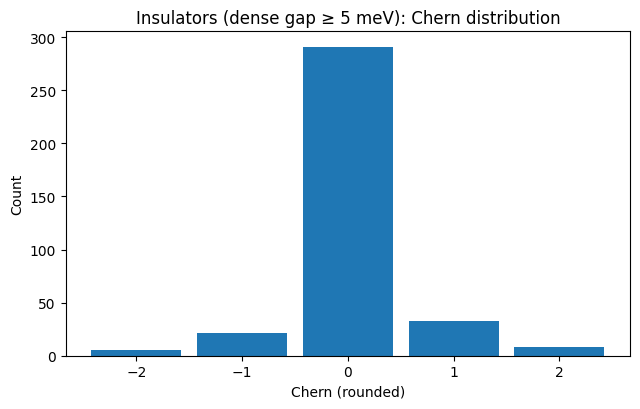

[OK] saved: E:\马睿骁\组会汇报\Nb2OSSe\pythTB\workflow\fig_insulators_chern_hist.png


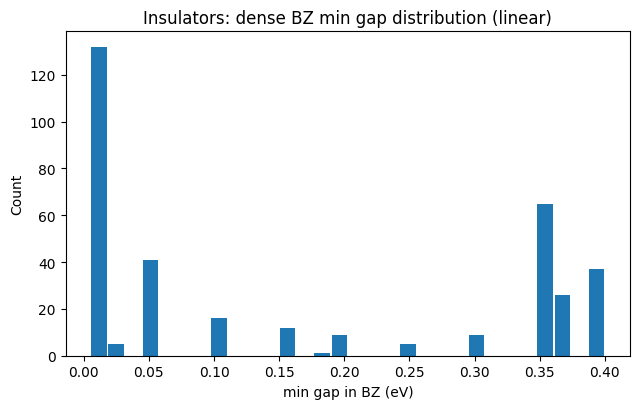

[OK] saved: E:\马睿骁\组会汇报\Nb2OSSe\pythTB\workflow\fig_insulators_gap_hist_linear.png


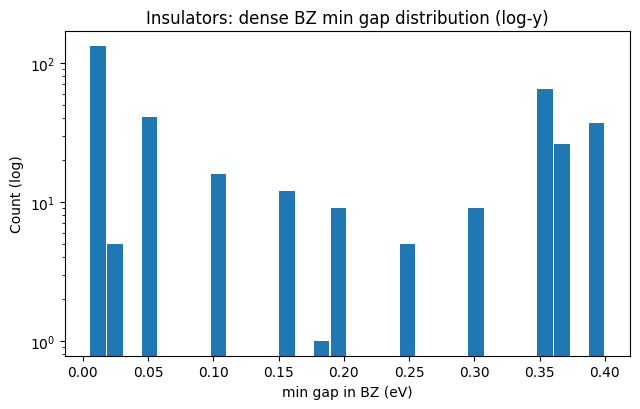

[OK] saved: E:\马睿骁\组会汇报\Nb2OSSe\pythTB\workflow\fig_insulators_gap_hist_logy.png


In [97]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

workdir = Path(r"E:\马睿骁\组会汇报\Nb2OSSe\pythTB\workflow")

# 你已有的关键文件
ins_csv   = workdir / "insulators_densegap_ge_5meV.csv"                 # 358 个绝缘体（dense gap>=5meV）
edges_csv = workdir / "boundary_edges_by_chern_change_dense.csv"        # 21 条边（chern 改变）
mid_csv   = workdir / "dense_midpoints_labeled_sortedgap.csv"           # 21 个中点（gap_sorted≈0）

df_ins = pd.read_csv(ins_csv, encoding="utf-8-sig")
df_edges = pd.read_csv(edges_csv, encoding="utf-8-sig")
df_mid = pd.read_csv(mid_csv, encoding="utf-8-sig")

for df in (df_ins, df_edges, df_mid):
    df.columns = [c.strip() for c in df.columns]

# 数值化
df_ins["chern_round"] = pd.to_numeric(df_ins["chern_round"], errors="coerce")
df_ins["gap_min_bz_eV_dense"] = pd.to_numeric(df_ins["gap_min_bz_eV_dense"], errors="coerce")

df_mid["chern_round"] = pd.to_numeric(df_mid.get("chern_round", np.nan), errors="coerce")
df_mid["gap_min_bz_eV_sorted"] = pd.to_numeric(df_mid.get("gap_min_bz_eV_sorted", np.nan), errors="coerce")

print("[INFO] insulators:", len(df_ins), "| boundary edges:", len(df_edges), "| midpoints:", len(df_mid))

# -------------------------
# Fig1: 绝缘体 Chern 分布
# -------------------------
fig = plt.figure(figsize=(6.5, 4.2))
vals = df_ins["chern_round"].dropna().astype(int).values
bins = np.arange(vals.min()-0.5, vals.max()+1.5, 1.0) if len(vals) else np.arange(-0.5, 0.6, 1.0)
plt.hist(vals, bins=bins, rwidth=0.85)
plt.xlabel("Chern (rounded)")
plt.ylabel("Count")
plt.title("Insulators (dense gap ≥ 5 meV): Chern distribution")
out1 = workdir / "fig_insulators_chern_hist.png"
plt.tight_layout()
plt.savefig(out1, dpi=300)
plt.show()
print("[OK] saved:", out1)

# -------------------------
# Fig2: 绝缘体 gap 分布（线性 + 对数）
# -------------------------
fig = plt.figure(figsize=(6.5, 4.2))
g = df_ins["gap_min_bz_eV_dense"].dropna().values
plt.hist(g, bins=30, rwidth=0.9)
plt.xlabel("min gap in BZ (eV)")
plt.ylabel("Count")
plt.title("Insulators: dense BZ min gap distribution (linear)")
out2 = workdir / "fig_insulators_gap_hist_linear.png"
plt.tight_layout()
plt.savefig(out2, dpi=300)
plt.show()
print("[OK] saved:", out2)

# 对数坐标（更利于看 5meV 附近）
fig = plt.figure(figsize=(6.5, 4.2))
g2 = g[g > 0]
plt.hist(g2, bins=30, rwidth=0.9)
plt.yscale("log")
plt.xlabel("min gap in BZ (eV)")
plt.ylabel("Count (log)")
plt.title("Insulators: dense BZ min gap distribution (log-y)")
out3 = workdir / "fig_insulators_gap_hist_logy.png"
plt.tight_layout()
plt.savefig(out3, dpi=300)
plt.show()
print("[OK] saved:", out3)


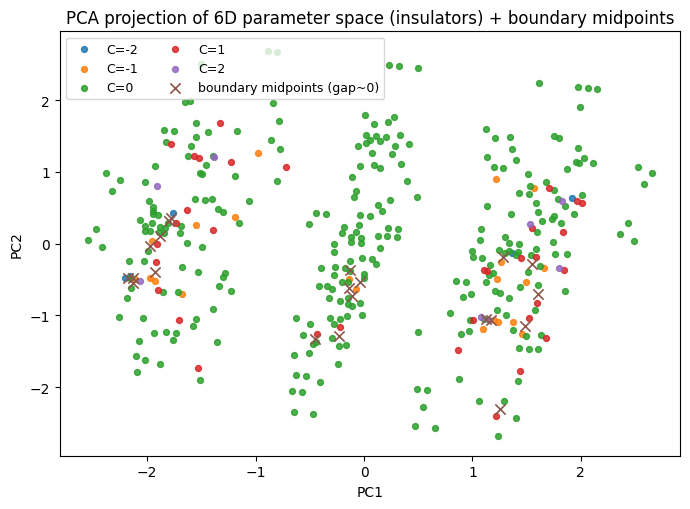

[OK] saved: E:\马睿骁\组会汇报\Nb2OSSe\pythTB\workflow\fig_pca_phase_projection_with_boundary_midpoints.png


In [99]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

workdir = Path(r"E:\马睿骁\组会汇报\Nb2OSSe\pythTB\workflow")

ins_csv = workdir / "insulators_densegap_ge_5meV.csv"
mid_csv = workdir / "dense_midpoints_labeled_sortedgap.csv"
edges_csv = workdir / "boundary_edges_by_chern_change_dense.csv"

df_ins = pd.read_csv(ins_csv, encoding="utf-8-sig")
df_mid = pd.read_csv(mid_csv, encoding="utf-8-sig")
df_edges = pd.read_csv(edges_csv, encoding="utf-8-sig")

for df in (df_ins, df_mid, df_edges):
    df.columns = [c.strip() for c in df.columns]

keys = ["e1","e2","t1","t2","t3","t4"]
for k in keys:
    df_ins[k] = pd.to_numeric(df_ins[k], errors="coerce")
    df_mid[k] = pd.to_numeric(df_mid[k], errors="coerce")

df_ins["chern_round"] = pd.to_numeric(df_ins["chern_round"], errors="coerce")

# -------------------------
# PCA (numpy SVD 实现)
# -------------------------
X = df_ins[keys].to_numpy(float)
mask = np.isfinite(X).all(axis=1) & np.isfinite(df_ins["chern_round"].to_numpy(float))
X = X[mask]
chern = df_ins.loc[mask, "chern_round"].to_numpy(float)

# 标准化
mu = X.mean(axis=0, keepdims=True)
sd = X.std(axis=0, keepdims=True)
sd[sd == 0] = 1.0
Z = (X - mu) / sd

# PCA via SVD
U, S, VT = np.linalg.svd(Z, full_matrices=False)
PC = Z @ VT.T[:, :2]  # (N,2)

# midpoints 投影到同一 PCA 空间
Xm = df_mid[keys].to_numpy(float)
maskm = np.isfinite(Xm).all(axis=1)
Zm = (Xm[maskm] - mu) / sd
PCm = Zm @ VT.T[:, :2]

# -------------------------
# Fig: PCA 相图投影 + 相界点
# -------------------------
plt.figure(figsize=(7.0, 5.2))

# 按 Chern 分组画（用 matplotlib 默认循环色，不手动指定颜色）
for ch in sorted(pd.unique(chern)):
    sel = (chern == ch)
    plt.scatter(PC[sel, 0], PC[sel, 1], s=18, label=f"C={int(ch)}", alpha=0.85)

# 相界中点：用 x 标记（黑色不指定也可以，但为了可读性这里不设颜色，只设 marker）
plt.scatter(PCm[:, 0], PCm[:, 1], s=55, marker="x", linewidths=1.2, label="boundary midpoints (gap~0)")

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA projection of 6D parameter space (insulators) + boundary midpoints")
plt.legend(frameon=True, fontsize=9, ncol=2)
plt.tight_layout()

outp = workdir / "fig_pca_phase_projection_with_boundary_midpoints.png"
plt.savefig(outp, dpi=300)
plt.show()
print("[OK] saved:", outp)


In [ ]:
简化版线扫：每条边只扫 3 个点（端点–中点–端点）

目标：对你那 21 条 “chern 改变的边” 验证：

端点是绝缘体（gap≥5meV，且 Chern 不同）

中点 gap≈0（拓扑相变必须发生的 gap closure）

这一步只用你“已有 hr”的点，稳定、可复现、不会陷入“插值点没 hr”的问题。

In [110]:
def solve_ham_evals(model, kpts):
    """
    Return evals as array with shape (nband, Nkpts).
    Compatible with solve_ham returning:
      - evals
      - (evals, evecs)
    and with evals shaped (nband, Nkpts) or (Nkpts, nband).
    """
    ret = model.solve_ham(k_pts=kpts)

    # case: (evals, evecs, ...) tuple/list
    if isinstance(ret, (tuple, list)):
        if len(ret) == 0:
            raise ValueError("solve_ham returned empty tuple/list")
        ret = ret[0]

    evals = np.asarray(ret)

    # force 2D
    if evals.ndim != 2:
        evals = evals.reshape(evals.shape[0], -1)

    Nkpts = kpts.shape[0]

    # If evals is (Nkpts, nband), transpose it
    if evals.shape[0] == Nkpts and evals.shape[1] != Nkpts:
        evals = evals.T

    # sanity: now should be (nband, Nkpts)
    if evals.shape[1] != Nkpts:
        raise ValueError(f"Unexpected evals shape {evals.shape}, Nkpts={Nkpts}")

    return evals


def min_gap_sorted(model, Nk=151, nocc=2):
    """
    Dense min direct gap in BZ using per-k sorted bands.
    Returns (gap_min, kx_at_min, ky_at_min).
    """
    kxs = np.linspace(0.0, 1.0, Nk, endpoint=False)
    kys = np.linspace(0.0, 1.0, Nk, endpoint=False)
    KX, KY = np.meshgrid(kxs, kys, indexing="ij")
    kpts = np.stack([KX.ravel(), KY.ravel()], axis=1)

    evals = solve_ham_evals(model, kpts)  # (nband, Nk^2)
    nband = evals.shape[0]
    if not (1 <= nocc <= nband - 1):
        raise ValueError(f"nocc={nocc} out of range for nband={nband}")

    evals = np.sort(evals, axis=0)        # sort bands at each k
    gaps = evals[nocc, :] - evals[nocc-1, :]
    imin = int(np.argmin(gaps))

    return float(gaps[imin]), float(kpts[imin, 0]), float(kpts[imin, 1])


In [111]:
# quick debug: check one endpoint model evals shape
e0 = df_edges.iloc[0]
pi0 = { "e1": e0["e1_i"], "e2": e0["e2_i"], "t1": e0["t1_i"], "t2": e0["t2_i"], "t3": e0["t3_i"], "t4": e0["t4_i"] }
hr_i0 = lookup_hr_from_params(pi0)
print("[DEBUG] hr_i0:", hr_i0)

m0 = get_tb_model(hr_i0)

# small kpts probe
kpts_probe = np.array([[0.0,0.0],[0.1,0.2],[0.3,0.4]], float)
ev_probe = solve_ham_evals(m0, kpts_probe)
print("[DEBUG] ev_probe shape (should be nband x Nkpts):", ev_probe.shape)
print("[DEBUG] ev_probe (first k):", ev_probe[:,0])


[DEBUG] hr_i0: E:\马睿骁\组会汇报\Nb2OSSe\pythTB\workflow\midpoints_hr\wannier90_mid_e1m100_e2m100_t1m100_t2p000_t3p000_t4p075\wannier90_mid_e1m100_e2m100_t1m100_t2p000_t3p000_t4p075.dat
[DEBUG] ev_probe shape (should be nband x Nkpts): (4, 3)
[DEBUG] ev_probe (first k): [-0.4 -0.4  0.2  0.2]


C:\Users\Administrator\AppData\Local\Temp\ipykernel_22996\3514254994.py:180: DeprecationWarning: pythtb.tb_model is deprecated and will be removed in a future release. Use TBModel instead.
  model = tb_model(dim_k=2, dim_r=2, lat=lat_vecs, orb=orb_vecs)


[DEBUG] idx rows used for hr_map: 4277 / 4277
[INFO] using n edges: 21


C:\Users\Administrator\AppData\Local\Temp\ipykernel_22996\3514254994.py:180: DeprecationWarning: pythtb.tb_model is deprecated and will be removed in a future release. Use TBModel instead.
  model = tb_model(dim_k=2, dim_r=2, lat=lat_vecs, orb=orb_vecs)


[OK] wrote: E:\马睿骁\组会汇报\Nb2OSSe\pythTB\workflow\dense_boundary_linescan_3pt.csv
status counts:
 status
OK    21
Name: count, dtype: int64
[INFO] gap_i stats:
 count    21.000000
mean      0.033267
std       0.068414
min       0.000595
25%       0.000595
50%       0.001754
75%       0.025344
max       0.196852
Name: gap_i_sorted_eV, dtype: float64
[INFO] gap_mid stats:
 count    21.000000
mean      0.022838
std       0.037590
min       0.000595
25%       0.000807
50%       0.003674
75%       0.015017
max       0.098599
Name: gap_mid_sorted_eV, dtype: float64
[INFO] gap_j stats:
 count    21.000000
mean      0.013355
std       0.041502
min       0.000595
25%       0.000595
50%       0.001067
75%       0.004161
max       0.191499
Name: gap_j_sorted_eV, dtype: float64


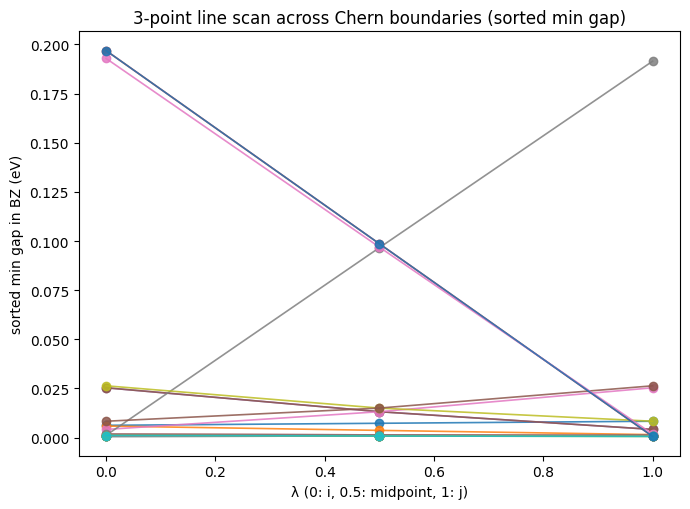

[OK] saved: E:\马睿骁\组会汇报\Nb2OSSe\pythTB\workflow\fig_dense_boundary_linescan_3pt.png


In [112]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

workdir = Path(r"E:\马睿骁\组会汇报\Nb2OSSe\pythTB\workflow")

idx_all_csv = workdir / "refine_all_labeled_with_dense_gap.csv"
mid_csv     = workdir / "dense_midpoints_labeled_sortedgap.csv"
edges_csv   = workdir / "boundary_edges_by_chern_change_dense.csv"

out_csv = workdir / "dense_boundary_linescan_3pt.csv"
out_fig = workdir / "fig_dense_boundary_linescan_3pt.png"

# ---------- 前置检查 ----------
if "build_model_from_hr" not in globals():
    raise NameError("build_model_from_hr 未定义：请先运行包含 build_model_from_hr 的那一格。")

# ---------- 读数据 ----------
df_all = pd.read_csv(idx_all_csv)
df_mid = pd.read_csv(mid_csv)
df_edges = pd.read_csv(edges_csv)

for df in [df_all, df_mid, df_edges]:
    df.columns = [c.strip() for c in df.columns]

keys = ["e1","e2","t1","t2","t3","t4"]

# ---------- 关键：统一拿到“真正的 model” ----------
def get_tb_model(hr_path: str):
    obj = build_model_from_hr(hr_path)
    # 有些版本/你的封装会返回 (model, meta...) 的 tuple
    if isinstance(obj, (tuple, list)):
        if len(obj) == 0:
            raise ValueError("build_model_from_hr returned empty tuple/list")
        obj = obj[0]
    return obj

# ---------- 关键：稳健拿 evals，保证 shape = (nband, Nkpts) ----------
def solve_ham_evals(model, kpts):
    ret = model.solve_ham(k_pts=kpts)

    # solve_ham 可能返回 (evals, evecs)
    if isinstance(ret, (tuple, list)):
        if len(ret) == 0:
            raise ValueError("solve_ham returned empty tuple/list")
        ret = ret[0]

    ev = np.asarray(ret)
    if ev.ndim != 2:
        ev = ev.reshape(ev.shape[0], -1)

    Nk = kpts.shape[0]
    # 如果是 (Nkpts, nband)，转置
    if ev.shape[0] == Nk and ev.shape[1] != Nk:
        ev = ev.T

    if ev.shape[1] != Nk:
        raise ValueError(f"Unexpected evals shape {ev.shape}, Nkpts={Nk}")

    return ev  # (nband, Nkpts)

# ---------- 关键：每个 k 点先排序，再取 nocc gap ----------
def min_gap_sorted(model, Nk=151, nocc=2):
    kxs = np.linspace(0.0, 1.0, Nk, endpoint=False)
    kys = np.linspace(0.0, 1.0, Nk, endpoint=False)
    KX, KY = np.meshgrid(kxs, kys, indexing="ij")
    kpts = np.stack([KX.ravel(), KY.ravel()], axis=1)

    ev = solve_ham_evals(model, kpts)     # (nband, Nk^2)
    nband = ev.shape[0]
    if not (1 <= nocc <= nband-1):
        raise ValueError(f"nocc={nocc} out of range for nband={nband}")

    ev = np.sort(ev, axis=0)             # 每个 k 点按能量排序
    gaps = ev[nocc, :] - ev[nocc-1, :]
    imin = int(np.argmin(gaps))
    return float(gaps[imin]), float(kpts[imin,0]), float(kpts[imin,1])

# ---------- 用“整数编码”建立稳健索引 ----------
SCALE = 10000  # 对 0.025/0.0125 步长足够稳健

def key_int(x):
    return int(np.rint(float(x) * SCALE))

idx = df_all.dropna(subset=["hr_file"]).copy()
for k in keys:
    idx[k] = pd.to_numeric(idx[k], errors="coerce")
    idx[f"{k}_key"] = idx[k].map(key_int)

idx = idx.dropna(subset=[f"{k}_key" for k in keys])
idx = idx.drop_duplicates(subset=[f"{k}_key" for k in keys])

hr_map = {
    tuple(row[f"{k}_key"] for k in keys): str(row["hr_file"])
    for _, row in idx.iterrows()
}

print(f"[DEBUG] idx rows used for hr_map: {len(idx)} / {len(df_all)}")

def lookup_hr_from_params(pdict):
    kk = tuple(key_int(pdict[k]) for k in keys)
    return hr_map.get(kk, None)

# ---------- 主循环：逐条边界边算 i/mid/j ----------
df_edges = df_edges.reset_index(drop=True)
df_mid = df_mid.reset_index(drop=True)
n = min(len(df_edges), len(df_mid))
print("[INFO] using n edges:", n)

Nk_dense = 151
Nocc = 2  # 四带：下两条价带

rows = []
fail = 0

for r in range(n):
    e = df_edges.loc[r]
    m = df_mid.loc[r]

    pi = { "e1": e["e1_i"], "e2": e["e2_i"], "t1": e["t1_i"], "t2": e["t2_i"], "t3": e["t3_i"], "t4": e["t4_i"] }
    pj = { "e1": e["e1_j"], "e2": e["e2_j"], "t1": e["t1_j"], "t2": e["t2_j"], "t3": e["t3_j"], "t4": e["t4_j"] }
    pm = { k: m[k] for k in keys }

    hr_i = lookup_hr_from_params(pi)
    hr_j = lookup_hr_from_params(pj)

    # mid 优先用自身 hr_file
    if "hr_file" in df_mid.columns and pd.notna(m.get("hr_file", np.nan)):
        hr_mid = str(m["hr_file"])
    else:
        hr_mid = lookup_hr_from_params(pm)

    status, err = "OK", ""
    gi = gm = gj = np.nan
    kxi = kyi = kxm = kym = kxj = kyj = np.nan

    try:
        if (hr_i is None) or (hr_j is None) or (hr_mid is None):
            raise FileNotFoundError(f"missing hr: i={hr_i}, mid={hr_mid}, j={hr_j}")

        model_i = get_tb_model(hr_i)
        model_m = get_tb_model(hr_mid)
        model_j = get_tb_model(hr_j)

        gi, kxi, kyi = min_gap_sorted(model_i, Nk=Nk_dense, nocc=Nocc)
        gm, kxm, kym = min_gap_sorted(model_m, Nk=Nk_dense, nocc=Nocc)
        gj, kxj, kyj = min_gap_sorted(model_j, Nk=Nk_dense, nocc=Nocc)

    except Exception as ex:
        status = "FAIL"
        err = str(ex)
        fail += 1

    rows.append({
        "edge_id": r,
        "chern_i": e.get("chern_i", np.nan),
        "chern_j": e.get("chern_j", np.nan),
        "hr_i": hr_i, "hr_mid": hr_mid, "hr_j": hr_j,
        "gap_i_sorted_eV": gi, "kmin_i_kx": kxi, "kmin_i_ky": kyi,
        "gap_mid_sorted_eV": gm, "kmin_mid_kx": kxm, "kmin_mid_ky": kym,
        "gap_j_sorted_eV": gj, "kmin_j_kx": kxj, "kmin_j_ky": kyj,
        "status": status,
        "error": err
    })

out = pd.DataFrame(rows)
out.to_csv(out_csv, index=False, encoding="utf-8-sig")
print("[OK] wrote:", out_csv)
print("status counts:\n", out["status"].value_counts())
if fail > 0:
    print("[TOP errors]\n", out.loc[out["status"]=="FAIL", "error"].value_counts().head(8))

ok = out[out["status"]=="OK"].copy()
if len(ok) == 0:
    print("[WARN] no OK rows; skip plotting.")
else:
    # --- 关键 sanity check：端点不应全为 0 ---
    print("[INFO] gap_i stats:\n", ok["gap_i_sorted_eV"].describe())
    print("[INFO] gap_mid stats:\n", ok["gap_mid_sorted_eV"].describe())
    print("[INFO] gap_j stats:\n", ok["gap_j_sorted_eV"].describe())

    if np.allclose(ok["gap_i_sorted_eV"].fillna(0).values, 0.0) and np.allclose(ok["gap_j_sorted_eV"].fillna(0).values, 0.0):
        print("\n[WARN] All endpoint gaps are ~0. This is NOT expected if endpoints are true insulators.")
        # 打印第一条 edge 做人工核查
        rr = ok.iloc[0]
        print("[DEBUG] first OK edge hr_i:", rr["hr_i"])
        print("[DEBUG] first OK edge hr_j:", rr["hr_j"])
        mi = get_tb_model(rr["hr_i"])
        gi1,_,_ = min_gap_sorted(mi, Nk=Nk_dense, nocc=Nocc)
        print("[DEBUG] recompute endpoint i gap (should be >0):", gi1)

    # --- 画图 ---
    plt.figure(figsize=(7,5.2))
    for _, rr in ok.iterrows():
        plt.plot([0.0, 0.5, 1.0],
                 [rr["gap_i_sorted_eV"], rr["gap_mid_sorted_eV"], rr["gap_j_sorted_eV"]],
                 marker="o", lw=1.2, alpha=0.85)
    plt.xlabel("λ (0: i, 0.5: midpoint, 1: j)")
    plt.ylabel("sorted min gap in BZ (eV)")
    plt.title("3-point line scan across Chern boundaries (sorted min gap)")
    plt.tight_layout()
    plt.savefig(out_fig, dpi=220)
    plt.show()
    print("[OK] saved:", out_fig)
